In [1]:
%matplotlib widget

In [2]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib as mpl
import matplotlib.animation as animation

import seaborn as sns
from statannot import add_stat_annotation

from scipy.linalg import expm
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from scipy import stats

import os
import pickle

import xmltodict

import logging, time
import itertools
import warnings

In [3]:
# import opensim_ipython as osim

# import sys
# # Are we running this script as a test? Users can ignore this line!
# running_as_test = True  #'unittest' in str().join(sys.argv)

# # Define global model where the arm lives.
# arm = osim.Model()
# if not running_as_test: arm.setUseVisualizer(True)

# # ---------------------------------------------------------------------------
# # Create two links, each with a mass of 1 kg, centre of mass at the body's
# # origin, and moments and products of inertia of zero.
# # ---------------------------------------------------------------------------

# humerus = osim.Body("humerus",
#                     1.0,
#                     osim.Vec3(0, 0, 0),
#                     osim.Inertia(0, 0, 0))
# radius = osim.Body("radius",
#                    1.0,
#                    osim.Vec3(0, 0, 0),
#                    osim.Inertia(0, 0, 0))

# # ---------------------------------------------------------------------------
# # Connect the bodies with pin joints. Assume each body is 1m long.
# # ---------------------------------------------------------------------------

# shoulder = osim.PinJoint("shoulder",
#                          arm.getGround(), # PhysicalFrame
#                          osim.Vec3(0, 0, 0),
#                          osim.Vec3(0, 0, 0),
#                          humerus, # PhysicalFrame
#                          osim.Vec3(0, 1, 0),
#                          osim.Vec3(0, 0, 0))

# elbow = osim.PinJoint("elbow",
#                       humerus, # PhysicalFrame
#                       osim.Vec3(0, 0, 0),
#                       osim.Vec3(0, 0, 0),
#                       radius, # PhysicalFrame
#                       osim.Vec3(0, 1, 0),
#                       osim.Vec3(0, 0, 0))

# # ---------------------------------------------------------------------------
# # Add a muscle that flexes the elbow (actuator for robotics people).
# # ---------------------------------------------------------------------------

# biceps = osim.Millard2012EquilibriumMuscle("biceps",  # Muscle name
#                                            200.0,  # Max isometric force
#                                            0.6,  # Optimal fibre length
#                                            0.55,  # Tendon slack length
#                                            0.0)  # Pennation angle
# biceps.addNewPathPoint("origin",
#                        humerus,
#                        osim.Vec3(0, 0.8, 0))

# biceps.addNewPathPoint("insertion",
#                        radius,
#                        osim.Vec3(0, 0.7, 0))

# # ---------------------------------------------------------------------------
# # Add a controller that specifies the excitation of the muscle.
# # ---------------------------------------------------------------------------

# brain = osim.PrescribedController()
# brain.addActuator(biceps)
# brain.prescribeControlForActuator("biceps",
#                                   osim.StepFunction(0.5, 3.0, 0.3, 1.0))

# # ---------------------------------------------------------------------------
# # Build model with components created above.
# # ---------------------------------------------------------------------------

# arm.addBody(humerus)
# arm.addBody(radius)
# arm.addJoint(shoulder) # Now required in OpenSim4.0
# arm.addJoint(elbow)
# arm.addForce(biceps)
# arm.addController(brain)

# # ---------------------------------------------------------------------------
# # Add a console reporter to print the muscle fibre force and elbow angle.
# # ---------------------------------------------------------------------------

# # We want to write our simulation results to the console.
# reporter = osim.ConsoleReporter()
# reporter.set_report_time_interval(1.0)
# reporter.addToReport(biceps.getOutput("fiber_force"))
# elbow_coord = elbow.getCoordinate().getOutput("value")
# reporter.addToReport(elbow_coord, "elbow_angle")
# arm.addComponent(reporter)

# # ---------------------------------------------------------------------------
# # Add display geometry. 
# # ---------------------------------------------------------------------------

# bodyGeometry = osim.Ellipsoid(0.1, 0.5, 0.1)
# bodyGeometry.setColor(osim.Gray)
# humerusCenter = osim.PhysicalOffsetFrame()
# humerusCenter.setName("humerusCenter")
# humerusCenter.setParentFrame(humerus)
# humerusCenter.setOffsetTransform(osim.Transform(osim.Vec3(0, 0.5, 0)))
# humerus.addComponent(humerusCenter)
# humerusCenter.attachGeometry(bodyGeometry.clone())

# radiusCenter = osim.PhysicalOffsetFrame()
# radiusCenter.setName("radiusCenter")
# radiusCenter.setParentFrame(radius)
# radiusCenter.setOffsetTransform(osim.Transform(osim.Vec3(0, 0.5, 0)))
# radius.addComponent(radiusCenter)
# radiusCenter.attachGeometry(bodyGeometry.clone())

# # ---------------------------------------------------------------------------
# # Configure the model.
# # ---------------------------------------------------------------------------

# state = arm.initSystem()
# # Fix the shoulder at its default angle and begin with the elbow flexed.
# shoulder.getCoordinate().setLocked(state, True)
# elbow.getCoordinate().setValue(state, 0.5 * osim.SimTK_PI)
# arm.equilibrateMuscles(state)

# # ---------------------------------------------------------------------------
# # Simulate.
# # ---------------------------------------------------------------------------

# manager = osim.Manager(arm)
# state.setTime(0)
# manager.initialize(state)
# state = manager.integrate(10.0)

# # ---------------------------------------------------------------------------
# # Print/save model file
# # ---------------------------------------------------------------------------

# arm.printToXML("SimpleArm.osim")

In [4]:
independent_joints = [#'eye-rx',
 #'eye-ry',
 'elv_angle',
 'shoulder_elv',
 'shoulder_rot',
 'elbow_flexion',
 'pro_sup',
 #'deviation',
 #'flexion'
 ]

actuator_names = ['DELT1',
 'DELT2',
 'DELT3',
 'SUPSP',
 'INFSP',
 'SUBSC',
 'TMIN',
 'TMAJ',
 'PECM1',
 'PECM2',
 'PECM3',
 'LAT1',
 'LAT2',
 'LAT3',
 'CORB',
 'TRIlong',
 'TRIlat',
 'TRImed',
 'ANC',
 'SUP',
 'BIClong',
 'BICshort',
 'BRA',
 'BRD',
 #'ECRL',
 #'ECRB',
 #'ECU',
 #'FCR',
 #'FCU',
 #'PL',
 'PT',
 'PQ',
 # 'FDSL',
 # 'FDSR',
 # 'FDSM',
 # 'FDSI',
 # 'FDPL',
 # 'FDPR',
 # 'FDPM',
 # 'FDPI',
 # 'EDCL',
 # 'EDCR',
 # 'EDCM',
 # 'EDCI',
 # 'EDM',
 # 'EIP',
 # 'EPL',
 # 'EPB',
 # 'FPL',
 #'APL'
 ]

actuator_names_dict = {'DELT1': 'deltoid1_r',
 'DELT2': 'deltoid2_r',
 'DELT3': 'deltoid3_r',
 'SUPSP': 'supraspinatus_r',
 'INFSP': 'infraspinatus_r',
 'SUBSC': 'subscapularis_r',
 'TMIN': 'teres_minor_r',
 'TMAJ': 'teres_major_r',
 'PECM1': 'pectoralis_major1_r',
 'PECM2': 'pectoralis_major2_r',
 'PECM3': 'pectoralis_major3_r',
 'LAT1': 'latissimus_dorsi1_r',
 'LAT2': 'latissimus_dorsi2_r',
 'LAT3': 'latissimus_dorsi3_r',
 'CORB': 'coracobrachialis_r',
 'TRIlong': 'triceps_longhead_r',
 'TRIlat': 'triceps_lateralis_r',
 'TRImed': 'triceps_medialis_r',
 'ANC': 'anconeus_r',
 'SUP': 'supinator_brevis_r',
 'BIClong': 'biceps_longhead_r',
 'BICshort': 'biceps_shorthead_r',
 'BRA': 'brachialis_r',
 'BRD': 'brachioradialis_r',
 'PT': 'pronator_teres_r',
 'PQ': 'pron_quad_r'}

In [125]:
### BASE CLASS FOR TRAJECTORY DATA
class TrajectoryData(object):
    
    SHOW_MINJERK = False  #if this is set to True, end-effector methods yield MinJerk trajectories instead of actual trajectories!

    def __init__(self):
        self.initialized = True
        self.preprocessed = False
        self.trials_defined = False
        
    # methods to override:
    # ----------------------------
    
    def preprocess(self):
        raise NotImplementedError
    
    def compute_indices(self):
        raise NotImplementedError
    
    
    # read-only properties:
    #-----------------------------
    
    @property
    def position_series(self):
        if self.SHOW_MINJERK:
            return self._minjerk_position_series
        return self._position_series
    
    @property
    def velocity_series(self):
        if self.SHOW_MINJERK:
            return self._minjerk_velocity_series
        return self._velocity_series
    
    @property
    def acceleration_series(self):
        if self.SHOW_MINJERK:
            return self._minjerk_acceleration_series
        return self._acceleration_series
    
    @property
    def qpos_series(self):
        return self._qpos_series
    
    @property
    def qvel_series(self):
        return self._qvel_series
    
    @property
    def qacc_series(self):
        return self._qacc_series
    
    @property
    def act_series(self):
        return self._act_series
    
    @property
    def target_position_series(self):
        return self._target_position_series
    
    @property
    def target_radius_series(self):
        return self._target_radius_series
    
    @property
    def target_idx_series(self):
        return self._target_idx_series
    
    @property
    def time_series(self):
        return self._time_series
    
    @property
    def time_per_step(self):
        return self._time_per_step
    
    @property
    def indices(self):
        return self._indices
    
    @property
    def action_series(self):
        return self._action_series
    
    @property
    def control_series(self):
        return self._control_series
    
    @property
    def reward_series(self):
        return self._reward_series
    
    
    #-----------------------------

    def compute_minjerk(self, MINJERK_USER_CONSTRAINTS=True):
        assert self.initialized and self.preprocessed and self.trials_defined, "ERROR: Need to call preprocess() and compute_indices() first! "
        
        ## REFERENCE TRAJECTORY: MinJerk
        self._minjerk_position_series = np.zeros_like(np.squeeze(self._position_series)) * np.nan
        self._minjerk_velocity_series = np.zeros_like(np.squeeze(self._velocity_series)) * np.nan
        self._minjerk_acceleration_series = np.zeros_like(np.squeeze(self._acceleration_series)) * np.nan
        
        for episode_index_current, (last_idx, current_idx, next_idx) in enumerate(self.selected_movements_indices):
            if isinstance(last_idx, list):
                assert len(last_idx) == 1, "Indices are prepared for computing summary statistics. Use compute_statistics() instead."  #e.g., if len(AGGREGATION_VARS) > 0
                last_idx = last_idx[0]
                current_idx = current_idx[0]
                next_idx = next_idx[0]
            
            if MINJERK_USER_CONSTRAINTS:
                T = [np.concatenate((self._position_series[current_idx], self._position_series[next_idx - 1]))]
            else:
                T = [np.squeeze([self._target_position_series[last_idx] if last_idx >= 0 else self._position_series[0], self._target_position_series[current_idx]]).reshape(-1,)]
            x0 = np.concatenate((np.squeeze([self._position_series[current_idx], self._velocity_series[current_idx], self._acceleration_series[current_idx]]).reshape(-1,), T[0]))
            dim = 3
            x_minjerk, u_minjerk = minimumjerk_deterministic(next_idx - current_idx - 1, x0=x0, T=T, final_vel=self._velocity_series[next_idx - 1], final_acc=self._acceleration_series[next_idx - 1], P=2, dim=dim, dt=self._time_per_step, initialuservalues=None)
            self._minjerk_position_series[current_idx: next_idx] = x_minjerk[:, :dim]
            self._minjerk_velocity_series[current_idx: next_idx] = x_minjerk[:, dim:2*dim]
            self._minjerk_acceleration_series[current_idx: next_idx] = x_minjerk[:, 2*dim:3*dim]
            
    def get_statistics_info(self):
        if hasattr(self, "stats_episode_index_current"):
            return {"episode_index_current": self.stats_episode_index_current, "compute_deviation": self.stats_compute_deviation, "normalize_time": self.stats_normalize_time}
            
    def compute_statistics(self, episode_index_current, effective_projection_path=False, compute_deviation=False, normalize_time=False):
        self.stats_episode_index_current = episode_index_current
        self.stats_compute_deviation = compute_deviation
        self.stats_normalize_time = normalize_time
        
        if normalize_time:
            logging.warning(f"NORMALIZE_TIME was set to True, but is has no effect on the computation of distributions (mean, variability, etc.)!")
        
        last_idx_hlp, current_idx_hlp, next_idx_hlp = self.selected_movements_indices[episode_index_current]
        
        assert isinstance(last_idx_hlp, list), "No data to aggregate. Use compute_trial() instead."  #e.g., if len(AGGREGATION_VARS) > 0
        
        if effective_projection_path:  #ensures that first and last value of projected_trajectories_pos_trial equal 0 and 1, respectively
            init_val = self.position_series[current_idx_hlp]
            final_val = self.position_series[[i - 1 for i in next_idx_hlp]]
        else:
            init_val = np.unique(self.target_position_series[[i+1 for i in last_idx_hlp if i>=0]], axis=0).reshape(-1,)
            final_val = np.unique(self.target_position_series[[i+1 for i in current_idx_hlp if i>=0]], axis=0).reshape(-1,)
            assert init_val.shape == (3,), "ERROR: Cannot reliably determine (nominal) initial position."
            assert final_val.shape == (3,), "ERROR: Cannot reliably determine (nominal) target position."
            assert init_val is not final_val, "ERROR: Initial and target position do not differ!"
        
        self.init_val = init_val
        self.final_val = final_val
        
        # for current_idx, next_idx in zip(current_idx_hlp, next_idx_hlp):
        #     input((self.init_val, self.position_series[current_idx], self.final_val, self.position_series[next_idx]))

        self.projected_trajectories_pos_mean, self.projected_trajectories_pos_cov, self.projected_trajectories_pos_min, self.projected_trajectories_pos_max = compute_trajectory_statistics(self.position_series, current_idx_hlp, next_idx_hlp, project=True, init_val=init_val, final_val=final_val, use_rel_vals=True, output_deviation=compute_deviation)
        self.projected_trajectories_vel_mean, self.projected_trajectories_vel_cov, self.projected_trajectories_vel_min, self.projected_trajectories_vel_max = compute_trajectory_statistics(self.velocity_series, current_idx_hlp, next_idx_hlp, project=True, init_val=init_val, final_val=final_val, use_rel_vals=False, output_deviation=compute_deviation)
        self.projected_trajectories_acc_mean, self.projected_trajectories_acc_cov, self.projected_trajectories_acc_min, self.projected_trajectories_acc_max = compute_trajectory_statistics(self.acceleration_series, current_idx_hlp, next_idx_hlp, project=True, init_val=init_val, final_val=final_val, use_rel_vals=False, output_deviation=compute_deviation)
        self.qpos_series_mean, self.qpos_series_cov, self.qpos_series_min, self.qpos_series_max = compute_trajectory_statistics(self.qpos_series, current_idx_hlp, next_idx_hlp)
        self.qvel_series_mean, self.qvel_series_cov, self.qvel_series_min, self.qvel_series_max = compute_trajectory_statistics(self.qvel_series, current_idx_hlp, next_idx_hlp)
        self.qacc_series_mean, self.qacc_series_cov, self.qacc_series_min, self.qacc_series_max = compute_trajectory_statistics(self.qacc_series, current_idx_hlp, next_idx_hlp)
        self.target_pos_mean, self.target_pos_cov, _, _ = compute_trajectory_statistics(self.target_position_series, current_idx_hlp, next_idx_hlp)
        self.target_radius_mean, self.target_radius_cov, _, _ = compute_trajectory_statistics(self.target_radius_series, current_idx_hlp, next_idx_hlp)
        self.target_idx_mean, self.target_idx_cov, _, _ = compute_trajectory_statistics(self.target_idx_series, current_idx_hlp, next_idx_hlp)
        self.target_idx_mean = self.target_idx_mean.astype(int)
        _, self.time_series_cov, self.time_series_extended, _ = compute_trajectory_statistics(self.time_series, current_idx_hlp, next_idx_hlp, rel_to_init=True, normalize=normalize_time)
        if not normalize_time and not (np.isclose(self.time_series_cov, 0).all() or np.isnan(self.time_series_cov).all()):
            raise ValueError(f"ERROR: Ensure that time series are correctly aligned.")
         
    def compute_action_statistics(self, episode_index_current, normalize_time=False):
        self.action_stats_episode_index_current = episode_index_current
        self.action_stats_normalize_time = normalize_time
        
        if normalize_time:
            logging.warning(f"NORMALIZE_TIME was set to True, but is has no effect on the computation of distributions (mean, variability, etc.)!")
        
        last_idx_hlp, current_idx_hlp, next_idx_hlp = self.selected_movements_indices[episode_index_current]
        
        assert isinstance(last_idx_hlp, list), "No data to aggregate. Use compute_trial() instead."  #e.g., if len(AGGREGATION_VARS) > 0
        
        if hasattr(self, "_action_series"):
            self.action_series_mean, self.action_series_cov, self.action_series_min, self.action_series_max = compute_trajectory_statistics(self.action_series, current_idx_hlp, next_idx_hlp)
        if hasattr(self, "_control_series"):
            self.control_series_mean, self.control_series_cov, self.control_series_min, self.control_series_max = compute_trajectory_statistics(self.control_series, current_idx_hlp, next_idx_hlp)
        if hasattr(self, "_reward_series"):
            self.reward_series_mean, self.reward_series_cov, self.reward_series_min, self.reward_series_max = compute_trajectory_statistics(self.reward_series, current_idx_hlp, next_idx_hlp)
        _, self.action_stats_time_series_cov, self.action_stats_time_series_extended, _ = compute_trajectory_statistics(self.time_series, current_idx_hlp, next_idx_hlp, rel_to_init=True, normalize=normalize_time)
        if not normalize_time and not (np.isclose(self.action_stats_time_series_cov, 0).all() or np.isnan(self.action_stats_time_series_cov).all()):
            raise ValueError(f"ERROR: Ensure that time series are correctly aligned.")
            
    def get_trial_info(self):
        if hasattr(self, "trial_index_current"):
            return {"trial_index_current": self.trial_index_current, "compute_deviation": self.trial_compute_deviation, "normalize_time": self.trial_normalize_time, "joint_id": self.trial_joint_id}        

    def compute_trial(self, trial_index_current, effective_projection_path=False, targetbound_as_target=False, dwell_time=0, compute_deviation=False, normalize_time=False):
        self.trial_index_current = trial_index_current
        self.trial_effective_projection_path = effective_projection_path
        self.trial_targetbound_as_target = targetbound_as_target
        self.trial_dwell_time = dwell_time  #in seconds; used for movement time computation (e.g., for Fitts' Law)
        self.trial_compute_deviation = compute_deviation
        self.trial_normalize_time = normalize_time
        
        last_idx, current_idx, next_idx = self.selected_movements_indices[trial_index_current]
        
        if isinstance(last_idx, list):
            assert len(last_idx) == 1, "Indices are prepared for computing summary statistics. Use compute_statistics() instead."  #e.g., if len(AGGREGATION_VARS) > 0
            last_idx = last_idx[0]
            current_idx = current_idx[0]
            next_idx = next_idx[0]
        
        time_series_shifted = np.array(self.time_series[current_idx: next_idx]) - self.time_series[current_idx]
        if normalize_time:
            time_series_shifted = (time_series_shifted - time_series_shifted[0])/(time_series_shifted[-1] - time_series_shifted[0])
        self.time_series_trial = time_series_shifted
        
        # compute (relative) indices at which end-effector is inside target ("relindices_insidetarget_trial") ["+ 1" is used to avoid errors if target switches one step too late...] #TODO: ensure that target switch indices are exact!
        try:  #use "target_radius" column
            assert len(np.unique(self.target_radius_series[current_idx + 1: next_idx])) == 1, "ERROR: Target radius changes during movement! Cannot find reliable information about when target has been entered.\nFix dataset or use target center as distance (set 'targetbound_as_target=False')."
            self.relindices_insidetarget_trial = np.where(np.linalg.norm(np.array(self.position_series[current_idx + 1: next_idx]) - np.array(self.target_position_series[current_idx + 1: next_idx]), axis=1) < self.target_radius_series[current_idx + 1])[0]
        except:  #use "inside_target" column
            self.relindices_insidetarget_trial = np.where(self.data[self.data_key]["inside_target"][current_idx + 1:next_idx])[0]

        if self.trial_targetbound_as_target:    
            assert len(rel_indices_targetbound) > 0, "Using target boundary instead of target center as desired target position failed."
            targetbound_idx = (current_idx + 1 + rel_indices_targetbound[0]) + 1  #adding 1: -> targetbound_idx corresponds to first index that is not included anymore in considered trial series
            next_idx = targetbound_idx
                
        if effective_projection_path:  #ensures that first and last value of projected_trajectories_pos_trial equal 0 and 1, respectively
            init_val = self.position_series[current_idx]
            final_val = self.position_series[next_idx - 1]
        else:
            init_val = self.target_position_series[last_idx + 1] if last_idx >= 0 else self.position_series[0]
            final_val = self.target_position_series[current_idx + 1]
            # TODO: use target boundary position as final_val if self.trial_targetbound_as_target?
        
        self.init_val = init_val
        self.final_val = final_val
        
        self.target_position_series_trial = self.target_position_series[current_idx: next_idx]
        self.target_radius_series_trial = self.target_radius_series[current_idx: next_idx]
        self.target_idx_series_trial = self.target_idx_series[current_idx: next_idx]
        
        self.position_series_trial = self.position_series[current_idx: next_idx]
        self.velocity_series_trial = self.velocity_series[current_idx: next_idx]
        self.acceleration_series_trial = self.acceleration_series[current_idx: next_idx]
        self.projected_trajectories_pos_trial = project_trajectory(self.position_series_trial, init_val=init_val, final_val=final_val, use_rel_vals=True, output_deviation=compute_deviation)
        self.projected_trajectories_vel_trial = project_trajectory(self.velocity_series_trial, init_val=init_val, final_val=final_val, use_rel_vals=False, output_deviation=compute_deviation)
        self.projected_trajectories_acc_trial = project_trajectory(self.acceleration_series_trial, init_val=init_val, final_val=final_val, use_rel_vals=False, output_deviation=compute_deviation)
        self.qpos_series_trial = self.qpos_series[current_idx: next_idx, :]
        self.qvel_series_trial = self.qvel_series[current_idx: next_idx, :]
        self.qacc_series_trial = self.qacc_series[current_idx: next_idx, :]
        
        #Optional attributes
        for attr in ["act_series", "action_series", "control_series", "reward_series"]:
            if hasattr(self, f"_{attr}") and getattr(self, f"_{attr}") is not None:
                setattr(self, f"{attr}_trial", getattr(self, f"_{attr}")[current_idx: next_idx, ...])
        
        #Statistics
        self.target_width_trial = 2 * self.target_radius_series[current_idx]
        self.target_distance_trial = np.linalg.norm(self.final_val - self.init_val)
        self.fitts_ID_trial = np.log2(2*self.target_distance_trial/self.target_width_trial)
        if self.trial_targetbound_as_target:
            self.effective_MT_trial = (next_idx - current_idx)*self.time_per_step  #here: next_idx <- targetbound_idx
        else:
            self.effective_MT_trial = (next_idx - current_idx)*self.time_per_step - self.trial_dwell_time
        
        # compute number of target (re-)entries and covariance of end-effector position when inside target (i.e., only for "relindices_insidetarget_trial")
        target_re_entries_meta_indices = np.where(np.diff(self.relindices_insidetarget_trial) != 1)[0] + 1
        self.num_target_entries_trial = len(target_re_entries_meta_indices) + 1 if target_re_entries_meta_indices.size > 0 else 0
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            position_series_trial_insidetarget = np.array(self.position_series_trial)[self.relindices_insidetarget_trial]
            self.endeffector_insidetarget_covariance = np.cov(position_series_trial_insidetarget, rowvar=False) if position_series_trial_insidetarget.shape[0] != 1 else np.zeros((position_series_trial_insidetarget.shape[1], position_series_trial_insidetarget.shape[1]))



In [5]:
trajectories_STUDY.indices#.shape
trajectories_STUDY.TASK_CONDITION

NameError: name 'trajectories_STUDY' is not defined

In [126]:
### PRE-PROCESS SIMULATION DATA FROM ALEKSI'S RL ENVIRONMENT
class TrajectoryData_RL(TrajectoryData):
    
    def __init__(self, filename, REPEATED_MOVEMENTS=False):
        
        self.filepath = os.path.expanduser(f"~/user-in-the-box/output/{filename}/")  #warning: here, "self.filepath" is directory!
        self.REPEATED_MOVEMENTS = REPEATED_MOVEMENTS  #if True, combine individual log files into one data structure
        
        super().__init__()
        
        if self.REPEATED_MOVEMENTS:
            rep_movs_data = {}
            rep_movs_data_action = {}
            for subdir in [i for i in os.listdir((os.path.expanduser(self.filepath))) if os.path.isdir(os.path.join(os.path.expanduser(self.filepath), i))]:
                subdir_abs = os.path.join(os.path.expanduser(self.filepath), subdir)
                for subsubdir in [i for i in os.listdir(subdir_abs) if os.path.isdir(os.path.join(subdir_abs, i))]:
                    subsubdir_abs = os.path.join(os.path.expanduser(self.filepath), subdir, subsubdir)
                    rep_movs_filepath = os.path.join(subsubdir_abs, "state_log.pickle")
                    rep_movs_filepath_action = os.path.join(subsubdir_abs, "action_log.pickle")
                    with open(os.path.expanduser(rep_movs_filepath), "rb") as f:
                        helper = pickle.load(f)
                        for k, v in helper.items():
                            rep_movs_data[f"{subdir}__{subsubdir}__{k}"] = v
                    with open(os.path.expanduser(rep_movs_filepath_action), "rb") as f:
                        helper = pickle.load(f)
                        for k, v in helper.items():
                            rep_movs_data_action[f"{subdir}__{subsubdir}__{k}"] = v
            self.data = rep_movs_data
            self.data_action = rep_movs_data_action
        else:
            with open(os.path.join(self.filepath, "state_log.pickle"), "rb") as f:
                self.data = pickle.load(f)
            with open(os.path.join(self.filepath, "action_log.pickle"), "rb") as f:
                self.data_action = pickle.load(f)
                
        self.EPISODE_ID_NUMS = len(np.unique(list(map(lambda x: x.split('episode_')[-1].split('_')[0], self.data.keys()))))
        print(f"{self.EPISODE_ID_NUMS} episodes identified.")
                
        self.data_copy = self.data.copy()
        self.data_action_copy = self.data_action.copy()
        
    def preprocess(self, MOVEMENT_IDS=None, RADIUS_IDS=None, EPISODE_IDS=None):
        # INFO: "MOVEMENT_IDS", "RADIUS_IDS", and "EPISODE_IDS" should be array-like (list, np.array, range-object, etc.)
        
        self.EPISODE_IDS = [str(EPISODE_ID).zfill(len(list(self.data.keys())[0].split("episode_")[-1].split("__")[0])) for EPISODE_ID in EPISODE_IDS or np.unique([int(i.split("episode_")[-1].split("__")[0]) for i in list(self.data.keys())])]
        
        if self.REPEATED_MOVEMENTS:
            self.MOVEMENT_IDS = [str(MOVEMENT_ID).zfill(len(list(self.data.keys())[0].split("movement_")[-1].split("__")[0])) for MOVEMENT_ID in MOVEMENT_IDS or np.unique([int(i.split("movement_")[-1].split("__")[0]) for i in list(self.data.keys())])]
            self.RADIUS_IDS = [str(RADIUS_ID).zfill(len(list(self.data.keys())[0].split("radius_")[-1].split("__")[0])) for RADIUS_ID in RADIUS_IDS or np.unique([int(i.split("radius_")[-1].split("__")[0]) for i in list(self.data.keys())])]
        else:
            assert MOVEMENT_IDS is None
            assert RADIUS_IDS is None
                    
#         if REPEATED_MOVEMENTS is not None:
#             self.REPEATED_MOVEMENTS = REPEATED_MOVEMENTS  #can be overwritten here (useful, if one ones to include several log files as individual episodes in self.data (e.g., when computing summary statistics))
        
        #self.AGGREGATE_TRIALS = AGGREGATE_TRIALS or (EPISODE_ID == "VARIABLE")
        
        # reset to data/data_action resulting from __init__() [necessary to call preprocess() multiple times in a row]:
        self.data = self.data_copy.copy()
        self.data_action = self.data_action_copy.copy()
        
        EPISODE_ID_NUMS = len(self.EPISODE_IDS) #if EPISODE_IDS is not None else self.EPISODE_ID_NUMS 
        
#         if self.AGGREGATE_TRIALS:
#             if EPISODE_ID == "VARIABLE":  #self.REPEATED_MOVEMENTS:
#                 EPISODE_ID_LIST = [f"{EPISODE_ID_CURRENT}".zfill(len(list(self.data.keys())[0].split("episode_")[-1])) for EPISODE_ID_CURRENT in range(EPISODE_ID_NUMS)]
#                 assert self."radius" not in AGGREGATION_VARS
#             else:
#                 EPISODE_ID_LIST = [EPISODE_ID]

#         if not self.AGGREGATE_TRIALS:
#             if EPISODE_ID.isdigit():
#                 self.EPISODE_ID = EPISODE_ID.zfill(len(list(self.data.keys())[0].split("episode_")[-1]))  #.zfill(3 + (("100episodes" not in filepath) and ("state_log" not in filepath) and ("TwoLevel" not in filepath)) - ("TwoLevel" in filepath))
#                 data_key = f"episode_{self.EPISODE_ID}"
#             else: 
#                 data_key = EPISODE_ID
#             self.data_key = data_key
#         else:  #i.e., EPISODE_ID == "VARIABLE"
#             #assert self.REPEATED_MOVEMENTS, "ERROR: Check code dependencies..."
            
#             if "radius" not in AGGREGATION_VARS and self.REPEATED_MOVEMENTS:
#                 self.EPISODE_ID = EPISODE_ID

#                 self.data_copy = self.data.copy()
#                 self.data_action_copy = self.data_action.copy()

#                 for RADIUS_ID_CURRENT in range(self.RADIUS_ID_NUMS):
#                     self.data[f"movement_{self.MOVEMENT_ID}__radius_{RADIUS_ID_CURRENT}__episode_{self.EPISODE_ID}"] = {}
#                     self.data_action[f"movement_{self.MOVEMENT_ID}__radius_{RADIUS_ID_CURRENT}__episode_{self.EPISODE_ID}"] = {}
#                     for EPISODE_ID_CURRENT in EPISODE_ID_LIST:
#                         data_key = f"movement_{self.MOVEMENT_ID}__radius_{RADIUS_ID_CURRENT}__episode_{EPISODE_ID_CURRENT}"
#                         for k, v in self.data[data_key].items():
#                             if k != f"movement_{self.MOVEMENT_ID}__radius_{RADIUS_ID_CURRENT}__episode_{self.EPISODE_ID}":
#                                 self.data[f"movement_{self.MOVEMENT_ID}__radius_{RADIUS_ID_CURRENT}__episode_{self.EPISODE_ID}"][k] = v if k not in self.data[f"movement_{self.MOVEMENT_ID}__radius_{RADIUS_ID_CURRENT}__episode_{self.EPISODE_ID}"] else self.data[f"movement_{self.MOVEMENT_ID}__radius_{RADIUS_ID_CURRENT}__episode_{self.EPISODE_ID}"][k] + v
#                         for k, v in self.data_action[data_key].items():
#                             if k != f"movement_{self.MOVEMENT_ID}__radius_{RADIUS_ID_CURRENT}__episode_{self.EPISODE_ID}":
#                                 self.data_action[f"movement_{self.MOVEMENT_ID}__radius_{RADIUS_ID_CURRENT}__episode_{self.EPISODE_ID}"][k] = v if k not in self.data_action[f"movement_{self.MOVEMENT_ID}__radius_{RADIUS_ID_CURRENT}__episode_{self.EPISODE_ID}"] else self.data_action[f"movement_{self.MOVEMENT_ID}__radius_{RADIUS_ID_CURRENT}__episode_{self.EPISODE_ID}"][k] + v
#             else:
#                 self.EPISODE_ID = EPISODE_ID

#                 assert not self.REPEATED_MOVEMENTS, "In this case, data keys should consist of episode IDs only."
#                 assert self.EPISODE_ID == "VARIABLE"
                
#                 self.data[f"episode_{self.EPISODE_ID}"] = {}
#                 self.data_action[f"episode_{self.EPISODE_ID}"] = {}
#                 for EPISODE_ID_CURRENT in EPISODE_ID_LIST:
#                     data_key = f"episode_{EPISODE_ID_CURRENT}"
#                     for k, v in self.data[data_key].items():
#                         if k != f"episode_{self.EPISODE_ID}":
#                             self.data[f"episode_{self.EPISODE_ID}"][k] = v if k not in self.data[f"episode_{self.EPISODE_ID}"] else self.data[f"episode_{self.EPISODE_ID}"][k] + v
#                     for k, v in self.data_action[data_key].items():
#                         if k != f"episode_{self.EPISODE_ID}":
#                             self.data_action[f"episode_{self.EPISODE_ID}"][k] = v if k not in self.data_action[f"episode_{self.EPISODE_ID}"] else self.data_action[f"episode_{self.EPISODE_ID}"][k] + v
                
#                 data_key = f"episode_{self.EPISODE_ID}"

            
        self._position_series = []
        self._velocity_series = []
        self._acceleration_series = []
        self._qpos_series = []
        self._qvel_series = []
        self._qacc_series = []
        self._target_position_series = []
        self._target_radius_series = []
        self._target_idx_series = []
        self._time_series = []
        self._time_per_step = []
        self._indices = []

        self._action_series = []
        self._control_series = []
        self._reward_series = []
        
        if self.REPEATED_MOVEMENTS:
            # -> Data keys consist of movement, radius, and episode index
            self._movement_idx_trials = []
            self._radius_idx_trials = []
            self._episode_idx_trials = []
            self._target_idx_trials = []
            
            total_steps = 0
            
            for MOVEMENT_ID_CURRENT in self.MOVEMENT_IDS:
                for RADIUS_ID_CURRENT in self.RADIUS_IDS:
                    for EPISODE_ID_CURRENT in self.EPISODE_IDS:
                        data_key = f"movement_{MOVEMENT_ID_CURRENT}__radius_{RADIUS_ID_CURRENT}__episode_{EPISODE_ID_CURRENT}"
                        self._movement_idx_trials.append(int(MOVEMENT_ID_CURRENT))
                        self._radius_idx_trials.append(int(RADIUS_ID_CURRENT))
                        self._episode_idx_trials.append(int(EPISODE_ID_CURRENT))
                                    
                        self._position_series.append(np.squeeze(self.data[data_key]["fingertip_xpos"]))
                        self._velocity_series.append(np.squeeze(self.data[data_key]["fingertip_xvelp"]))
                        self._qpos_series.append(np.squeeze(self.data[data_key]["qpos"] if "qpos" in self.data[data_key] else np.zeros((len(self.data[data_key]["timestep"]), len(independent_joints))) * np.nan))
                        self._qvel_series.append(np.squeeze(self.data[data_key]["qvel"] if "qvel" in self.data[data_key] else np.zeros((len(self.data[data_key]["timestep"]), len(independent_joints))) * np.nan))
                        self._qacc_series.append(np.squeeze(self.data[data_key]["qacc"] if "qacc" in self.data[data_key] else np.zeros((len(self.data[data_key]["timestep"]), len(independent_joints))) * np.nan))
                        self._target_position_series.append(np.squeeze(self.data[data_key]["target_position"]))
                        self._target_radius_series.append(np.squeeze(self.data[data_key]["target_radius"]))
                        self._target_idx_series.append(np.squeeze(self.data[data_key]["target_idx"] if "target_idx" in self.data[data_key] else np.array(self.data[data_key]["target_radius"]) * np.nan))    
                        self._time_series.append(np.squeeze(self.data[data_key]["timestep"]))

                        self._action_series.append(np.squeeze(self.data_action[data_key]["action"]))
                        self._control_series.append(np.squeeze(self.data_action[data_key]["ctrl"]))
                        self._reward_series.append(np.squeeze(self.data_action[data_key]["reward"]))
                        if len(self._action_series[-1]) == len(self._position_series[-1]) - 1:  #duplicate last action if this allows to match length of position and action series
                            self._action_series[-1] = np.vstack((self._action_series[-1], self._action_series[-1][-1]))
                        if len(self._control_series[-1]) == len(self._position_series[-1]) - 1:  #duplicate last control if this allows to match length of position and control series
                            self._control_series[-1] = np.vstack((self._control_series[-1], self._control_series[-1][-1]))
                        if len(self._reward_series[-1]) == len(self._position_series[-1]) - 1:  #add 0 to reward series if this allows to match length of position and reward series
                            self._reward_series[-1] = np.hstack((self._reward_series[-1], [0]))  #1D

                        self._time_per_step.append(np.diff(self._time_series[-1]).mean())  #0.01 if self.REPEATED_MOVEMENTS else np.diff(self._time_series[-1]).mean())  #0.01
                        #current_indices = np.append(np.insert(np.where(self.data[data_key]["target_hit"])[0], 0, 0), len(self.data[data_key]["target_hit"]))
                        current_indices = np.insert(np.where(self.data[data_key]["target_spawned"])[0], 0, 0)
                        if len(current_indices) <= 2:  #recompute self._indices based on switches in target position
                            current_indices = np.where(np.diff(np.squeeze(self._target_position_series[-1]), axis=0).sum(axis=1))[0] + 1
                        assert len(current_indices) > 2
                        self._target_idx_trials.append(np.squeeze(self.data[data_key]["target_idx"])[current_indices] if "target_idx" in self.data[data_key] else [-1] * len(current_indices))
                        current_indices += total_steps  #transform to "global" indices of concatenated arrays
                        self._indices.append(current_indices)
                        
                        ## WARNING: deprecated (e.g., use current_indices instead of self._indices...)!
                        # # recover end-effector position time series [only for corrupted pickle file]
                        # if self.filepath in ["log.pickle", "state_log.pickle"] or self.filepath.endswith("log_one_policy_100episodes_100Hz.pickle"):
                        #     current_position_series = (np.cumsum(self._velocity_series[-1], axis=0) * self._time_per_step[-1])
                        #     current_position_series = pd.DataFrame(current_position_series).apply(lambda x: savgol_filter(x, 15, 3, deriv=0, delta = self._time_per_step[-1])).values
                        #     current_position_series += self._target_position_series[-1][self._indices[1] - 1] - current_position_series[self._indices[1] - 1] #ensure that target is reached at target hit/switch time
                        #     self._position_series[-1] = current_position_series

                        #self._velocity_series.append(pd.DataFrame(self._position_series[-1]).apply(lambda x: savgol_filter(x, 15, 3, deriv=1, delta = self._time_per_step[-1])).values)
                        self._acceleration_series.append(pd.DataFrame(self._position_series[-1]).apply(lambda x: savgol_filter(x, 15, 3, deriv=2, delta = self._time_per_step[-1])).values)
                        
                        total_steps += len(self.data[data_key]["timestep"])

            self._movement_idx_trials = np.hstack(self._movement_idx_trials)  #1D
            self._radius_idx_trials = np.hstack(self._radius_idx_trials)  #1D
            self._episode_idx_trials = np.hstack(self._episode_idx_trials)  #1D

        else:
            # -> Data keys only consist of episode index
            self._episode_idx_trials = []
            self._target_idx_trials = []
            
            total_steps = 0

            for EPISODE_ID_CURRENT in self.EPISODE_IDS:
                data_key = f"episode_{EPISODE_ID_CURRENT}"
                self._episode_idx_trials.append(int(EPISODE_ID_CURRENT))
                
                self._position_series.append(np.squeeze(self.data[data_key]["fingertip_xpos"]))
                self._velocity_series.append(np.squeeze(self.data[data_key]["fingertip_xvelp"]))
                self._qpos_series.append(np.squeeze(self.data[data_key]["qpos"] if "qpos" in self.data[data_key] else np.zeros((len(self.data[data_key]["timestep"]), len(independent_joints))) * np.nan))
                self._qvel_series.append(np.squeeze(self.data[data_key]["qvel"] if "qvel" in self.data[data_key] else np.zeros((len(self.data[data_key]["timestep"]), len(independent_joints))) * np.nan))
                self._qacc_series.append(np.squeeze(self.data[data_key]["qacc"] if "qacc" in self.data[data_key] else np.zeros((len(self.data[data_key]["timestep"]), len(independent_joints))) * np.nan))
                self._target_position_series.append(np.squeeze(self.data[data_key]["target_position"]))
                self._target_radius_series.append(np.squeeze(self.data[data_key]["target_radius"]))
                self._target_idx_series.append(np.squeeze(self.data[data_key]["target_idx"] if "target_idx" in self.data[data_key] else np.array(self.data[data_key]["target_radius"]) * np.nan))    
                self._time_series.append(np.squeeze(self.data[data_key]["timestep"]))

                self._action_series.append(np.squeeze(self.data_action[data_key]["action"]))
                self._control_series.append(np.squeeze(self.data_action[data_key]["ctrl"]))
                self._reward_series.append(np.squeeze(self.data_action[data_key]["reward"]))
                if len(self._action_series[-1]) == len(self._position_series[-1]) - 1:  #duplicate last action if this allows to match length of position and action series
                    self._action_series[-1] = np.vstack((self._action_series[-1], self._action_series[-1][-1]))
                if len(self._control_series[-1]) == len(self._position_series[-1]) - 1:  #duplicate last control if this allows to match length of position and control series
                    self._control_series[-1] = np.vstack((self._control_series[-1], self._control_series[-1][-1]))
                if len(self._reward_series[-1]) == len(self._position_series[-1]) - 1:  #add 0 to reward series if this allows to match length of position and reward series
                            self._reward_series[-1] = np.hstack((self._reward_series[-1], [0]))  #1D

                self._time_per_step.append(np.diff(self._time_series[-1]).mean())  #0.01
                #current_indices = np.append(np.insert(np.where(self.data[data_key]["target_hit"])[0], 0, 0), len(self.data[data_key]["target_hit"]))
                current_indices = np.insert(np.where(self.data[data_key]["target_spawned"])[0], 0, 0)
                if len(current_indices) <= 2:  #recompute self._indices based on switches in target position
                    current_indices = np.where(np.diff(np.squeeze(self._target_position_series[-1]), axis=0).sum(axis=1))[0] + 1
                assert len(current_indices) > 2
                self._target_idx_trials.append(np.squeeze(self.data[data_key]["target_idx"])[current_indices] if "target_idx" in self.data[data_key] else [-1] * len(current_indices))
                current_indices += total_steps  #transform to "global" indices of concatenated arrays
                self._indices.append(current_indices)
                
                ## WARNING: deprecated (e.g., use current_indices instead of self._indices...)!
                # # recover end-effector position time series [only for corrupted pickle file]
                # if self.filepath in ["log.pickle", "state_log.pickle"] or self.filepath.endswith("log_one_policy_100episodes_100Hz.pickle"):
                #     current_position_series = (np.cumsum(self._velocity_series[-1], axis=0) * self._time_per_step[-1])
                #     current_position_series = pd.DataFrame(current_position_series).apply(lambda x: savgol_filter(x, 15, 3, deriv=0, delta = self._time_per_step[-1])).values
                #     current_position_series += self._target_position_series[-1][self._indices[1] - 1] - current_position_series[self._indices[1] - 1] #ensure that target is reached at target hit/switch time
                #     self._position_series[-1] = current_position_series

                #self._velocity_series.append(pd.DataFrame(self._position_series[-1]).apply(lambda x: savgol_filter(x, 15, 3, deriv=1, delta = self._time_per_step[-1])).values)
                self._acceleration_series.append(pd.DataFrame(self._position_series[-1]).apply(lambda x: savgol_filter(x, 15, 3, deriv=2, delta = self._time_per_step[-1])).values)
                
                total_steps += len(self.data[data_key]["timestep"])
            
            self._episode_idx_trials = np.hstack(self._episode_idx_trials)  #1D

        assert len(self._position_series) == len(self._acceleration_series)
        assert len(self._position_series) == len(self._velocity_series)
        assert len(self._position_series) == len(self._target_position_series)
        assert len(self._position_series) == len(self._target_radius_series)
        assert len(self._position_series) == len(self._target_idx_series)

        assert len(self._position_series) == len(self._qpos_series)
        assert len(self._position_series) == len(self._qvel_series)
        assert len(self._position_series) == len(self._qacc_series)

        assert len(self._position_series) == len(self._action_series)
        assert len(self._position_series) == len(self._control_series)
        assert len(self._position_series) == len(self._reward_series)

        ## reset data_key for storing to correct file:
        #RADIUS_ID_CURRENT = "ALL"
        #data_key = f"movement_{self.MOVEMENT_ID}__radius_{RADIUS_ID_CURRENT}__episode_{self.EPISODE_ID}"
        #self.data_key = data_key

        self._position_series = np.vstack(self._position_series)
        self._velocity_series = np.vstack(self._velocity_series)
        self._acceleration_series = np.vstack(self._acceleration_series)
        self._qpos_series = np.vstack(self._qpos_series)
        self._qvel_series = np.vstack(self._qvel_series)
        self._qacc_series = np.vstack(self._qacc_series)
        self._target_position_series = np.vstack(self._target_position_series)
        self._target_radius_series = np.hstack(self._target_radius_series)  #1D
        self._target_idx_series = np.hstack(self._target_idx_series)  #1D
        self._time_series = np.hstack(self._time_series)  #1D
        self._time_per_step = np.mean(self._time_per_step)  #scalar
        
        self._indices = np.vstack(self._indices)
        self._target_idx_trials = np.vstack(self._target_idx_trials)
        
        self._target_idx_trials_copy = self._target_idx_trials.copy()  #self._target_idx_trials might be overwritten in compute_indices()
        self._episode_idx_trials_copy = self._episode_idx_trials.copy()  #self._episode_idx_trials might be overwritten in compute_indices()
        if self.REPEATED_MOVEMENTS:
            self._movement_idx_trials_copy = self._movement_idx_trials.copy()  #self._movement_idx_trials might be overwritten in compute_indices()
            self._radius_idx_trials_copy = self._radius_idx_trials.copy()  #self._radius_idx_trials might be overwritten in compute_indices()

        self._action_series = np.vstack(self._action_series)
        self._control_series = np.vstack(self._control_series)
        self._reward_series = np.hstack(self._reward_series)  #1D
            
        assert len(self._position_series) == total_steps
        assert len(self._episode_idx_trials) == len(self._indices)
        assert self._target_idx_trials.shape == self._indices.shape
        
        print(f"{self._indices.shape[0]} movement sequences identified.")
        print(f"{self._indices.shape[0] * (self._indices.shape[1] - 1)} trials identified.")
        
#         else:

#             self._position_series = self.data[data_key]["fingertip_xpos"]
#             self._velocity_series = self.data[data_key]["fingertip_xvelp"]
#             self._qpos_series = np.squeeze(self.data[data_key]["qpos"] if "qpos" in self.data[data_key] else np.zeros((len(self.data[data_key]["timestep"]), len(independent_joints))) * np.nan)
#             self._qvel_series = np.squeeze(self.data[data_key]["qvel"] if "qvel" in self.data[data_key] else np.zeros((len(self.data[data_key]["timestep"]), len(independent_joints))) * np.nan)
#             self._qacc_series = np.squeeze(self.data[data_key]["qacc"] if "qacc" in self.data[data_key] else np.zeros((len(self.data[data_key]["timestep"]), len(independent_joints))) * np.nan)
#             self._target_position_series = self.data[data_key]["target_position"]
#             self._target_radius_series = self.data[data_key]["target_radius"]
#             self._target_idx_series = self.data[data_key]["target_idx"] if "target_idx" in self.data[data_key] else np.array(self.data[data_key]["target_radius"]) * np.nan
#             self._time_series = self.data[data_key]["timestep"]
            
#             self._action_series = np.squeeze(self.data_action[data_key]["action"])
#             self._control_series = np.squeeze(self.data_action[data_key]["ctrl"])
#             self._reward_series = np.squeeze(self.data_action[data_key]["reward"])

#             self._time_per_step = np.diff(self._time_series).mean()  #0.01
#             #self._indices = np.append(np.insert(np.where(self.data[data_key]["target_hit"])[0], 0, 0), len(self.data[data_key]["target_hit"]))
#             self._indices = np.insert(np.where(self.data[data_key]["target_spawned"])[0], 0, 0)
#             if len(self._indices) <= 2:  #recompute self._indices based on switches in target position
#                 self._indices = np.where(np.diff(np.squeeze(self._target_position_series), axis=0).sum(axis=1))[0] + 1
#             assert len(self._indices) > 2
            
#             # Ensure that first trial corresponds to movement towards target 1, as it is for TrajectoryData_STUDY below
#             if not (np.isnan(trajectories_SIMULATION.target_idx_series).all() or trajectories_SIMULATION.target_idx_series[self._indices[0]] == 1):
#                 self._indices = self._indices[1:]
#             assert (np.isnan(trajectories_SIMULATION.target_idx_series).all() or trajectories_SIMULATION.target_idx_series[self._indices[0]] == 1), "Cannot align indices of simulation and study data."

#             # recover end-effector position time series [only for corrupted pickle file]
#             if self.filepath in ["log.pickle", "state_log.pickle"] or self.filepath.endswith("log_one_policy_100episodes_100Hz.pickle"):
#                 self._position_series = (np.cumsum(self._velocity_series, axis=0) * self._time_per_step)
#                 self._position_series = pd.DataFrame(self._position_series).apply(lambda x: savgol_filter(x, 15, 3, deriv=0, delta = self._time_per_step)).values
#                 self._position_series += self._target_position_series[self._indices[1] - 1] - self._position_series[self._indices[1] - 1] #ensure that target is reached at target hit/switch time

#             #self._velocity_series = pd.DataFrame(self._position_series).apply(lambda x: savgol_filter(x, 15, 3, deriv=1, delta = self._time_per_step)).values
#             self._acceleration_series = pd.DataFrame(self._position_series).apply(lambda x: savgol_filter(x, 15, 3, deriv=2, delta = self._time_per_step)).values
        
        self.preprocessed = True
        
    def compute_indices(self, TARGET_IDS=None, TRIAL_IDS=None, META_IDS=None, N_MOVS=None, AGGREGATION_VARS=[]):
        # INFO: AGGREGATION_VARS includes variables, which are neglected when aggregating different trials to some "movement distribution" (e.g., "episode" aggregates trials independent of the episode, "targetoccurrence" aggregates trials with the same(!) target ID within an episode (more accurately, within the respective row of self._indices))
        
        if self.REPEATED_MOVEMENTS:
            assert set(AGGREGATION_VARS).issubset({"episode", "radius", "movement", "target", "targetoccurrence"}), f'Invalid member(s) of AGGREGATION_VARS: {[i for i in AGGREGATION_VARS if i not in {"episode", "radius", "movement", "target", "targetoccurrence"}]}.'
            if TRIAL_IDS is None:
                TRIAL_IDS = [1]  #use second movement only be default
        else:
            assert set(AGGREGATION_VARS).issubset({"episode", "target", "targetoccurrence"}), f'Invalid member(s) of AGGREGATION_VARS: {[i for i in AGGREGATION_VARS if i not in {"episode", "target", "targetoccurrence"}]}.'
        self.AGGREGATION_VARS = AGGREGATION_VARS
        
        self.TARGET_IDS = TARGET_IDS  #list of target indices or None; if None: allow for all targets
        
        self.TRIAL_IDS = TRIAL_IDS  #list of (meta) indices, None, or "different_target_sizes"; if None or "different_target_sizes": use META_IDS
        self.META_IDS = META_IDS  #list of (meta) indices or None; if None: use N_MOVS
        self.N_MOVS = N_MOVS  #only used if TRIAL_IDS is None or "different_target_sizes"; if None: use all trials
        
        # INFO: TRIAL_IDS and META_IDS can be used interchangeably here (unless for "different_target_sizes", which is only a valid param value for TRIAL_IDS)
        # INFO: In order to select specific episode, movement, or radius IDs, call preprocess() with respective arguments.
        
        # Reset trial indices to default
        self._target_idx_trials = self._target_idx_trials_copy.copy()
        self._episode_idx_trials = self._episode_idx_trials_copy.copy()
        if self.REPEATED_MOVEMENTS:
            self._movement_idx_trials = self._movement_idx_trials_copy.copy()
            self._radius_idx_trials = self._radius_idx_trials_copy.copy()
            
#         if self.AGGREGATE_TRIALS:
#             self.selected_movements_indices = [list(zip(np.concatenate(([-1], indices_radius)), indices_radius, indices_radius[1:]))[1::2] for indices_radius in self._indices]
#             assert len(self.selected_movements_indices) == self.RADIUS_ID_NUMS if self."radius" not in AGGREGATION_VARS else 1

#             # concatenate last_idx, current_idx, and next_idx for all trials:
#             self.selected_movements_indices = [tuple([self.selected_movements_indices_radius_trial[j] for self.selected_movements_indices_radius_trial in self.selected_movements_indices_radius] for j in range(3)) for self.selected_movements_indices_radius in self.selected_movements_indices]
        
        # Create tuples of (last_idx, current_idx, and next_idx) for all trials)
        self.selected_movements_indices = np.squeeze(np.vstack([list(zip(np.concatenate(([-1], idx)), idx, idx[1:])) for idx in self._indices]))

        #if self.REPEATED_MOVEMENTS:
        #    assert len(self.selected_movements_indices) == len(self.MOVEMENT_IDS) * len(self.RADIUS_IDS) * len(self.EPISODE_IDS)
            #self.selected_movements_indices = np.squeeze(np.vstack([list(zip(np.concatenate(([-1], idx)), idx, idx[1:]))[1::2] for idx in self._indices]))
            #self._target_idx_trials = self._target_idx_trials[:, 1::2]
#         elif self.TRIAL_IDS == "different_target_sizes":
#             self.selected_movements_indices = list(zip(np.concatenate(([-1], self._indices)), self._indices, self._indices[1:]))
            
#             episode_target_radii = np.sort(np.unique(self._target_radius_series[:-1]))
#             assert len(episode_target_radii) > 1, "ERROR: Could not find different target sizes in used data set. Set TRIAL_IDS to a list of indices or None."
#             target_radii = episode_target_radii[np.round(np.linspace(0, len(episode_target_radii) - 1, min(self.N_MOVS, len(episode_target_radii)))).astype(int)]

#             # for each of the self.N_MOVS values in target_radii, choose first movement with this target radius:
#             self.selected_movements_indices_target_sizes = [(i, target_radius) for target_radius in target_radii for i in [j for j in self.selected_movements_indices if (self.target_radius_series[j[1]] == target_radius)][:1]]
#             self.selected_movements_indices, self.target_sizes = list(map((lambda x: x[0]), self.selected_movements_indices_target_sizes)), list(map((lambda x: x[1]), self.selected_movements_indices_target_sizes))
#         else:
#             #self.selected_movements_indices = list(zip(np.concatenate(([-1], self._indices)), self._indices, self._indices[1:]))
#             self.selected_movements_indices = np.squeeze(np.vstack([list(zip(np.concatenate(([-1], idx)), idx, idx[1:])) for idx in self._indices]))

        #assert self._target_idx_trials.shape == np.array(self.selected_movements_indices).shape
        
#         if self.TARGET_IDS is not None:
#             mask_selected_target_idx = np.isin(self._target_idx_trials, self.TARGET_IDS)
#             assert self._target_idx_trials.shape == self._indices.shape
            
#             self._target_idx_trials = [[self._target_idx_trials[i, j] for j in range(len(self._target_idx_trials[i])) if mask_selected_target_idx[i,j]] for i in range(len(self._target_idx_trials))]
#             self._indices = [[self._indices[i, j] for j in range(len(self._indices[i])) if mask_selected_target_idx[i,j]] for i in range(len(self._indices))]
        
        # Flatten trials attributes (to match shape of self.selected_movements_indices, which consists of individual "trials" instead of trial sequences (as self._indices)):
        assert self._target_idx_trials.ndim in (1, 2)
        if self._target_idx_trials.ndim == 2:
            self._episode_idx_trials = self._episode_idx_trials.repeat([len(x) - 1 for x in self._target_idx_trials])
            if self.REPEATED_MOVEMENTS:
                self._movement_idx_trials = self._movement_idx_trials.repeat([len(x) - 1 for x in self._target_idx_trials])
                self._radius_idx_trials = self._radius_idx_trials.repeat([len(x) - 1 for x in self._target_idx_trials])
            self._target_idx_trials_meta_indices = np.hstack([list(range(len(i))) for i in self._target_idx_trials[:, :-1]]) #trial ID relative to row
            self._targetoccurrence_idx_trials = [len(np.where(x[:i] == y)[0]) for x in trajectories_SIMULATION._target_idx_trials_copy[:, :-1] for i, y in enumerate(x)]
            self._target_idx_trials = np.hstack(self._target_idx_trials[:, :-1])  #remove last target index in every row, since this is not used as "current_idx" (center element) in selected_movements_indices computed above
        else:
            self._target_idx_trials_meta_indices = np.zeros(len(self._target_idx_trials)).astype(np.int64) #np.arange(len(self._target_idx_trials)) #trial ID relative to row
            self._targetoccurrence_idx_trials = np.zeros(len(self._target_idx_trials)).astype(np.int64)
        
        assert len(self.selected_movements_indices) == len(self._target_idx_trials) == len(self._episode_idx_trials) == len(self._target_idx_trials_meta_indices)
        
        # Aggregate selected_movements_indices according to AGGREGATION_VARS, using only trials preselected via TARGET_IDS and TRIALS_IDS/META_IDS/N_MOVS:
        preselection_include_target_ids = lambda target_id: target_id in self.TARGET_IDS if self.TARGET_IDS is not None else True
        preselection_include_trials = lambda k: (k in self.TRIAL_IDS) if self.TRIAL_IDS is not None else (k in self.META_IDS) if self.META_IDS is not None else (k in range(self.N_MOVS)) if self.N_MOVS is not None else True
        self.selected_movements_indices = [self.selected_movements_indices[np.where([all([getattr(self, f"_{agg_var}_idx_trials")[k] == i[j] for j, agg_var in enumerate(self.AGGREGATION_VARS)] + [preselection_include_target_ids(self._target_idx_trials[k])] + [preselection_include_trials(self._target_idx_trials_meta_indices[k])]) for k in range(len(self.selected_movements_indices))])[0]].tolist() for i in itertools.product(*[np.unique(getattr(self, f"_{agg_var}_idx_trials")) for agg_var in self.AGGREGATION_VARS])]
        #self.selected_movements_indices = [i for i in self.selected_movements_indices if len(i) > 0]
        self.selected_movements_indices_swapped = [[selected_movements_indices_row[j] for selected_movements_indices_row in self.selected_movements_indices if j < len(selected_movements_indices_row)] for j in range(max([len(i) for i in self.selected_movements_indices]))]  #np.swapaxes(self.selected_movements_indices, 1, 0)
        self.selected_movements_indices = [tuple([selected_movements_indices_selection_trial[j] for selected_movements_indices_selection_trial in selected_movements_indices_selection] for j in range(3)) for selected_movements_indices_selection in self.selected_movements_indices_swapped]
            
        # if self.TRIAL_IDS is not None:
        #     self.META_IDS = self.TRIAL_IDS
        #     self.selected_movements_indices = [self.selected_movements_indices[i] for i in self.META_IDS]       
        # elif self.META_IDS is not None:
        #     self.selected_movements_indices = [self.selected_movements_indices[i] for i in self.META_IDS]            
        # elif self.N_MOVS is not None:
        #     self.selected_movements_indices = self.selected_movements_indices[:self.N_MOVS]
        
        self.trials_defined = True
        
        return self.selected_movements_indices

In [127]:
### PRE-PROCESS EXPERIMENTALLY OBSERVED USER DATA
class TrajectoryData_STUDY(TrajectoryData):
    
    STUDY_DIRECTION_NUMS = 13  #number of targets in experimental ISO task
    
    def __init__(self, USER_ID="U1", TASK_CONDITION="Standing_ID_ISO_15_plane", independent_joints=None, actuator_names=None):
        self.USER_ID = USER_ID
        self.TASK_CONDITION = TASK_CONDITION
        
        if independent_joints is None:
            self.independent_joints = [#'eye-rx',
             #'eye-ry',
             'elv_angle',
             'shoulder_elv',
             'shoulder_rot',
             'elbow_flexion',
             'pro_sup',
             'deviation',
             'flexion'
             ]
        else:
            self.independent_joints = independent_joints
        
        if actuator_names is None:
            self.actuator_names = ['DELT1',
             'DELT2',
             'DELT3',
             'SUPSP',
             'INFSP',
             'SUBSC',
             'TMIN',
             'TMAJ',
             'PECM1',
             'PECM2',
             'PECM3',
             'LAT1',
             'LAT2',
             'LAT3',
             'CORB',
             'TRIlong',
             'TRIlat',
             'TRImed',
             'ANC',
             'SUP',
             'BIClong',
             'BICshort',
             'BRA',
             'BRD',
             #'ECRL',
             #'ECRB',
             #'ECU',
             #'FCR',
             #'FCU',
             #'PL',
             'PT',
             'PQ',
             # 'FDSL',
             # 'FDSR',
             # 'FDSM',
             # 'FDSI',
             # 'FDPL',
             # 'FDPR',
             # 'FDPM',
             # 'FDPI',
             # 'EDCL',
             # 'EDCR',
             # 'EDCM',
             # 'EDCI',
             # 'EDM',
             # 'EIP',
             # 'EPL',
             # 'EPB',
             # 'FPL',
             #'APL'
             ]
        else:
            self.actuator_names = actuator_names
            
        self.actuator_names_dict = {'DELT1': 'deltoid1_r',
         'DELT2': 'deltoid2_r',
         'DELT3': 'deltoid3_r',
         'SUPSP': 'supraspinatus_r',
         'INFSP': 'infraspinatus_r',
         'SUBSC': 'subscapularis_r',
         'TMIN': 'teres_minor_r',
         'TMAJ': 'teres_major_r',
         'PECM1': 'pectoralis_major1_r',
         'PECM2': 'pectoralis_major2_r',
         'PECM3': 'pectoralis_major3_r',
         'LAT1': 'latissimus_dorsi1_r',
         'LAT2': 'latissimus_dorsi2_r',
         'LAT3': 'latissimus_dorsi3_r',
         'CORB': 'coracobrachialis_r',
         'TRIlong': 'triceps_longhead_r',
         'TRIlat': 'triceps_lateralis_r',
         'TRImed': 'triceps_medialis_r',
         'ANC': 'anconeus_r',
         'SUP': 'supinator_brevis_r',
         'BIClong': 'biceps_longhead_r',
         'BICshort': 'biceps_shorthead_r',
         'BRA': 'brachialis_r',
         'BRD': 'brachioradialis_r',
         'PT': 'pronator_teres_r',
         'PQ': 'pron_quad_r'}
        
        super().__init__()
        
        try:
            data_markers_STUDY = pd.read_csv(f"/mnt/nas12tb/markus/experiment_data_aleksi/{USER_ID}/P1_filtered/PhaseSpace_{USER_ID}_{TASK_CONDITION}.csv")
            data_IK_STUDY = pd.read_csv(f"/mnt/nas12tb/markus/experiment_data_aleksi/{USER_ID}/P3_filtered/PhaseSpace_{USER_ID}_{TASK_CONDITION}.csv")
            data_ID_STUDY = pd.read_csv(f"/mnt/nas12tb/markus/experiment_data_aleksi/{USER_ID}/P4_filtered/PhaseSpace_{USER_ID}_{TASK_CONDITION}.csv")
        except FileNotFoundError:
            data_markers_STUDY = pd.read_csv(f"/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/{USER_ID}/P1_filtered/PhaseSpace_{USER_ID}_{TASK_CONDITION}.csv")
            data_IK_STUDY = pd.read_csv(f"/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/{USER_ID}/P3_filtered/PhaseSpace_{USER_ID}_{TASK_CONDITION}.csv")
            data_ID_STUDY = pd.read_csv(f"/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/{USER_ID}/P4_filtered/PhaseSpace_{USER_ID}_{TASK_CONDITION}.csv")
        
        #interpolate data_ID_STUDY at time steps of data_IK_STUDY
        data_ID_STUDY_interpolated = pd.concat((data_IK_STUDY.set_index("time"), data_ID_STUDY.set_index("time")), axis=1).loc[:,  data_ID_STUDY.set_index("time").columns].sort_index().interpolate(method="index").loc[data_IK_STUDY["time"]].reset_index()
            
        try:
            #data_StaticOptimization_STUDY = pd.read_csv(f"/mnt/external/data/NewExperimentForCHI/{USER_ID}/P5/PhaseSpace_{USER_ID}_{TASK_CONDITION}_Cropped_Free_StaticOptimization_activation.sto", skiprows=8, delimiter="\t")
            data_StaticOptimization_STUDY = self._control_xml_to_DataFrame(f"/mnt/external/data/NewExperimentForCHI/{USER_ID}/P5/PhaseSpace_{USER_ID}_{TASK_CONDITION}_Cropped_Free_StaticOptimization_controls.xml")

            #interpolate data_StaticOptimization_STUDY at time steps of data_IK_STUDY
            data_StaticOptimization_STUDY_interpolated = pd.concat((data_IK_STUDY.set_index("time"), data_StaticOptimization_STUDY.set_index("time")), axis=1).loc[:,  data_StaticOptimization_STUDY.set_index("time").columns].sort_index().interpolate(method="index").loc[data_IK_STUDY["time"]].reset_index()
            # TODO: are StaticOpimization files time-aligned with other files??
            self.static_optimization_loaded = True
        except FileNotFoundError:
            logging.error(f"Cannot load StaticOptimization Data ({self.USER_ID}, {self.TASK_CONDITION}).")
            data_StaticOptimization_STUDY_interpolated = pd.DataFrame()
            self.static_optimization_loaded = False

        #combine end-effector, joint angle/velocity/acceleration, and joint torque data
        self.data = pd.concat((data_markers_STUDY, data_IK_STUDY, data_ID_STUDY_interpolated, data_StaticOptimization_STUDY_interpolated), axis=1)
        self.data_action = data_StaticOptimization_STUDY_interpolated
    
            
    def preprocess(self):
        
        #load indices of individual trials (timesteps at which new target was visible for the first time)
        self._indices = np.load(f'/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/{self.USER_ID}/PhaseSpace_{self.USER_ID}_{self.TASK_CONDITION}_SubMovIndices.npy', allow_pickle=True)

        self._position_series = self.data.loc[:, [f"end_effector_pos_{xyz}" for xyz in ("X", "Y", "Z")]].values
        self._velocity_series = self.data.loc[:, [f"end_effector_vel_{xyz}" for xyz in ("X", "Y", "Z")]].values
        self._acceleration_series = self.data.loc[:, [f"end_effector_acc_{xyz}" for xyz in ("X", "Y", "Z")]].values
        self._qpos_series = self.data.loc[:, [f"{joint_name}_pos" for joint_name in self.independent_joints]].values
        self._qvel_series = self.data.loc[:, [f"{joint_name}_vel" for joint_name in self.independent_joints]].values
        self._qacc_series = self.data.loc[:, [f"{joint_name}_acc" for joint_name in self.independent_joints]].values
        if self.static_optimization_loaded:
            self._act_series = self.data.loc[:, [self.actuator_names_dict[i] for i in self.actuator_names]].values
            self._action_series = self._act_series.copy()
            self._control_series = self._act_series.copy()
        self._target_position_series = self.data.loc[:, [f"target_{xyz}" for xyz in ("x", "y", "z")]].values
        self._target_radius_series = 0.025 * np.ones((self._target_position_series.shape[0],))
        self._target_idx_series = pd.cut(self.data.index, bins=pd.IntervalIndex(list(map(lambda x: pd.Interval(*x, closed="left"), self._indices[:, :2])))).map(lambda x: self._indices[np.where(self._indices[:, 0] == x.left)[0], 3]).astype("Int64").values
        self._time_series = self.data["time"].values
        #ensures equality of the three time columns resulting from the concatenation above
        assert all(self._time_series[:, 0] == self._time_series[:, 1]) and all(self._time_series[:, 0] == self._time_series[:, 2])
        self._time_series = self._time_series[:, 0]
        self._time_per_step = np.mean(np.diff(self._time_series))

        # Transform end-effector values to coordinate system used for MuJoCo simulation (x -> front, y -> left, z -> up)
        self._position_series = self._position_series[:, [2, 0, 1]]
        self._velocity_series = self._velocity_series[:, [2, 0, 1]]
        self._acceleration_series = self._acceleration_series[:, [2, 0, 1]]
        self._target_position_series = self._target_position_series[:, [2, 0, 1]]
        
        self._indices_copy = self._indices.copy()  #might be overwritten by self.compute_indices()
        
        self.preprocessed = True
    
    def compute_indices(self, TARGET_IDS=None, TRIAL_IDS=None, META_IDS=None, N_MOVS=None, AGGREGATION_VARS=[]):
        self.TARGET_IDS = TARGET_IDS  #Target ID [second-last column of self.indices]; if None: use TRIAL_IDS
        self.TRIAL_IDS = TRIAL_IDS  #Trial ID [last column of self.indices]; if None: use META_IDS
        self.META_IDS = META_IDS  #index positions (i.e., sequential numbering of trials in indices, without counting removed outliers); if None: use N_MOVS
        self.N_MOVS = N_MOVS  #only used if TRIAL_IDS and META_IDS are both None; if None: use all trials
        
        assert set(AGGREGATION_VARS).issubset({"targetoccurrence"}), f'Invalid member(s) of AGGREGATION_VARS: {[i for i in AGGREGATION_VARS if i not in {"targetoccurrence"}]}.'
        self.AGGREGATION_VARS = AGGREGATION_VARS
        
        self._indices = self._indices_copy.copy()  #reset to indices computed by self.preprocess()
        
        #group indices of trials with same movement direction (i.e., same target position)
        # WARNING: first group contains movements to target with target_idx 1, last group contains movements to target with target_idx 0!
        # WARNING: last_idx corresponds to first index of a trial with target corresponding to inital (target) position of current trial, although this trial does not have to be executed earlier
        self.trials_to_current_init_pos = np.where(self._indices[1:, 3] == self._indices[0, 2])[0] + 1
        assert len(self.trials_to_current_init_pos) > 0, f"Cannot determine target position of target {self._indices[0, 2]}, since no trial to this target was found."
        if "targetoccurrence" in self.AGGREGATION_VARS:
            #TODO: simplify this code (reuse code of TrajectoryData_RL, which allows for arbitrary AGGREGATION_VARS?)
            if self.TARGET_IDS is not None:  #self.TARGET_IDS consists of Target IDs (0, ..., self.STUDY_DIRECTION_NUMS - 1)
                assert set(self.TARGET_IDS).issubset(set(list(range(1, self.STUDY_DIRECTION_NUMS)) + [0])), f"ERROR: Invalid entry in TARGET_IDS (only integers between 0 and {self.STUDY_DIRECTION_NUMS - 1} are allowed)!"
                self.selected_movements_indices = [list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1])) for target_idx in self.TARGET_IDS if len(direction_meta_indices := np.where((self._indices[:, 3] == target_idx))[0]) > 0 if len(direction_meta_indices_before := np.where((self._indices[:, 3] == (target_idx - 1) % self.STUDY_DIRECTION_NUMS))[0]) > 0]
                #pass #this if-condition can be removed, as it was only added to ensure consistency with TrajectoriesData_RL
            elif self.TRIAL_IDS is not None:
                self.selected_movements_indices = [list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1])) for target_idx in list(range(1, self.STUDY_DIRECTION_NUMS)) + [0] if len(direction_meta_indices := np.where((self._indices[:, 3] == target_idx) & (np.isin(self.indices[:, 4], self.TRIAL_IDS)))[0]) > 0 if len(direction_meta_indices_before := np.where((self._indices[:, 3] == (target_idx - 1) % self.STUDY_DIRECTION_NUMS))[0]) > 0]
            elif self.META_IDS is not None:
                self.selected_movements_indices = [list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1])) for target_idx in list(range(1, self.STUDY_DIRECTION_NUMS)) + [0] if len(direction_meta_indices := np.where((self._indices[:, 3] == target_idx) & (np.isin(np.arange(len(self._indices)), self.META_IDS)))[0]) > 0 if len(direction_meta_indices_before := np.where((self._indices[:, 3] == (target_idx - 1) % self.STUDY_DIRECTION_NUMS))[0]) > 0]
            elif self.N_MOVS is not None:
                self.selected_movements_indices = [list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1])) for target_idx in list(range(1, self.STUDY_DIRECTION_NUMS)) + [0] if len(direction_meta_indices := np.where((self._indices[:, 3] == target_idx) & (np.isin(np.arange(len(self._indices)), np.arange(self.N_MOVS))))[0]) > 0 if len(direction_meta_indices_before := np.where((self._indices[:, 3] == (target_idx - 1) % self.STUDY_DIRECTION_NUMS))[0]) > 0]
            else:
                self.selected_movements_indices = [list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1])) for target_idx in list(range(1, self.STUDY_DIRECTION_NUMS)) + [0] if len(direction_meta_indices := np.where((self._indices[:, 3] == target_idx))[0]) > 0 if len(direction_meta_indices_before := np.where((self._indices[:, 3] == (target_idx - 1) % self.STUDY_DIRECTION_NUMS))[0]) > 0]
                assert len(self.selected_movements_indices) == self.STUDY_DIRECTION_NUMS  
 
            #concatenate last_idx, current_idx, and next_idx for all selected trials (TARGET_IDS is used afterwards):
            self.selected_movements_indices = [tuple([selected_movements_indices_direction_trial[j] for selected_movements_indices_direction_trial in selected_movements_indices_direction] for j in range(3)) for selected_movements_indices_direction in self.selected_movements_indices]
        
        else:
            ##self.selected_movements_indices = list(zip(np.hstack(([self._indices[self.trials_to_current_init_pos[0], 0]], self._indices[:-1, 0])), self._indices[:, 0], self._indices[:, 1]))
            get_meta_indices_for_target_idx = lambda x: np.where(self._indices[:, 3] == x)[0]
            get_closest_meta_index = lambda index_list, fixed_index: index_list[np.argmin([np.abs(x - fixed_index) for x in index_list])] if len(index_list) > 0 else np.nan
            #input(([(get_meta_indices_for_target_idx(idx_row[2]), get_closest_meta_index(get_meta_indices_for_target_idx(idx_row[2]), idx_row[0])) for idx_row in self._indices]))
            
            #indices_of_trials_to_current_init_position = np.hstack(([self.indices[get_closest_meta_index(get_meta_indices_for_target_idx(idx_row[2]), meta_idx), 0] for meta_idx, idx_row in enumerate(self._indices)]))
            closest_meta_indices = [get_closest_meta_index(get_meta_indices_for_target_idx(idx_row[2]), meta_idx) for meta_idx, idx_row in enumerate(self._indices)]
            # Remove trials with initial position (NOTE: if it is ensured, that effective_projection_path==True is used later, these trials do not need to be removed and the first column ("last_idx")) can be set arbitrarily...):
            closest_meta_indices_processed = [i for i in closest_meta_indices if not np.isnan(i)]
            if len(closest_meta_indices_processed) < len(closest_meta_indices):
                logging.error(f"STUDY ({self.USER_ID}, {self.TASK_CONDITION}) - Removed trials with Trial ID {self.indices[np.where(np.isnan(closest_meta_indices))[0], 4]}, since no movement to initial position (Target(s) {np.unique(self.indices[np.where(np.isnan(closest_meta_indices))[0], 2])}) could be identified.")
            indices_of_trials_to_current_init_position = np.hstack(([self.indices[closest_meta_indices_processed, 0]]))
            assert len(closest_meta_indices) == len(self._indices)
            self._indices = self.indices[np.where(~np.isnan(closest_meta_indices))[0], :]
            assert len(closest_meta_indices_processed) == len(self._indices)
            self.trials_to_current_init_pos = np.where(self._indices[1:, 3] == self._indices[0, 2])[0] + 1
                        
            self.selected_movements_indices = list(zip(indices_of_trials_to_current_init_position, self._indices[:, 0], self._indices[:, 1]))

            if self.TARGET_IDS is not None:  #self.TARGET_IDS consists of Target IDs (0, ..., self.STUDY_DIRECTION_NUMS - 1)
                self.META_IDS = np.where(np.isin(self.indices[:, 3], self.TARGET_IDS))[0]
                self.selected_movements_indices = [self.selected_movements_indices[i] for i in self.META_IDS]
                #self.target_positions_per_trial = [self.target_positions_per_trial[i] for i in self.META_IDS]
                #self.target_vecs = [self.target_vecs[i] for i in self.META_IDS]
            elif self.TRIAL_IDS is not None:  #self.TRIAL_IDS consists of Trial IDs (0, 1, ...)
                assert len(self.selected_movements_indices) == len(self.indices), f"ERROR: 'indices' and 'selected_movements_indices' do not have the same length!"
                self.META_IDS = np.where(np.isin(self.indices[:, 4], self.TRIAL_IDS))[0]
                self.selected_movements_indices = [self.selected_movements_indices[i] for i in self.META_IDS]
            elif self.META_IDS is not None:            
                self.selected_movements_indices = [self.selected_movements_indices[i] for i in self.META_IDS]
            elif self.N_MOVS is not None:
                # Only keep first N_MOVS trials:
                ##self._indices = self._indices[:self.N_MOVS]  
                #no need to start to use "1:self.N_MOVS+1" here, since order of trials should have already changed in self._indices and self.selected_movements_indices...
                self.selected_movements_indices = self.selected_movements_indices[:self.N_MOVS]
                #self.target_positions_per_trial = self.target_positions_per_trial[:self.N_MOVS]
                #self.target_vecs = self.target_vecs[:self.N_MOVS]
                
            if self.TARGET_IDS is None and self.TRIAL_IDS is not None:
                assert set(self.TRIAL_IDS).issubset(set(self.indices[:, 4])), f"ERROR: Invalid Trial ID(s)! Valid Trial IDs:\n{self.indices[:, 4]}"
        
            # Compute target vector for each trial to ensure that trial data is consistent and correct
            target_position_series = self._target_position_series#[0] if self.AGGREGATE_TRIALS else self._target_position_series
            assert len(np.unique(target_position_series[self._indices[self.trials_to_current_init_pos, 0]])) == 3, f"ERROR: Target positions do not match for trials with same init/target id ({target_position_series[self._indices[self.trials_to_current_init_pos, 0]]})!"
            #self.selected_movements_indices_per_trial = list(zip(np.hstack(([self._indices[self.trials_to_current_init_pos[0], 0]], self._indices[:-1, 0])), self._indices[:, 0], self._indices[:, 1]))
            self.target_positions_per_trial = target_position_series[np.squeeze(self.selected_movements_indices)[..., :2], :]
            self.target_vecs = self.target_positions_per_trial[..., 1, :] - self.target_positions_per_trial[..., 0, :]
            # WARNING: self.selected_movements_indices_per_trial is NOT updated to account for TRIAL_IDS/META_IDS/N_MOVS
            # WARNING: self.target_positions_per_trial and target_vecs are ONLY updated to account for TRIAL_IDS/META_IDS/N_MOVS if self.AGGREGATE_TRIALS==False

        
        self.trials_defined = True
        
        return self.selected_movements_indices
    
    def _control_xml_to_DataFrame(self, filename):
        with open(filename, 'rb') as f:
            data_StaticOptimization_STUDY_xml = xmltodict.parse(f.read())

        data_StaticOptimization_STUDY_times = {cl['@name']: [float(cl_el['t']) for cl_el in cl['x_nodes']['ControlLinearNode']] for cl in data_StaticOptimization_STUDY_xml['OpenSimDocument']['ControlSet']['objects']['ControlLinear']}
        data_StaticOptimization_STUDY_values = {cl['@name']: [float(cl_el['value']) for cl_el in cl['x_nodes']['ControlLinearNode']] for cl in data_StaticOptimization_STUDY_xml['OpenSimDocument']['ControlSet']['objects']['ControlLinear']}
        data_StaticOptimization_STUDY_time = {'time': list(data_StaticOptimization_STUDY_times.values())[0]}
        assert all([data_StaticOptimization_STUDY_time['time'] == data_StaticOptimization_STUDY_times[i] for i in data_StaticOptimization_STUDY_times])

        data_StaticOptimization_STUDY = pd.concat((pd.DataFrame(data_StaticOptimization_STUDY_time), pd.DataFrame(data_StaticOptimization_STUDY_values)), axis=1)

        return data_StaticOptimization_STUDY

In [128]:
### PRE-PROCESS SIMULATION DATA FROM MARKUS' MPC ENVIRONMENT
class TrajectoryData_MPC(TrajectoryData):
    
    MPC_DIRECTION_NUMS = 13  #number of targets in experimental ISO task
    
    def __init__(self, SIMULATION_SUBDIR, USER_ID="U1", TASK_CONDITION="Standing_ID_ISO_15_plane", independent_joints=None, actuator_names=None):
        self.USER_ID = USER_ID
        self.TASK_CONDITION = TASK_CONDITION
        self.SIMULATION_SUBDIR = SIMULATION_SUBDIR
        
        if independent_joints is None:
            self.independent_joints = [#'eye-rx',
             #'eye-ry',
             'elv_angle',
             'shoulder_elv',
             'shoulder_rot',
             'elbow_flexion',
             'pro_sup',
             'deviation',
             'flexion'
             ]
        else:
            self.independent_joints = independent_joints
        
        if actuator_names is None:
            self.actuator_names = self.independent_joints  #INFO: torque-actuated model is used here!
        else:
            self.actuator_names = actuator_names
            
        self.actuator_names_dict = {'DELT1': 'deltoid1_r',
         'DELT2': 'deltoid2_r',
         'DELT3': 'deltoid3_r',
         'SUPSP': 'supraspinatus_r',
         'INFSP': 'infraspinatus_r',
         'SUBSC': 'subscapularis_r',
         'TMIN': 'teres_minor_r',
         'TMAJ': 'teres_major_r',
         'PECM1': 'pectoralis_major1_r',
         'PECM2': 'pectoralis_major2_r',
         'PECM3': 'pectoralis_major3_r',
         'LAT1': 'latissimus_dorsi1_r',
         'LAT2': 'latissimus_dorsi2_r',
         'LAT3': 'latissimus_dorsi3_r',
         'CORB': 'coracobrachialis_r',
         'TRIlong': 'triceps_longhead_r',
         'TRIlat': 'triceps_lateralis_r',
         'TRImed': 'triceps_medialis_r',
         'ANC': 'anconeus_r',
         'SUP': 'supinator_brevis_r',
         'BIClong': 'biceps_longhead_r',
         'BICshort': 'biceps_shorthead_r',
         'BRA': 'brachialis_r',
         'BRD': 'brachioradialis_r',
         'PT': 'pronator_teres_r',
         'PQ': 'pron_quad_r'}
        
        super().__init__()
        
        self.data = pd.read_csv(f'/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/{USER_ID}/{SIMULATION_SUBDIR}/{TASK_CONDITION}/complete.csv')        
        #TODO: self.data_action = ?

    def preprocess(self):
        
        #load indices of individual trials (timesteps at which new target was visible for the first time)
        self._indices = np.load(f'/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/{self.USER_ID}/{self.SIMULATION_SUBDIR}/{self.TASK_CONDITION}/SubMovIndices.npy', allow_pickle=True)
        
        self._position_series = self.data.loc[:, [f"end-effector_xpos_{xyz}" for xyz in ("x", "y", "z")]].values
        self._velocity_series = self.data.loc[:, [f"end-effector_xvel_{xyz}" for xyz in ("x", "y", "z")]].values
        self._acceleration_series = self.data.loc[:, [f"end-effector_xacc_{xyz}" for xyz in ("x", "y", "z")]].values
        self._qpos_series = self.data.loc[:, [f"{joint_name}_pos" for joint_name in self.independent_joints]].values
        self._qvel_series = self.data.loc[:, [f"{joint_name}_vel" for joint_name in self.independent_joints]].values
        self._qacc_series = self.data.loc[:, [f"{joint_name}_acc" for joint_name in self.independent_joints]].values
        self._act_series = self.data.loc[:, [f"A_{joint_name}" for joint_name in self.independent_joints]].values
        self._action_series = self._act_series.copy()
        self._control_series = self._act_series.copy()
        self._target_position_series = self.data.loc[:, [f"target_{xyz}" for xyz in ("x", "y", "z")]].values
        self._target_radius_series = 0.025 * np.ones((self._target_position_series.shape[0],))
        self._target_idx_series = pd.cut(self.data.index, bins=pd.IntervalIndex(list(map(lambda x: pd.Interval(*x, closed="left"), self._indices[:, :2])))).map(lambda x: self._indices[np.where(self._indices[:, 0] == x.left)[0], 3]).astype("Int64").values
        self._time_series = self.data["time"].values
        self._time_per_step = np.mean(np.diff(self._time_series)[np.abs(stats.zscore(np.diff(self._time_series))) <= 3])
        
        # Transform end-effector values to coordinate system used for MuJoCo simulation (x -> front, y -> left, z -> up)
        self._position_series = self._position_series[:, [2, 0, 1]]
        self._velocity_series = self._velocity_series[:, [2, 0, 1]]
        self._acceleration_series = self._acceleration_series[:, [2, 0, 1]]
        self._target_position_series = self._target_position_series[:, [2, 0, 1]]

        self._indices_copy = self._indices.copy()  #might be overwritten by self.compute_indices()
        
        self.preprocessed = True
    
    def compute_indices(self, TARGET_IDS=None, TRIAL_IDS=None, META_IDS=None, N_MOVS=None, AGGREGATION_VARS=[]):
        self.TARGET_IDS = TARGET_IDS  #Target ID [second-last column of self.indices]; if None: use TRIAL_IDS
        self.TRIAL_IDS = TRIAL_IDS  #Trial ID [last column of self.indices]; if None: use META_IDS
        self.META_IDS = META_IDS  #index positions (i.e., sequential numbering of trials in indices, without counting removed outliers); if None: use N_MOVS
        self.N_MOVS = N_MOVS  #only used if TRIAL_IDS and META_IDS are both None; if None: use all trials
        
        assert set(AGGREGATION_VARS).issubset({"targetoccurrence"}), f'Invalid member(s) of AGGREGATION_VARS: {[i for i in AGGREGATION_VARS if i not in {"targetoccurrence"}]}.'
        self.AGGREGATION_VARS = AGGREGATION_VARS
        
        self._indices = self._indices_copy.copy()  #reset to indices computed by self.preprocess()
        
        #group indices of trials with same movement direction (i.e., same target position)
        # WARNING: first group contains movements to target with target_idx 1, last group contains movements to target with target_idx 0!
        # WARNING: last_idx corresponds to first index of a trial with target corresponding to inital (target) position of current trial, although this trial does not have to be executed earlier
        self.trials_to_current_init_pos = np.where(self._indices[1:, 3] == self._indices[0, 2])[0] + 1
        assert len(self.trials_to_current_init_pos) > 0, f"Cannot determine target position of target {self._indices[0, 2]}, since no trial preceding a movement to the current target was found."
        if "targetoccurrence" in self.AGGREGATION_VARS:
            #TODO: simplify this code (reuse code of TrajectoryData_RL, which allows for arbitrary AGGREGATION_VARS?)
            if self.TARGET_IDS is not None:  #self.TARGET_IDS consists of Target IDs (0, ..., self.MPC_DIRECTION_NUMS - 1)
                assert set(self.TARGET_IDS).issubset(set(list(range(1, self.MPC_DIRECTION_NUMS)) + [0])), f"ERROR: Invalid entry in TARGET_IDS (only integers between 0 and {self.MPC_DIRECTION_NUMS - 1} are allowed)!"
                self.selected_movements_indices = [list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1])) for target_idx in self.TARGET_IDS if len(direction_meta_indices := np.where((self._indices[:, 3] == target_idx))[0]) > 0 if len(direction_meta_indices_before := np.where((self._indices[:, 3] == (target_idx - 1) % self.MPC_DIRECTION_NUMS))[0]) > 0]
                #pass #this if-condition can be removed, as it was only added to ensure consistency with TrajectoriesData_RL
            elif self.TRIAL_IDS is not None:
                self.selected_movements_indices = [list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1])) for target_idx in list(range(1, self.MPC_DIRECTION_NUMS)) + [0] if len(direction_meta_indices := np.where((self._indices[:, 3] == target_idx) & (np.isin(self.indices[:, 4], self.TRIAL_IDS)))[0]) > 0 if len(direction_meta_indices_before := np.where((self._indices[:, 3] == (target_idx - 1) % self.MPC_DIRECTION_NUMS))[0]) > 0]
            elif self.META_IDS is not None:
                self.selected_movements_indices = [list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1])) for target_idx in list(range(1, self.MPC_DIRECTION_NUMS)) + [0] if len(direction_meta_indices := np.where((self._indices[:, 3] == target_idx) & (np.isin(np.arange(len(self._indices)), self.META_IDS)))[0]) > 0 if len(direction_meta_indices_before := np.where((self._indices[:, 3] == (target_idx - 1) % self.MPC_DIRECTION_NUMS))[0]) > 0]
            elif self.N_MOVS is not None:
                self.selected_movements_indices = [list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1])) for target_idx in list(range(1, self.MPC_DIRECTION_NUMS)) + [0] if len(direction_meta_indices := np.where((self._indices[:, 3] == target_idx) & (np.isin(np.arange(len(self._indices)), np.arange(self.N_MOVS))))[0]) > 0 if len(direction_meta_indices_before := np.where((self._indices[:, 3] == (target_idx - 1) % self.MPC_DIRECTION_NUMS))[0]) > 0]
            else:
                self.selected_movements_indices = [list(zip(self._indices[direction_meta_indices_before, 0], self._indices[direction_meta_indices, 0], self._indices[direction_meta_indices, 1])) for target_idx in list(range(1, self.MPC_DIRECTION_NUMS)) + [0] if len(direction_meta_indices := np.where((self._indices[:, 3] == target_idx))[0]) > 0 if len(direction_meta_indices_before := np.where((self._indices[:, 3] == (target_idx - 1) % self.MPC_DIRECTION_NUMS))[0]) > 0]
                assert len(self.selected_movements_indices) == self.MPC_DIRECTION_NUMS  
 
            #concatenate last_idx, current_idx, and next_idx for all selected trials (TARGET_IDS is used afterwards):
            self.selected_movements_indices = [tuple([selected_movements_indices_direction_trial[j] for selected_movements_indices_direction_trial in selected_movements_indices_direction] for j in range(3)) for selected_movements_indices_direction in self.selected_movements_indices]
      
        else:
            ##self.selected_movements_indices = list(zip(np.hstack(([self._indices[self.trials_to_current_init_pos[0], 0]], self._indices[:-1, 0])), self._indices[:, 0], self._indices[:, 1]))
            get_meta_indices_for_target_idx = lambda x: np.where(self._indices[:, 3] == x)[0]
            get_closest_meta_index = lambda index_list, fixed_index: index_list[np.argmin([np.abs(x - fixed_index) for x in index_list])] if len(index_list) > 0 else np.nan
            #indices_of_trials_to_current_init_position = np.hstack(([self.indices[get_closest_meta_index(get_meta_indices_for_target_idx(idx_row[2]), meta_idx), 0] for meta_idx, idx_row in enumerate(self._indices)]))
            #input(([(get_meta_indices_for_target_idx(idx_row[2]), get_closest_meta_index(get_meta_indices_for_target_idx(idx_row[2]), idx_row[0])) for idx_row in self._indices]))

            closest_meta_indices = [get_closest_meta_index(get_meta_indices_for_target_idx(idx_row[2]), meta_idx) for meta_idx, idx_row in enumerate(self._indices)]
            # Remove trials with initial position never reached (NOTE: if it is ensured, that effective_projection_path==True is used later, these trials do not need to be removed and the first column ("last_idx")) can be set arbitrarily...):
            closest_meta_indices_processed = [i for i in closest_meta_indices if not np.isnan(i)]
            if len(closest_meta_indices_processed) < len(closest_meta_indices):
                logging.error(f"MPC ({self.USER_ID}, {self.TASK_CONDITION}, {self.SIMULATION_SUBDIR}) - Removed trials with Trial ID {self.indices[np.where(np.isnan(closest_meta_indices))[0], 4]}, since no movement to initial position (Target(s) {np.unique(self.indices[np.where(np.isnan(closest_meta_indices))[0], 2])}) could be identified.")
            indices_of_trials_to_current_init_position = np.hstack(([self.indices[closest_meta_indices_processed, 0]]))
            assert len(closest_meta_indices) == len(self._indices)
            self._indices = self.indices[np.where(~np.isnan(closest_meta_indices))[0], :]
            assert len(closest_meta_indices_processed) == len(self._indices)
            self.trials_to_current_init_pos = np.where(self._indices[1:, 3] == self._indices[0, 2])[0] + 1
            
            self.selected_movements_indices = list(zip(indices_of_trials_to_current_init_position, self._indices[:, 0], self._indices[:, 1]))
            
            if self.TARGET_IDS is not None:  #self.TARGET_IDS consists of Target IDs (0, ..., self.MPC_DIRECTION_NUMS - 1)
                self.META_IDS = np.where(np.isin(self.indices[:, 3], self.TARGET_IDS))[0]
                self.selected_movements_indices = [self.selected_movements_indices[i] for i in self.META_IDS]
                #self.target_positions_per_trial = [self.target_positions_per_trial[i] for i in self.META_IDS]
                #self.target_vecs = [self.target_vecs[i] for i in self.META_IDS]
            elif self.TRIAL_IDS is not None:  #self.TRIAL_IDS consists of Trial IDs (0, 1, ...)
                assert len(self.selected_movements_indices) == len(self.indices), f"ERROR: 'indices' and 'selected_movements_indices' do not have the same length!"
                self.META_IDS = np.where(np.isin(self.indices[:, 4], self.TRIAL_IDS))[0]
                self.selected_movements_indices = [self.selected_movements_indices[i] for i in self.META_IDS]
            elif self.META_IDS is not None:            
                self.selected_movements_indices = [self.selected_movements_indices[i] for i in self.META_IDS]
            elif self.N_MOVS is not None:
                # Only keep first N_MOVS trials:
                ##self._indices = self._indices[:self.N_MOVS]  
                #no need to start to use "1:self.N_MOVS+1" here, since order of trials should have already changed in self._indices and self.selected_movements_indices...
                self.selected_movements_indices = self.selected_movements_indices[:self.N_MOVS]
                #self.target_positions_per_trial = self.target_positions_per_trial[:self.N_MOVS]
                #self.target_vecs = self.target_vecs[:self.N_MOVS]
                
        
            if self.TARGET_IDS is None and self.TRIAL_IDS is not None:
                assert set(self.TRIAL_IDS).issubset(set(self.indices[:, 4])), f"ERROR: Invalid Trial ID(s)! Valid Trial IDs:\n{self.indices[:, 4]}"
        
            # Compute target vector for each trial to ensure that trial data is consistent and correct
            #TODO: check if these lines are deprecated
            target_position_series = self._target_position_series#[0] if self.AGGREGATE_TRIALS else self._target_position_series
            assert len(np.unique(target_position_series[self._indices[self.trials_to_current_init_pos, 0]])) == 3, f"ERROR: Target positions do not match for trials with same init/target id!"
            #self.selected_movements_indices_per_trial = list(zip(np.hstack(([self._indices[self.trials_to_current_init_pos[0], 0]], self._indices[:-1, 0])), self._indices[:, 0], self._indices[:, 1]))
            self.target_positions_per_trial = target_position_series[np.squeeze(self.selected_movements_indices)[..., :2], :]
            self.target_vecs = self.target_positions_per_trial[..., 1, :] - self.target_positions_per_trial[..., 0, :]
        
        self.trials_defined = True
        
        return self.selected_movements_indices
    
    def _control_xml_to_DataFrame(self, filename):
        with open(filename, 'rb') as f:
            data_StaticOptimization_STUDY_xml = xmltodict.parse(f.read())

        data_StaticOptimization_STUDY_times = {cl['@name']: [float(cl_el['t']) for cl_el in cl['x_nodes']['ControlLinearNode']] for cl in data_StaticOptimization_STUDY_xml['OpenSimDocument']['ControlSet']['objects']['ControlLinear']}
        data_StaticOptimization_STUDY_values = {cl['@name']: [float(cl_el['value']) for cl_el in cl['x_nodes']['ControlLinearNode']] for cl in data_StaticOptimization_STUDY_xml['OpenSimDocument']['ControlSet']['objects']['ControlLinear']}
        data_StaticOptimization_STUDY_time = {'time': list(data_StaticOptimization_STUDY_times.values())[0]}
        assert all([data_StaticOptimization_STUDY_time['time'] == data_StaticOptimization_STUDY_times[i] for i in data_StaticOptimization_STUDY_times])

        data_StaticOptimization_STUDY = pd.concat((pd.DataFrame(data_StaticOptimization_STUDY_time), pd.DataFrame(data_StaticOptimization_STUDY_values)), axis=1)

        return data_StaticOptimization_STUDY

In [9]:
def project_trajectory(trajectory, init_val=None, final_val=None, use_rel_vals=True, output_deviation=False):
    #INFO: use_rel_vals should be True when projecting position, but not when projecting velocity, acceleration, etc.!
    #INFO: if output_deviation is True, deviation from direct path between initial and target position
    if init_val is None:
        init_val = trajectory[0]
    if final_val is None:
        final_val = trajectory[-1]
    init_val = np.array(init_val)
    final_val = np.array(final_val)
    assert np.any(init_val != final_val)
    
    proj_vector = final_val - init_val
    proj_vector_normalized = proj_vector / np.linalg.norm(proj_vector)**2  #normalize vector to project on
    proj_vector_normalized = proj_vector_normalized.flatten()
    
    projected_trajectory = np.array([np.dot(state_vec - init_val*use_rel_vals, proj_vector_normalized) for state_vec in trajectory])
    
    if output_deviation:
        # compute deviation from direct path
        projected_trajectory_deviation = np.array([np.linalg.norm((state_vec - init_val*use_rel_vals) - state_vec_projected*proj_vector) for state_vec, state_vec_projected in zip(trajectory, projected_trajectory)])
        return projected_trajectory_deviation
    
    return projected_trajectory

def project_trajectory_cov(trajectory, init_val, final_val,):
    init_val = np.array(init_val)
    final_val = np.array(final_val)
    assert np.any(init_val != final_val)

    proj_vector = final_val - init_val
    proj_vector_normalized = proj_vector / np.linalg.norm(proj_vector)**2  #normalize vector to project on
    proj_vector_normalized = proj_vector_normalized.flatten()
    
    projected_trajectory_cov = np.array([np.dot(proj_vector_normalized, np.dot(state_cov, proj_vector_normalized)) for state_cov in trajectory])
    return projected_trajectory_cov

In [10]:
def compute_trajectory_statistics(trajectory, current_idx_list, next_idx_list, project=False, rel_to_init=False, normalize=False, **kwargs):
    assert isinstance(current_idx_list, list)
    assert isinstance(next_idx_list, list)
    
    if "init_val" in kwargs and np.array(kwargs["init_val"]).ndim != 1:
        assert np.array(kwargs["init_val"]).ndim == np.array(kwargs["final_val"]).ndim == 2
        assert len(kwargs["init_val"]) == len(kwargs["final_val"]) == len(current_idx_list) == len(next_idx_list)
        different_init_and_final_vals = True
    else:
        different_init_and_final_vals = False
        
    trajectory_trials = []
    for meta_idx, (current_idx, next_idx) in enumerate(zip(current_idx_list, next_idx_list)):
        if project:
            #input((kwargs["init_val"], kwargs["final_val"], trajectory[current_idx: next_idx]))
            #input((kwargs["final_val"] - kwargs["init_val"]))
            if different_init_and_final_vals:
                kwargs_modified = kwargs.copy()
                kwargs_modified["init_val"] = kwargs["init_val"][meta_idx]
                kwargs_modified["final_val"] = kwargs["final_val"][meta_idx]
                trajectory_trial = project_trajectory(trajectory[current_idx: next_idx], **kwargs_modified)
            else:
                trajectory_trial = project_trajectory(trajectory[current_idx: next_idx], **kwargs)
        else:
            trajectory_trial = trajectory[current_idx: next_idx].copy()
        if rel_to_init:
            trajectory_trial -= trajectory_trial[0]
        if normalize:  #for time series, use trajectory_min generated with normalize=True
            trajectory_trial /= np.max(trajectory_trial)
        trajectory_trials.append(trajectory_trial)            

    data_lengths = sorted([len(i) for i in trajectory_trials], reverse=True)
    if len(data_lengths) == 1:
        data_lengths.append(data_lengths[0])
    
    trajectory_mean = np.array([np.mean([k[j] for k in trajectory_trials if j < k.shape[0]], axis=0) for j in range(data_lengths[0])])
    trajectory_cov = np.array([np.cov([k[j] for k in trajectory_trials if j < k.shape[0]], rowvar=False) for j in range(data_lengths[1])] + [np.array(0.) if trajectory_trials[0].ndim == 1 else np.zeros((trajectory_trials[0].shape[1], trajectory_trials[0].shape[1])) for _ in range(data_lengths[1], data_lengths[0])])
    trajectory_min = np.array([np.min([k[j] for k in trajectory_trials if j < k.shape[0]], axis=0) for j in range(data_lengths[0])])
    trajectory_max = np.array([np.max([k[j] for k in trajectory_trials if j < k.shape[0]], axis=0) for j in range(data_lengths[0])])

    assert len(trajectory_mean) == len(trajectory_cov)  #ensure that indices apply to both trajectory_mean and trajectory_cov
    
    return trajectory_mean, trajectory_cov, trajectory_min, trajectory_max

In [11]:
# Compute Minjerk trajectory as reference trajectory
def minimumjerk_deterministic(N, T, initialuservalues, dim, P, dt, x0, final_vel=None, final_acc=None, passage_times=None):
    if x0 is None:
        x0 = np.hstack((np.mean(np.squeeze(initialuservalues), axis=0), T[0]))

    if passage_times is None:
        passage_times = np.linspace(0, N, P).astype(
            int)  # WARNING: here: equally distributed target passage times!
    # else:
    #     passage_times = np.insert(passage_times, 0, 0)  #assume that argument "passage_times" had P - 1 values, as first "target switch" (i.e., from initial position to first real target) is fixed

    assert len(passage_times) == P

    n = dim * (3 + P)  # dimension of state vector (incorporating position, velocity, acceleration and "via-points" T)

    assert P == 2
    N_minjerk = np.ceil(passage_times[1]).astype(int)
    
    if final_vel is None:  #only used in VARIANT 2
        final_vel = np.zeros((dim,))
    if final_acc is None:  #only used in VARIANT 2
        final_acc = np.zeros((dim,))
    assert final_vel.shape == (dim,)
    assert final_acc.shape == (dim,)
        
#     ### VARIANT 1:  (this variant terminates with zero velocity and acceleration, independent of "final_vel" and "final_acc"!)
#     ## (Online) Control Algorithm
    
#     A = [None] * (N_minjerk)
#     B = [None] * (N_minjerk)
    
#     x = np.zeros((N + 1, n))
#     u = np.zeros((N, dim))

#     x[0] = x0
#     for i in range(0, N_minjerk):
#         u[i] = T[0][1*dim:]

#         ### COMPUTE time-dependent system matrices (with time relexation due to usage of passage_times[1] instead of int(passage_times[1]); for stochastic wrapper, see minjerk_get_all_timedependent_system_matrices()):
#         movement_time = (passage_times[1] - i) * dt
#         A_continuous = np.vstack(
#             (np.hstack((np.zeros(shape=(dim, dim)), np.eye(dim), np.zeros(shape=(dim, (P + 1) * dim)))),
#              np.hstack((np.zeros(shape=(dim, 2 * dim)), np.eye(dim), np.zeros(shape=(dim, P * dim)))),
#              np.hstack(((-60 / (movement_time ** 3)) * np.eye(dim), (-36 / (movement_time ** 2)) * np.eye(dim),
#                         (-9 / movement_time) * np.eye(dim), np.zeros(shape=(dim, P * dim)))),
#              np.zeros(shape=(P * dim, (P + 3) * dim))))
#         B_continuous = np.vstack((np.zeros(shape=(2 * dim, dim)),
#                                   (60 / (movement_time ** 3)) * np.eye(dim), np.zeros(shape=(P * dim, dim))))
#         # using explicit solution formula:
#         A[i] = expm(A_continuous * dt)
#         B[i] = np.linalg.pinv(A_continuous).dot(A[i] - np.eye((3 + P) * dim)).dot(B_continuous)
#         # B[i] = np.vstack((np.linalg.inv(A_continuous[:3*dim, :3*dim]).dot(A[i][:3*dim, :3*dim] - np.eye(3 * dim)).dot(B_continuous[:3*dim]),
#         #                     np.zeros(shape=(P * dim, dim))))
#         ############################################

#         x[i + 1] = A[i].dot(x[i]) + B[i].dot(u[i])

#     for i in range(N_minjerk, N):  # extend trajectory with constant last value
#         u[i] = T[0][1*dim:]
#         x[i + 1] = x[i] * np.repeat(np.array([1, 0, 0, 1, 1]), dim)

    ### VARIANT 2:
    # Explicit Solution Formula (current implementation only yields position time series!)
    t_f = passage_times[1] * dt
    #compute MinJerk trajectory per dimension
    
    #SHORT CODE:
    coeff_vec = np.array([[x0[0 + i], t_f * x0[1*dim + i], 0.5 * (t_f ** 2) * x0[2*dim + i],
                       -10 * x0[0 + i] - 6 * t_f * x0[1*dim + i] - 1.5 * (t_f ** 2) * x0[2*dim + i] + 10 * T[0][1*dim + i] - 4 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i],
                       15 * x0[0 + i] + 8 * t_f * x0[1*dim + i] + 1.5 * (t_f ** 2) * x0[2*dim + i] - 15 * T[0][1*dim + i] + 7 * t_f * final_vel[i] - 1 * (t_f ** 2) * final_acc[i],
                       -6 * x0[0 + i] - 3 * t_f * x0[1*dim + i] - 0.5 * (t_f ** 2) * x0[2*dim + i] + 6 * T[0][1*dim + i] - 3 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i]] for i in range(dim)] + 
                    [[x0[1*dim + i], t_f * x0[2*dim + i],
                       (3 / t_f) * (-10 * x0[0 + i] - 6 * t_f * x0[1*dim + i] - 1.5 * (t_f ** 2) * x0[2*dim + i] + 10 * T[0][1*dim + i] - 4 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i]),
                       (4 / t_f) * (15 * x0[0 + i] + 8 * t_f * x0[1*dim + i] + 1.5 * (t_f ** 2) * x0[2*dim + i] - 15 * T[0][1*dim + i] + 7 * t_f * final_vel[i] - 1 * (t_f ** 2) * final_acc[i]),
                       (5 / t_f) * (-6 * x0[0 + i] - 3 * t_f * x0[1*dim + i] - 0.5 * (t_f ** 2) * x0[2*dim + i] + 6 * T[0][1*dim + i] - 3 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i]), 0] for i in range(dim)] +
                    [[x0[2*dim + i],
                   (2 / t_f) * (3 / t_f) * (-10 * x0[0 + i] - 6 * t_f * x0[1*dim + i] - 1.5 * (t_f ** 2) * x0[2*dim + i] + 10 * T[0][1*dim + i] - 4 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i]),
                   (3 / t_f) * (4 / t_f) * (15 * x0[0 + i] + 8 * t_f * x0[1*dim + i] + 1.5 * (t_f ** 2) * x0[2*dim + i] - 15 * T[0][1*dim + i] + 7 * t_f * final_vel[i] - 1 * (t_f ** 2) * final_acc[i]),
                   (4 / t_f) * (5 / t_f) * (-6 * x0[0 + i] - 3 * t_f * x0[1*dim + i] - 0.5 * (t_f ** 2) * x0[2*dim + i] + 6 * T[0][1*dim + i] - 3 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i]), 0, 0] for i in range(dim)])
    x = np.squeeze([coeff_vec @ np.array([(j / passage_times[1]) ** ii for ii in range(6)]) for j in range(N_minjerk + 1)])
    #LONG CODE:
    # x = []
    # for i in range(dim):  #position
    #     coeff_vec = np.array([x0[0 + i], t_f * x0[1*dim + i], 0.5 * (t_f ** 2) * x0[2*dim + i],
    #                        -10 * x0[0 + i] - 6 * t_f * x0[1*dim + i] - 1.5 * (t_f ** 2) * x0[2*dim + i] + 10 * T[0][1*dim + i] - 4 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i],
    #                        15 * x0[0 + i] + 8 * t_f * x0[1*dim + i] + 1.5 * (t_f ** 2) * x0[2*dim + i] - 15 * T[0][1*dim + i] + 7 * t_f * final_vel[i] - 1 * (t_f ** 2) * final_acc[i],
    #                        -6 * x0[0 + i] - 3 * t_f * x0[1*dim + i] - 0.5 * (t_f ** 2) * x0[2*dim + i] + 6 * T[0][1*dim + i] - 3 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i]])
    #     x_current_dimension = [coeff_vec @ np.array([(j / passage_times[1]) ** ii for ii in range(6)]) for j in range(N_minjerk + 1)]
    #     x.append(x_current_dimension)
    # for i in range(dim):  #velocity
    #     coeff_vec = np.array([x0[1*dim + i], t_f * x0[2*dim + i],
    #                        (3 / t_f) * (-10 * x0[0 + i] - 6 * t_f * x0[1*dim + i] - 1.5 * (t_f ** 2) * x0[2*dim + i] + 10 * T[0][1*dim + i] - 4 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i]),
    #                        (4 / t_f) * (15 * x0[0 + i] + 8 * t_f * x0[1*dim + i] + 1.5 * (t_f ** 2) * x0[2*dim + i] - 15 * T[0][1*dim + i] + 7 * t_f * final_vel[i] - 1 * (t_f ** 2) * final_acc[i]),
    #                        (5 / t_f) * (-6 * x0[0 + i] - 3 * t_f * x0[1*dim + i] - 0.5 * (t_f ** 2) * x0[2*dim + i] + 6 * T[0][1*dim + i] - 3 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i])])
    #     x_current_dimension = [coeff_vec @ np.array([(j / passage_times[1]) ** ii for ii in range(5)]) for j in range(N_minjerk + 1)]
    #     x.append(x_current_dimension)
    # for i in range(dim):  #acceleration
    #     coeff_vec = np.array([x0[2*dim + i],
    #                        (2 / t_f) * (3 / t_f) * (-10 * x0[0 + i] - 6 * t_f * x0[1*dim + i] - 1.5 * (t_f ** 2) * x0[2*dim + i] + 10 * T[0][1*dim + i] - 4 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i]),
    #                        (3 / t_f) * (4 / t_f) * (15 * x0[0 + i] + 8 * t_f * x0[1*dim + i] + 1.5 * (t_f ** 2) * x0[2*dim + i] - 15 * T[0][1*dim + i] + 7 * t_f * final_vel[i] - 1 * (t_f ** 2) * final_acc[i]),
    #                        (4 / t_f) * (5 / t_f) * (-6 * x0[0 + i] - 3 * t_f * x0[1*dim + i] - 0.5 * (t_f ** 2) * x0[2*dim + i] + 6 * T[0][1*dim + i] - 3 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i])])
    #     x_current_dimension = [coeff_vec @ np.array([(j / passage_times[1]) ** ii for ii in range(4)]) for j in range(N_minjerk + 1)]
    #     x.append(x_current_dimension)
    # x = np.array(x).T
    
    if N > N_minjerk:
        x = np.concatenate((x, [x[-1]] * (N - N_minjerk)))
    u = None  #[T[0][1*dim:]] * (N_minjerk + 1)
    
    return x, u



In [11]:
# x_minjerk, u_minjerk = minimumjerk_deterministic(10, x0=x0, T=T, P=2, dim=3, dt=time_per_step, initialuservalues=None)
# x_minjerk, u_minjerk

In [38]:
# -> creates complete.csv files required for TrajectoryData_MPC instances (adapted from plots_markus.ipynb)
def preprocess_movement_data_simulation(participant, task_condition, user_initial_delay=0.5, start_outside_target=False, initial_acceleration_constraint=0, scale_movement_times=True, scale_to_mean_movement_times=True, simulation_subdir="sim_wt20"):

    #removedTrials = np.load(f'/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/RemovedTrials.npy', allow_pickle=True)
    #movement_indices_TO_DELETE = [i[2][1] for i in removedTrials if (i[0] == task_condition) and (i[1] == participant)][0]
    target_switch_indices_data_users_markers = np.load(f'/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/{participant}/PhaseSpace_{participant}_{task_condition}_SubMovIndices.npy', allow_pickle=True)

    experiment_info_timestamp = list(set([f.split('_')[0] for f in os.listdir('/mnt/external/data/NewExperimentForCHI/{}/'.format(participant)) if (os.path.isfile(os.path.join('/mnt/external/data/NewExperimentForCHI/{}/'.format(participant), f))) & (participant in f) & (task_condition in f)]))
    assert len(experiment_info_timestamp) == 1
    experiment_info = pd.read_csv('/mnt/external/data/NewExperimentForCHI/{}/{}_Experiment_{}_{}.csv'.format(participant, experiment_info_timestamp[0], participant, task_condition))
    
    #TRANSLATION OF TARGET POSITIONS FROM GLOBAL COORDINATE SPACE TO SHOULDER-CENTERED COORDINATE SPACE:
    target_array_user = (experiment_info.loc[:, "Target.Position.x":"Target Position.z"].iloc[0:] - experiment_info.loc[0, "Shoulder.Position.x":"Shoulder.Position.z"].tolist()).to_numpy()
    #target_array_user = (experiment_info.loc[:, "Target.Position.x":"Target Position.z"].iloc[0:]).to_numpy()
    target_array_user *= np.array([-1, 1, 1])

    joint_list = ["elv_angle", "shoulder_elv", "shoulder_rot", "elbow_flexion", "pro_sup", "deviation", "flexion"]

    trajectory_plots_data_COMPLETE = pd.DataFrame()
    target_switch_indices_single = np.array([0])
    for movement_id in range(len(target_array_user)-1):
    #    trajectory_plots_data = trajectory_plots_data.append(pd.read_csv('/mnt/external/data/NewExperimentForCHI/{}/fittstask-osim-13-09-2020-18-45-34{}_{}_/{:02d}.csv'.format(participant, task_condition, participant, movement_id)))
        try:
    #             trajectory_plots_data = trajectory_plots_data.append(pd.read_csv('/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/{:02d}.csv'.format(movement_id)))
            trajectory_plots_data = pd.read_csv('/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/{}/{}/{}/{}/complete.csv'.format(participant, simulation_subdir, task_condition, movement_id))
            
            #TRANSLATION OF SIMULATION BODY POSITIONS FROM GLOBAL COORDINATE SPACE TO SHOULDER-CENTERED COORDINATE SPACE:
            # Shift shoulder to origin:
            rotshoulder = experiment_info.loc[0, "Shoulder.Position.x":"Shoulder.Position.z"].values * np.array([-1, 1, 1])
            for xpos_column in trajectory_plots_data.columns:
                if 'xpos_x' in xpos_column:
                    trajectory_plots_data.loc[:, xpos_column] -= rotshoulder[0]
                elif 'xpos_y' in xpos_column:
                    trajectory_plots_data.loc[:, xpos_column] -= rotshoulder[1]
                elif 'xpos_z' in xpos_column:
                    trajectory_plots_data.loc[:, xpos_column] -= rotshoulder[2]
                    
            ### REMOVE (WRONG) INITIAL VELOCITY:
            ####trajectory_plots_data.loc[trajectory_plots_data.index[0], ["end-effector_xvel_" + xyz for xyz in ['x', 'y', 'z']]] = np.nan

            # TODO: apply transfer function!
            
            # Filter trajectories using Savitzky-Golay Filter (only accelerations and jerk):
            trajectory_plots_data_filtered = pd.DataFrame(index=trajectory_plots_data.index, columns=["time"] + ["end-effector" + suffix + xyz for suffix in ["_xpos_", "_xvel_", "_xacc_", "_xjerk_"] for xyz in ['x', 'y', 'z']] + ["end_effector" + suffix + "_proj" for suffix in ["_pos", "_vel", "_acc", "_jerk"]] + [jn + suffix for suffix in ["_pos", "_vel", "_acc", "_frc"] for jn in joint_list] + ['A_' + jn for jn in joint_list])
            trajectory_plots_data_filtered["time"] = trajectory_plots_data["time"]
            trajectory_plots_data_filtered[["end-effector_xpos_" + xyz for xyz in ['x', 'y', 'z']]] = trajectory_plots_data[["end-effector_xpos_" + xyz for xyz in ['x', 'y', 'z']]]#.apply(lambda x: savgol_filter(x, 15, 3, deriv=0, delta = trajectory_plots_data.time.diff().mean(), axis=0))
            trajectory_plots_data_filtered[["end-effector_xvel_" + xyz for xyz in ['x', 'y', 'z']]] = trajectory_plots_data[["end-effector_xvel_" + xyz for xyz in ['x', 'y', 'z']]]#.apply(lambda x: savgol_filter(x, 15, 3, deriv=0, delta = trajectory_plots_data.time.diff().mean(), axis=0))
            trajectory_plots_data_filtered[["end-effector_xacc_" + xyz for xyz in ['x', 'y', 'z']]] = trajectory_plots_data[["end-effector_xvel_" + xyz for xyz in ['x', 'y', 'z']]].apply(lambda x: savgol_filter(x, 15, 3, deriv=1, delta = trajectory_plots_data.time.diff().mean(), axis=0))
            trajectory_plots_data_filtered[["end-effector_xjerk_" + xyz for xyz in ['x', 'y', 'z']]] = trajectory_plots_data[["end-effector_xvel_" + xyz for xyz in ['x', 'y', 'z']]].apply(lambda x: savgol_filter(x, 15, 3, deriv=2, delta = trajectory_plots_data.time.diff().mean(), axis=0))
            qpos_SG = trajectory_plots_data[[cn + '_pos' for cn in joint_list]]#.apply(lambda x: savgol_filter(x, 15, 3, deriv=0, delta = trajectory_plots_data.time.diff().mean(), axis=0))
            qvel_SG = trajectory_plots_data[[cn + '_vel' for cn in joint_list]]#.apply(lambda x: savgol_filter(x, 15, 3, deriv=0, delta = trajectory_plots_data.time.diff().mean(), axis=0))
            qacc_SG = trajectory_plots_data[[cn + '_vel' for cn in joint_list]].apply(lambda x: savgol_filter(x, 15, 3, deriv=1, delta = trajectory_plots_data.time.diff().mean(), axis=0))
            tau_SG = trajectory_plots_data[[cn + '_frc' for cn in joint_list]]#.apply(lambda x: savgol_filter(x, 15, 3, deriv=0, delta = trajectory_plots_data.time.diff().mean(), axis=0))
            trajectory_plots_data_filtered[[cn + '_pos' for cn in joint_list]] = qpos_SG
            trajectory_plots_data_filtered[[cn + '_vel' for cn in joint_list]] = qvel_SG
            trajectory_plots_data_filtered[[cn + '_acc' for cn in joint_list]] = qacc_SG
            trajectory_plots_data_filtered[[cn + '_frc' for cn in joint_list]] = tau_SG
            trajectory_plots_data_filtered[['A_' + cn for cn in joint_list]] = trajectory_plots_data[['A_' + cn for cn in joint_list]]
            trajectory_plots_data_filtered[['ACT_' + cn for cn in joint_list]] = trajectory_plots_data[['ACT_' + cn for cn in joint_list]]
            trajectory_plots_data_filtered[['EXT_' + cn for cn in joint_list]] = trajectory_plots_data[['EXT_' + cn for cn in joint_list]]

            # Compute end-effector projections:
    #         trajectory_plots_data_filtered = pd.concat((trajectory_plots_data_filtered, trajectory_plots_data_filtered["time"].apply(lambda x: pd.Series(target_array_user[[int(init_pos_ID) for (marker_time_raw, _, init_pos_ID, _, _) in marker_times_tuples_without_acc_constraint_raw if x >= marker_time_raw][-1]] if len([init_pos_ID for (marker_time_raw, _, init_pos_ID, _, _) in marker_times_tuples_without_acc_constraint_raw if x >= marker_time_raw]) > 0 else np.nan, index=['init_x', 'init_y', 'init_z']))), axis=1)
    #         trajectory_plots_data_filtered = pd.concat((trajectory_plots_data_filtered, trajectory_plots_data_filtered["time"].apply(lambda x: pd.Series(target_array_user[[int(target_pos_ID) for (marker_time_raw, _, _, target_pos_ID, _) in marker_times_tuples_without_acc_constraint_raw if x >= marker_time_raw][-1]] if len([target_pos_ID for (marker_time_raw, _, _, target_pos_ID, _) in marker_times_tuples_without_acc_constraint_raw if x >= marker_time_raw]) > 0 else np.nan, index=['target_x', 'target_y', 'target_z']))), axis=1)
            trajectory_plots_data_filtered[['init_x', 'init_y', 'init_z']] = target_array_user[movement_id]
            trajectory_plots_data_filtered[['target_x', 'target_y', 'target_z']] = target_array_user[movement_id + 1]
            normalizedCentroidVector = (trajectory_plots_data_filtered[["target_x", "target_y", "target_z"]].values - trajectory_plots_data_filtered[["init_x", "init_y", "init_z"]].values)/np.tile(np.linalg.norm((trajectory_plots_data_filtered[["target_x", "target_y", "target_z"]].values - trajectory_plots_data_filtered[["init_x", "init_y", "init_z"]].values), axis=1), (3, 1)).transpose()
            #input((trajectory_plots_data_filtered[["end-effector_xpos_" + xyz + '_pos' for xyz in ['x', 'y', 'z']]], trajectory_plots_data_filtered[['init_x', 'init_y', 'init_z']], trajectory_plots_data_filtered[['target_x', 'target_y', 'target_z']]))
            centroidVectorProjection = ((trajectory_plots_data_filtered[["end-effector_xpos_" + xyz for xyz in ['x', 'y', 'z']]] - trajectory_plots_data_filtered[["init_x", "init_y", "init_z"]].values) * normalizedCentroidVector).sum(axis=1)
            centroidVelProjection = ((trajectory_plots_data_filtered[["end-effector_xvel_" + xyz for xyz in ['x', 'y', 'z']]]) * normalizedCentroidVector).sum(axis=1)
            centroidAccProjection = ((trajectory_plots_data_filtered[["end-effector_xacc_" + xyz for xyz in ['x', 'y', 'z']]]) * normalizedCentroidVector).sum(axis=1)
            centroidJerkProjection = ((trajectory_plots_data_filtered[["end-effector_xjerk_" + xyz for xyz in ['x', 'y', 'z']]]) * normalizedCentroidVector).sum(axis=1)
            #input((centroidVectorProjection))
            trajectory_plots_data_filtered['end_effector_pos_proj'] = centroidVectorProjection
            trajectory_plots_data_filtered['end_effector_vel_proj'] = centroidVelProjection
            trajectory_plots_data_filtered['end_effector_acc_proj'] = centroidAccProjection
            trajectory_plots_data_filtered['end_effector_jerk_proj'] = centroidJerkProjection

            trajectory_plots_data_COMPLETE = pd.concat((trajectory_plots_data_COMPLETE, trajectory_plots_data_filtered))
            target_switch_indices_single = np.concatenate((target_switch_indices_single, np.array([trajectory_plots_data_COMPLETE.shape[0]])))
        except FileNotFoundError:
            print('/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/{}/{}/{}/{}/complete.csv not found!'.format(participant, simulation_subdir, task_condition, movement_id))
            ### WARNING: The following line ignores movements for which no simulation data is available!
            target_switch_indices_data_users_markers = np.delete(target_switch_indices_data_users_markers, np.where(target_switch_indices_data_users_markers[:, -1] == movement_id)[0], axis=0)
    target_switch_indices = np.array([(i,j-1) for (i,j) in zip(target_switch_indices_single[:-1], target_switch_indices_single[1:])])
    #trajectory_plots_data = trajectory_plots_data.drop("Unnamed: 0", axis=1).reset_index()
    trajectory_plots_data = trajectory_plots_data_COMPLETE.reset_index()
    del trajectory_plots_data_COMPLETE
    ##target_switch_indices = np.delete(target_switch_indices, movement_indices_TO_DELETE, axis=0)
    #target_switch_indices = target_switch_indices[target_switch_indices_data_users_markers[:, 4]]
    #print(len(target_switch_indices), target_switch_indices_data_users_markers.shape[0])
    assert len(target_switch_indices) == target_switch_indices_data_users_markers.shape[0]
    target_switch_indices = np.hstack((target_switch_indices, target_switch_indices_data_users_markers[:, 2:])).astype(int)
    
    np.save(f'/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/{participant}/{simulation_subdir}/{task_condition}/SubMovIndices.npy', target_switch_indices)
    
    # Store filtered (and filtered and projected) simulation trajectories (i.e., no recomputations are required during plotting):
    if not os.path.exists(os.path.expanduser(f'/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/{participant}/{simulation_subdir}/{task_condition}')):
        try:
            os.makedirs(os.path.expanduser(f'/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/{participant}/{simulation_subdir}/{task_condition}'))
        except FileExistsError:  #might occur when multiple instances run in parallel (e.g., on cluster)
            pass
    trajectory_plots_data.to_csv(f'/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/{participant}/{simulation_subdir}/{task_condition}/complete.csv')
    
    return trajectory_plots_data, target_switch_indices

def preprocess_movement_data_simulation_complete(user_initial_delay=0.5, start_outside_target=False, initial_acceleration_constraint=0, scale_movement_times=True, scale_to_mean_movement_times=True, participant_list=['U1', 'U2', 'U3', 'U4', 'U5', 'U6'], task_condition_list=["Standing_ID_ISO_15_plane", "Standing_Cursor_Handtuned_ISO_15_plane", "Standing_Pad_ID_ISO_15_plane", "Standing_Pad_Handtuned_vertical_ISO_15_plane"], simulation_subdir='sim_wt20'):
    # participant_list = ['U1', 'U2', 'U3', 'U4', 'U5', 'U6']  #['Armin', 'Joerg', 'Maria', 'Markus', 'Miroslav', 'Sina']
    # task_condition_list = ["Standing_ID_ISO_15_plane", "Standing_Cursor_Handtuned_ISO_15_plane", "Standing_Pad_ID_ISO_15_plane", "Standing_Pad_Handtuned_vertical_ISO_15_plane"]  #, "Sitting_ID_ISO_15_plane",
    #               #"Sitting_Cursor_Handtuned_ISO_15_plane", "Sitting_Pad_ID_ISO_15_plane",
    #               #"Sitting_Pad_Handtuned_vertical_ISO_15_plane"]
    
    # LOAD DATA:
    trajectory_plots_data, target_switch_indices = {}, {}
    for task_condition in task_condition_list:
        trajectory_plots_data[task_condition], target_switch_indices[task_condition] = {}, {}
        for current_participant in participant_list:
            trajectory_plots_data[task_condition][current_participant], target_switch_indices[task_condition][current_participant] = preprocess_movement_data_simulation(current_participant, task_condition, user_initial_delay=user_initial_delay, start_outside_target=start_outside_target, initial_acceleration_constraint=initial_acceleration_constraint, scale_movement_times=scale_movement_times, scale_to_mean_movement_times=scale_to_mean_movement_times, simulation_subdir=simulation_subdir)

    return trajectory_plots_data, target_switch_indices

## Load Data

In [819]:

filepath = "~/user-in-the-box/output/log_one_policy_100episodes_100Hz.pickle"  #"~/user-in-the-box/output/log_100episodes_100Hz.pickle"  #"~/user-in-the-box/output/log.pickle"
filepath = "~/user-in-the-box/output/state_log.pickle"
filepath = "~/user-in-the-box/output/with-camera-dwelling-selection-100episodes.pickle"
filepath = "~/user-in-the-box/output/TwoLevelSL-100Hz-state-log.pickle"
filepath = "~/user-in-the-box/output/tracking-OnePolicy-composite-10runs-100Hz.pickle"

#filename = "pointing-OnePolicy-basic-stochastic"
#filename = "pointing-OnePolicy-neural_effort-stochastic"
#filename = "pointing-OnePolicy-composite-stochastic"
#filename = "tracking-OnePolicy-basic-stochastic"
#filename = "tracking-OnePolicy-neural_effort-stochastic"
#filename = "tracking-OnePolicy-composite-stochastic"
#filepath = f"~/user-in-the-box/output/{filename}.pickle"

#filename = "NegativeExpDistance/NegativeExpDistance-neural"
#filename = "NegativeExpDistance/NegativeExpDistance-composite"
#filename = "NegativeExpDistance/NegativeExpDistance-muscle_state"
filename = "iso-pointing-U1-locked-wrist(1)"
filepath = f"~/user-in-the-box/output/{filename}/state_log.pickle"

#filename = "state_log(3)"
#filepath = f"~/user-in-the-box/output/{filename}.pickle"
    
#filename = "NegativeExpDistance-neural/repeated-movements"
#filepath = f"~/user-in-the-box/output/{filename}/"  #warning: here, "filepath" is directory!

REPEATED_MOVEMENTS = "repeated-movements" in filename



In [99]:
#####
#ALEKSI RL

####
filename = "iso-pointing-U1-patch-v1-dwell"  #"iso-pointing-general"  #"iso-pointing-U1-locked-wrist"
#filename = "NegativeExpDistance/NegativeExpDistance-muscle_state"
#filename = "NegativeExpDistance-neural/repeated-movements"
#filename = "pointing-v1-patch-v1"

#filename = "pointing-v1-patch-v1"
filename = "pointing-v1-patch-v1/repeated-movements"

filepath = f"~/user-in-the-box/output/{filename}/state_log.pickle"

# Preselect some episodes:
EPISODE_IDS = None #"2"#.zfill(len(list(data.keys())[0].split("episode_")[-1]))  #.zfill(3 + (("100episodes" not in filepath) and ("state_log" not in filepath) and ("TwoLevel" not in filepath)) - ("TwoLevel" in filepath))
## only if REPEATED_MOVEMENTS:
MOVEMENT_IDS = None #.zfill(len(list(data.keys())[0].split("movement_")[-1].split("__")[0]))  # only used if REPEATED_MOVEMENTS == True
RADIUS_IDS = None  #"1".zfill(len(list(data.keys())[0].split("radius_")[-1].split("__")[0]))  # only used if REPEATED_MOVEMENTS == True

USER_ID = "U1"  #(only used if SHOW_STUDY == True)
#AGGREGATE_TRIALS = True  ##(only used if SHOW_STUDY == True)

#########################

REPEATED_MOVEMENTS = "repeated-movements" in filename

# Preprocess simulation trajectories (RL environment):
trajectories_SIMULATION = TrajectoryData_RL(filename, REPEATED_MOVEMENTS=REPEATED_MOVEMENTS)
trajectories_SIMULATION.preprocess(MOVEMENT_IDS=MOVEMENT_IDS, RADIUS_IDS=RADIUS_IDS, EPISODE_IDS=EPISODE_IDS)

# Preprocess simulation trajectories (ISO Task User Study):
trajectories_STUDY = TrajectoryData_STUDY(USER_ID=USER_ID, independent_joints=independent_joints, actuator_names=actuator_names)
trajectories_STUDY.preprocess()

#########################

PLOTTING_ENV = "RL-UIB"

if not os.path.exists(f"/home/florian/reacher_sg/_plots/UIB/{filename}/"):  #create plot (sub-)directories
    os.makedirs(f"/home/florian/reacher_sg/_plots/UIB/{filename}/")

5 episodes identified.
250 movement sequences identified.
500 trials identified.


In [175]:
#####
#MARKUS MPC - COMPARISON BETWEEN 3 COST FUNCTIONS

USER_ID = "U1"  #(only used if SHOW_STUDY == True)
SIMULATION_SUBDIR_LIST = ["fitts_btrzx1_tochi_neu_09032022_2021-10-25_N8_cso_sae_noise",
                    "fitts_btrzx1_tochi_neu_09032022_2021-10-25_ctc_N8_cso_sae_noise",
                    "fitts_btrzx1_tochi_neu_09032022_2021-10-25_accjoint_N8_cso_sae_noise"]

TASK_CONDITION = "Standing_ID_ISO_15_plane"
#["Standing_ID_ISO_15_plane", "Standing_Cursor_Handtuned_ISO_15_plane", "Standing_Pad_ID_ISO_15_plane", "Standing_Pad_Handtuned_vertical_ISO_15_plane"]

#AGGREGATE_TRIALS = False
#########################

REPEATED_MOVEMENTS = False

trajectories_SIMULATION = TrajectoryData_MPC(SIMULATION_SUBDIR_LIST[0], USER_ID=USER_ID, TASK_CONDITION=TASK_CONDITION)
trajectories_SIMULATION.preprocess() #AGGREGATE_TRIALS=AGGREGATE_TRIALS)

trajectories_SIMULATION2 = TrajectoryData_MPC(SIMULATION_SUBDIR_LIST[1], USER_ID=USER_ID, TASK_CONDITION=TASK_CONDITION)
trajectories_SIMULATION2.preprocess() #AGGREGATE_TRIALS=AGGREGATE_TRIALS)

trajectories_SIMULATION3 = TrajectoryData_MPC(SIMULATION_SUBDIR_LIST[2], USER_ID=USER_ID, TASK_CONDITION=TASK_CONDITION)
trajectories_SIMULATION3.preprocess() #AGGREGATE_TRIALS=AGGREGATE_TRIALS)

# Preprocess experimental trajectories (ISO Task User Study):
trajectories_STUDY = TrajectoryData_STUDY(USER_ID=USER_ID, TASK_CONDITION=TASK_CONDITION)
trajectories_STUDY.preprocess() #AGGREGATE_TRIALS=AGGREGATE_TRIALS)

#########################

PLOTTING_ENV = "MPC-costs"

common_simulation_subdir = "".join([i for i,j,k in zip(*SIMULATION_SUBDIR_LIST) if i==j==k])
if common_simulation_subdir[-1] in ["-", "_"]:
    common_simulation_subdir = common_simulation_subdir[:-1]

if not os.path.exists(f"/home/florian/reacher_sg/_plots/MPC/{common_simulation_subdir}/{USER_ID}/{TASK_CONDITION}/"):  #create plot (sub-)directories
    os.makedirs(f"/home/florian/reacher_sg/_plots/MPC/{common_simulation_subdir}/{USER_ID}/{TASK_CONDITION}/")

In [129]:
#####
#MARKUS MPC - COMPARISON OF COST WEIGHTS OF A GIVEN COST FUNCTION

USER_ID = "U4"  #(only used if SHOW_STUDY == True)
#SIMULATION_SUBDIR = "fitts_btrzx1_tochi_neu_09032022_2021-10-25_accjoint_N8_cso_sae_noise"

TASK_CONDITION = "Standing_Cursor_Handtuned_ISO_15_plane"
#["Standing_ID_ISO_15_plane", "Standing_Cursor_Handtuned_ISO_15_plane", "Standing_Pad_ID_ISO_15_plane", "Standing_Pad_Handtuned_vertical_ISO_15_plane"]

#########################

REPEATED_MOVEMENTS = False

pre = "fitts_r_tochi_10x10_150322_2021-10-25_accjoint_N8_r_"
mid = "_r2_"
post = "_cso_sae"

mainfolder = "/mnt/nas12tb/markus/results_btrzx1/NewExperimentForCHI/"
paramfile = os.path.join(mainfolder,"optresults_PO_model2510_cmaes_03112021_accjoint_cso.csv")
paramdata = pd.read_csv(paramfile)
param_0 = paramdata.where(paramdata["participant"] == USER_ID).where(paramdata["condition"] == TASK_CONDITION).loc[:,"param_0"].dropna().iloc[0]
param_1 = paramdata.where(paramdata["participant"] == USER_ID).where(paramdata["condition"] == TASK_CONDITION).loc[:,"param_1"].dropna().iloc[0]

r1list = np.hstack([np.arange(0,20*param_0 - 1e-12,param_0/0.5)])
r2list = np.hstack([np.arange(0,2*param_1 - 1e-12,param_1/5)])

trajectories_WEIGHTS = []
for r1 in r1list:
    for r2 in r2list:
        outputprefix = f"{pre}{float(r1):.8e}{mid}{float(r2):.8e}{post}"
        #datafolder = os.path.join(outputprefix,TASK_CONDITION)
        try:
            trajectories_WEIGHTS.append(TrajectoryData_MPC(outputprefix, USER_ID=USER_ID, TASK_CONDITION=TASK_CONDITION))
            trajectories_WEIGHTS[-1].preprocess()
        except FileNotFoundError as e:
            if e.filename.endswith("/complete.csv"):
                logging.info("Need to create complete.csv for 'outputprefix'.")
                trajectory_plots_data_ALL, target_switch_indices_ALL = preprocess_movement_data_simulation_complete(user_initial_delay=0.5, start_outside_target=False, initial_acceleration_constraint=1, scale_movement_times=False, scale_to_mean_movement_times=False, participant_list=[USER_ID], task_condition_list=[TASK_CONDITION], simulation_subdir=outputprefix)
                trajectories_WEIGHTS.append(TrajectoryData_MPC(outputprefix, USER_ID=USER_ID, TASK_CONDITION=TASK_CONDITION))
                trajectories_WEIGHTS[-1].preprocess()
            else:
                raise FileNotFoundError
#########################

PLOTTING_ENV = "MPC-costweights"

common_simulation_subdir = "".join([pre, mid, post]) #"".join([i for i,j,k in zip(*SIMULATION_SUBDIR_LIST) if i==j==k])
if common_simulation_subdir[-1] in ["-", "_"]:
    common_simulation_subdir = common_simulation_subdir[:-1]

if not os.path.exists(f"/home/florian/reacher_sg/_plots/MPC/{common_simulation_subdir}/{USER_ID}/{TASK_CONDITION}/"):  #create plot (sub-)directories
    os.makedirs(f"/home/florian/reacher_sg/_plots/MPC/{common_simulation_subdir}/{USER_ID}/{TASK_CONDITION}/")

In [271]:
#####
#MARKUS MPC - Simulation vs. User comparisons of single cost function

USER_ID_LIST = [f"U{i}" for i in range (1,7)]
USER_ID_FIXED = "U4"  #(only used if SHOW_STUDY == True)

SIMULATION_SUBDIR = "fitts_btrzx1_tochi_neu_09032022_2021-10-25_accjoint_N8_cso_sae_noise"
#SIMULATION_SUBDIR = "fitts_btrzx1_mtns_neu_17022022_2021-10-25_accjoint_N8_cso_sae"

TASK_CONDITION = "Standing_Pad_Handtuned_vertical_ISO_15_plane"
#["Standing_ID_ISO_15_plane", "Standing_Cursor_Handtuned_ISO_15_plane", "Standing_Pad_ID_ISO_15_plane", "Standing_Pad_Handtuned_vertical_ISO_15_plane"]

#AGGREGATE_TRIALS = True
#########################

REPEATED_MOVEMENTS = False

trajectories_SIMULATION = TrajectoryData_MPC(SIMULATION_SUBDIR, USER_ID=USER_ID_FIXED, TASK_CONDITION=TASK_CONDITION)
trajectories_SIMULATION.preprocess() #AGGREGATE_TRIALS=AGGREGATE_TRIALS)

trajectories_USERS = []
for USER_ID in USER_ID_LIST:
    trajectories_USERS.append(TrajectoryData_STUDY(USER_ID=USER_ID, TASK_CONDITION=TASK_CONDITION))
    trajectories_USERS[-1].preprocess() #AGGREGATE_TRIALS=AGGREGATE_TRIALS)
    
    # Preprocess experimental trajectories for each user (ISO Task User Study):
    if USER_ID == USER_ID_FIXED:
        trajectories_STUDY = trajectories_USERS[-1]
        
#########################

PLOTTING_ENV = "MPC-userstudy"

if not os.path.exists(f"/home/florian/reacher_sg/_plots/MPC/{SIMULATION_SUBDIR}/{USER_ID_FIXED}_FIXED/{TASK_CONDITION}/"):  #create plot (sub-)directories
    os.makedirs(f"/home/florian/reacher_sg/_plots/MPC/{SIMULATION_SUBDIR}/{USER_ID_FIXED}_FIXED/{TASK_CONDITION}/")

ERROR:root:Cannot load StaticOptimization Data (U1, Standing_Pad_Handtuned_vertical_ISO_15_plane).


### Visualizing Trajectories

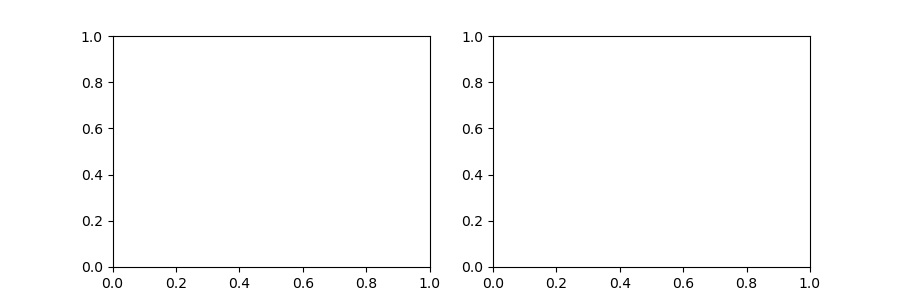

In [40]:
if "endeffector_fig" in locals():
    plt.close(endeffector_fig)
# endeffector_fig = plt.figure()
# endeffector_ax = endeffector_fig.gca()

SHOW_ANIMATION = False

plt.ion()
if not SHOW_ANIMATION:
    endeffector_fig, endeffector_ax = plt.subplots(1, 2, figsize=[9, 3])
else:
    endeffector_fig = plt.figure(figsize=[9, 9])
    endeffector_ax = []
    for i in range(1):
        endeffector_ax.append(endeffector_fig.add_subplot(1, 1, i + 1, projection='3d'))

In [ ]:
trajectories_SIMULATION.get_statistics_info()

#[trajectories_SIMULATION.position_series[i] for i in trajectories_SIMULATION.indices]

trajectories_SIMULATION.init_val, trajectories_SIMULATION.position_series_trial[0]
#trajectories_STUDY.init_val, trajectories_STUDY.position_series_trial[0]


In [133]:
for axis in endeffector_ax:
    axis.clear()
endeffector_fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9, wspace=0.26, hspace=0.2)

####
# WHICH PARTS OF DATASET? #only used if PLOTTING_ENV == "RL-UIB"
MOVEMENT_IDS = [7]
RADIUS_IDS = None
EPISODE_IDS = [3]

r1_FIXED = r1list[5]  #only used if PLOTTING_ENV == "MPC-costweights"
r2_FIXED = None #r2list[5]  #only used if PLOTTING_ENV == "MPC-costweights"

# WHAT TO COMPUTE?
EFFECTIVE_PROJECTION_PATH = (PLOTTING_ENV == "RL-UIB")  #if True, projection path connects effective initial and final position instead of nominal target center positions
MINJERK_USER_CONSTRAINTS = True

# WHICH/HOW MANY MOVS?  
"""
IMPORTANT INFO:
if isinstance(trajectories, TrajectoryData_RL):
    -> TRIAL_IDS/META_IDS/N_MOVS are (meta-)indices of respective episode (or rather, of respective row of trajectories.indices)
    -> TRIAL_IDS and META_IDS are equivalent
if isinstance(trajectories, TrajectoryData_STUDY) or isinstance(trajectories, TrajectoryData_MPC):
    -> TRIAL_IDS/META_IDS/N_MOVS are (global) indices of entire dataset
    -> TRIAL_IDS correspond to trial indices assigned during user study (last column of trajectories.indices), while META_IDS correspond to (meta-)indices of trajectories.indices itself (i.e., if some trials were removed during previous pre-processing steps, TRIAL_IDS and META_IDS differ!)
In general, only the first not-None parameter is used, in following order: TARGET_IDS, TRIAL_IDS, META_IDS, N_MOVS.
"""
TARGET_IDS = None  #corresponds to target IDs (if PLOTTING_ENV == "RL-UIB": only for iso-task)
TRIAL_IDS = [7] #[7] #corresponds to trial IDs [last column of self.indices] or relative (meta) index per row in self.indices; either a list of indices, "different_target_sizes" (choose N_MOVS conditions with maximum differences in target size), or None (use META_IDS)
META_IDS = None  #index positions (i.e., sequential numbering of trials [aggregated trials, if AGGREGATE_TRIALS==True] in indices, without counting removed outliers); if None: use N_MOVS
N_MOVS = None  #number of movements to visualize (only used, if TRIAL_IDS and META_IDS are both None (or TRIAL_IDS == "different_target_sizes"))
AGGREGATION_VARS = [] #["episode", "targetoccurrence"] #["episode", "movement"]  #["targetoccurrence"] #["episode", "movement"]  #["episode", "radius", "movement", "target", "targetoccurrence"]

# WHAT TO PLOT?
PLOT_ENDEFFECTOR = True  #if True plot End-effector position and velocity, else plot qpos and qvel for joint with index JOINT_ID (see independent_joints below)
JOINT_ID = 0  #only used if PLOT_ENDEFFECTOR == False
PLOT_DEVIATION = False  #only if PLOT_ENDEFFECTOR == True

# HOW TO PLOT?
NORMALIZE_TIME = False
PLOT_TIME_SERIES = True  #if True plot Position/Velocity/Acceleration Time Series, else plot Phasespace and Hooke plots
PLOT_VEL_ACC = False  #if True, plot Velocity and Acceleration Time Series, else plot Position and Velocity Time Series (only used if PLOT_TIME_SERIES == True)
PLOT_RANGES = False
CONF_LEVEL = "min/max"  # might be between 0 and 1, or "min/max"; only used if PLOT_RANGES==True

# WHICH BASELINE?
SHOW_MINJERK = False
SHOW_STUDY = False

# STORE PLOT?
STORE_PLOT = True

#SHOW_ANIMATION (defined above)
####    


if PLOT_RANGES:
    #assert REPEATED_MOVEMENTS, "ERROR: Check code dependencies..."
    assert PLOT_TIME_SERIES, "Plotting distributions (e.g., as CI or min/max-ranges) of Phasepace/Hooke profiles is not implemented yet."

if PLOT_DEVIATION:
    assert PLOT_TIME_SERIES, "Deviation should be plotted as Time Series, not as Phasespace/Hooke plots."
    assert PLOT_ENDEFFECTOR, "Deviation can only be plotted for end-effector projections, not for (scalar) joint angle/velocity values."

if REPEATED_MOVEMENTS:
    assert TARGET_IDS is None, "Target IDs do not exist in 'repeated movements' datasets."
    #assert PLOT_TIME_SERIES, "Plotting distributions (e.g., as CI or min/max-ranges) of Phasepace/Hooke profiles is not implemented yet."
    assert not SHOW_STUDY, "Cannot plot data from user study together with simulation data for different radii."
    
#if SHOW_MINJERK:
#    assert not SHOW_STUDY, "Cannot currently plot both minjerk and user study trajectories as reference."
    
if SHOW_STUDY:
    assert isinstance(trajectories_SIMULATION, TrajectoryData_MPC) or "iso-" in filename
    
if len(AGGREGATION_VARS) > 0:
    # This assert can be disabled.
    assert not NORMALIZE_TIME, f"NORMALIZE_TIME has no effect on the computation of distributions (mean, variability, etc.)!"


AGGREGATION_VARS_STUDY = [agg_var for agg_var in AGGREGATION_VARS if agg_var in ["targetoccurrence"]]    


# Specify plot filename
_plot_EPISODE_ID = f"E{EPISODE_IDS}_" if EPISODE_IDS is not None else ""
_plot_MOVEMENT_ID = f"M{MOVEMENT_IDS}_" if MOVEMENT_IDS is not None else ""
_plot_RADIUS_ID = f"R{RADIUS_IDS}_" if RADIUS_IDS is not None else ""

_plot_r1_FIXED = f"r_{float(r1_FIXED):.8e}_" if r1_FIXED is not None else ""  #only used if PLOTTING_ENV == "MPC-costweights"
_plot_r2_FIXED = f"r2_{float(r2_FIXED):.8e}_" if r2_FIXED is not None else ""  #only used if PLOTTING_ENV == "MPC-costweights"

_plot_JOINT_ID = "EE_" if PLOT_ENDEFFECTOR else f"{independent_joints[JOINT_ID]}_"
_plot_DEVIATION = "dev_" if PLOT_DEVIATION else ""
_plot_PHASESPACE = "PS_" if not PLOT_TIME_SERIES else ""
_plot_VEL_ACC = "velacc_" if PLOT_VEL_ACC else ""

_plot_TARGET_ID = f"T{TARGET_IDS}_" if TARGET_IDS is not None else ""
_plot_METATRIAL_ID = f"Tr{TRIAL_IDS}_" if TRIAL_IDS is not None else f"MT{META_IDS}_" if META_IDS is not None else f"MN{N_MOVS}_" if N_MOVS is not None else ""
_plot_AGGREGATE = f"AGG-{'-'.join(AGGREGATION_VARS)}_" if len(AGGREGATION_VARS) > 0 else ""
_plot_RANGE = f"{CONF_LEVEL.replace('/', '') if isinstance(CONF_LEVEL, str) else str(CONF_LEVEL) + 'CI'}_" if PLOT_RANGES else ""
_plot_EFFECTIVE_PROJECTION_PATH = "eP_" if EFFECTIVE_PROJECTION_PATH else ""
if PLOTTING_ENV == "RL-UIB":
    plot_filename_ID = f"UIB/{filename}/{_plot_EPISODE_ID}{_plot_MOVEMENT_ID}{_plot_RADIUS_ID}{_plot_JOINT_ID}{_plot_DEVIATION}{_plot_PHASESPACE}{_plot_VEL_ACC}{_plot_TARGET_ID}{_plot_METATRIAL_ID}{_plot_AGGREGATE}{_plot_RANGE}{_plot_EFFECTIVE_PROJECTION_PATH}"
elif PLOTTING_ENV == "MPC-costs":
    plot_filename_ID = f"MPC/{common_simulation_subdir}/{USER_ID}/{TASK_CONDITION}/{_plot_JOINT_ID}{_plot_DEVIATION}{_plot_PHASESPACE}{_plot_VEL_ACC}{_plot_TARGET_ID}{_plot_METATRIAL_ID}{_plot_AGGREGATE}{_plot_RANGE}{_plot_EFFECTIVE_PROJECTION_PATH}"
elif PLOTTING_ENV == "MPC-costweights":
    plot_filename_ID = f"MPC/{common_simulation_subdir}/{USER_ID}/{TASK_CONDITION}/{_plot_r1_FIXED}{_plot_r2_FIXED}{_plot_JOINT_ID}{_plot_DEVIATION}{_plot_PHASESPACE}{_plot_VEL_ACC}{_plot_TARGET_ID}{_plot_METATRIAL_ID}{_plot_AGGREGATE}{_plot_RANGE}{_plot_EFFECTIVE_PROJECTION_PATH}"
elif PLOTTING_ENV == "MPC-userstudy":
    plot_filename_ID = f"MPC/{SIMULATION_SUBDIR}/{USER_ID_FIXED}_FIXED/{TASK_CONDITION}/{_plot_JOINT_ID}{_plot_DEVIATION}{_plot_PHASESPACE}{_plot_VEL_ACC}{_plot_TARGET_ID}{_plot_METATRIAL_ID}{_plot_AGGREGATE}{_plot_RANGE}{_plot_EFFECTIVE_PROJECTION_PATH}"
else:
    raise NotImplementedError
if plot_filename_ID[-1] in ["-", "_"]:
    plot_filename_ID = plot_filename_ID[:-1]

# Define trajectory sets to plot:
if PLOTTING_ENV == "RL-UIB":
    ## RL (Aleksi)
    #if any([i is not None for i in [MOVEMENT_IDS, RADIUS_IDS, EPISODE_IDS]]):
    trajectories_SIMULATION.preprocess(MOVEMENT_IDS=MOVEMENT_IDS, RADIUS_IDS=RADIUS_IDS, EPISODE_IDS=EPISODE_IDS)
    trajectories_SIMULATION.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS)
    trajectories_SIMULATION.SHOW_MINJERK = False
    trajectories_info = [(trajectories_SIMULATION, {'linestyle': '-', 'label': 'Simulation'}, {'alpha': 0.2}, "")]  #contains tuples consisting of 1. a TrajectoryData instance, 2. a dict with plotting kwargs for regular (line) plots, 3. a dict with plotting kwargs for "fill_between" plots, and 4. a code string to execute at the beginning
    if SHOW_STUDY:
        trajectories_STUDY.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS_STUDY)
        trajectories_info.append((trajectories_STUDY, {'linestyle': ':', 'label': 'Study'}, {'alpha': 0.2}, ""))
elif PLOTTING_ENV == "MPC-costs":
    ## MPC (Markus) - Comparison of cost functions
    trajectories_SIMULATION.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS)  #MPC
    trajectories_SIMULATION2.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS)  #MPC
    trajectories_SIMULATION3.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS)  #MPC
    map_conditions = lambda x: "Joint Acceleration" if "accjoint" in x else "CTC" if "ctc" in x else "Distance and\nControl Costs" if "cso" in x else x
    trajectories_info = [(trajectories_SIMULATION, {'linestyle': '-', 'label': map_conditions(trajectories_SIMULATION.SIMULATION_SUBDIR), 'color': 'tab:blue'}, {'alpha': 0.2, }, ""), (trajectories_SIMULATION2, {'linestyle': '--', 'label': map_conditions(trajectories_SIMULATION2.SIMULATION_SUBDIR), 'color': 'tab:orange'}, {'alpha': 0.2}, ""), (trajectories_SIMULATION3, {'linestyle': '-.', 'label': map_conditions(trajectories_SIMULATION3.SIMULATION_SUBDIR), 'color': 'tab:green'}, {'alpha': 0.2}, "")]
    if SHOW_STUDY:
        trajectories_STUDY.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS_STUDY)
        trajectories_info.append((trajectories_STUDY, {'linestyle': '--', 'label': 'Study', 'color': 'black'}, {'alpha': 0.2}, ""))
elif PLOTTING_ENV == "MPC-costweights":
    #MARKUS MPC - COMPARISON OF COST WEIGHTS OF A GIVEN COST FUNCTION
    assert SHOW_STUDY == False, "Did not prepare user study data for this case."
    trajectories_WEIGHTS_selected = trajectories_WEIGHTS.copy()
    if r1_FIXED is not None:
        trajectories_WEIGHTS_selected = [i for i in trajectories_WEIGHTS_selected if f"r_{float(r1_FIXED):.8e}" in i.SIMULATION_SUBDIR]
    if r2_FIXED is not None:
        trajectories_WEIGHTS_selected = [i for i in trajectories_WEIGHTS_selected if f"r2_{float(r2_FIXED):.8e}" in i.SIMULATION_SUBDIR]
    for trajectories in trajectories_WEIGHTS_selected:
        trajectories.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS_STUDY)  #STUDY
    trajectories_info = [(trajectories, {'linestyle': '-', 'label': ", ".join(filter(None, [f"$r_1={r1_FIXED:.2g}$" if r1_FIXED is not None else "", f"$r_2={r2_FIXED:.2g}$" if r2_FIXED is not None else ""])), 'color': matplotlib.cm.get_cmap('turbo')(i/len(trajectories_WEIGHTS_selected)), 'alpha': 0.8}, {'alpha': 0.2}, "") for i, trajectories in enumerate(trajectories_WEIGHTS_selected)]
elif PLOTTING_ENV == "MPC-userstudy":
    ## MPC (Markus) - Simulation vs. User comparisons of single cost function
    trajectories_SIMULATION.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS)  #MPC
    for trajectories in [i for i in trajectories_USERS if i.USER_ID != USER_ID_FIXED]:
        trajectories.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS_STUDY)  #STUDY
    trajectories_info = [(trajectories_SIMULATION, {'linestyle': '-', 'label': 'Simulation', 'color': matplotlib.cm.get_cmap('turbo')(50)}, {'alpha': 0.2, }, "")]
    if SHOW_STUDY:
        trajectories_STUDY.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS_STUDY)
        if TARGET_IDS is None:  #between-user comparison
            trajectories_info.append((trajectories_STUDY, {'linestyle': '--', 'label': f'Baseline ({USER_ID_FIXED})', 'color': 'black'}, {'alpha': 0.2}, ""))
        else:  #within-user comparison
            trajectories_info.append((trajectories_STUDY, {'linestyle': '--', 'label': f'Study', 'color': 'black'}, {'alpha': 0.2}, ""))
    if TARGET_IDS is None:  #between-user comparison
        trajectories_info.extend([(trajectories, {'linestyle': ':', 'label': 'Other Users', 'color': matplotlib.cm.get_cmap('turbo')(180), 'alpha': 0.8}, {'alpha': 0.2}, "") for i, trajectories in enumerate(trajectories_USERS) if trajectories.USER_ID != USER_ID_FIXED])
else:
    raise NotImplementedError

if SHOW_MINJERK:
    if SHOW_STUDY:  #use user data as reference trajectory for initial and final values of MinJerk
        trajectories_STUDY.compute_minjerk(MINJERK_USER_CONSTRAINTS=MINJERK_USER_CONSTRAINTS)
        trajectories_info.append((trajectories_STUDY, {'linestyle': ':', 'label': 'MinJerk', 'color': 'black'}, {'alpha': 0.2}, "trajectories.SHOW_MINJERK = True"))
    else:
        trajectories_SIMULATION.compute_minjerk(MINJERK_USER_CONSTRAINTS=MINJERK_USER_CONSTRAINTS)
        trajectories_info.append((trajectories_SIMULATION, {'linestyle': ':', 'label': 'MinJerk'}, {'alpha': 0.2}, "trajectories.SHOW_MINJERK = True"))

## ANALYSIS OF POINTING TASKS -> Use trajectories projections onto direct path between initial and (fixed) target position
if not SHOW_ANIMATION:
    if PLOT_DEVIATION:
        endeffector_ax[0].set_title("Position Deviation from Direct Path")
        endeffector_ax[0].set_xlabel(f"Time {'[normalized]' if NORMALIZE_TIME else '(s)'}")
        endeffector_ax[0].set_ylabel("Position Deviation (m)")

        endeffector_ax[1].set_title("Velocity Deviation from Direct Path")
        endeffector_ax[1].set_xlabel(f"Time {' [normalized]' if NORMALIZE_TIME else '(s)'}")
        endeffector_ax[1].set_ylabel("Velocity Deviation (m/s)")
    else:
        if PLOT_ENDEFFECTOR:
            if PLOT_TIME_SERIES:
                if PLOT_VEL_ACC:
                    endeffector_ax[0].set_title("Projected Velocity Time Series")
                    endeffector_ax[0].set_xlabel(f"Time {'[normalized]' if NORMALIZE_TIME else '(s)'}")
                    endeffector_ax[0].set_ylabel(r"Velocity  $\left(\frac{rad}{s}\right)$ [normalized]")

                    endeffector_ax[1].set_title("Projected Acceleration Time Series")
                    endeffector_ax[1].set_xlabel(f"Time {' [normalized]' if NORMALIZE_TIME else '(s)'}")
                    endeffector_ax[1].set_ylabel(r"Acceleration  $\left(\frac{rad}{s^2}\right)$ [normalized]")
                else:
                    endeffector_ax[0].set_title("Projected Position Time Series")
                    endeffector_ax[0].set_xlabel(f"Time {'[normalized]' if NORMALIZE_TIME else '(s)'}")
                    endeffector_ax[0].set_ylabel("Position [normalized]")

                    endeffector_ax[1].set_title("Projected Velocity Time Series")
                    endeffector_ax[1].set_xlabel(f"Time {' [normalized]' if NORMALIZE_TIME else '(s)'}")
                    endeffector_ax[1].set_ylabel(r"Velocity  $\left(\frac{1}{s}\right)$ [normalized]")
            else:
                endeffector_ax[0].set_title("Projected Phasespace Plot")
                endeffector_ax[0].set_xlabel("Position [normalized]")
                endeffector_ax[0].set_ylabel("Velocity [normalized]")

                endeffector_ax[1].set_title("Projected Hooke Plot")
                endeffector_ax[1].set_xlabel("Position [normalized]")
                endeffector_ax[1].set_ylabel("Acceleration [normalized]")
        else:            
            if PLOT_TIME_SERIES:
                if PLOT_VEL_ACC:
                    endeffector_ax[0].set_title(f"Joint Velocity – {independent_joints[JOINT_ID]}")
                    endeffector_ax[0].set_xlabel(f"Time {'[normalized]' if NORMALIZE_TIME else '(s)'}")
                    endeffector_ax[0].set_ylabel(r"Joint Velocity $\left(\frac{rad}{s}\right)$")

                    endeffector_ax[1].set_title(f"Joint Velocity – {independent_joints[JOINT_ID]}")
                    endeffector_ax[1].set_xlabel(f"Time {' [normalized]' if NORMALIZE_TIME else '(s)'}")
                    endeffector_ax[1].set_ylabel(r"Joint Acceleration $\left(\frac{rad}{s^2}\right)$")
                else:
                    endeffector_ax[0].set_title(f"Joint Angle – {independent_joints[JOINT_ID]}")
                    endeffector_ax[0].set_xlabel(f"Time {'[normalized]' if NORMALIZE_TIME else '(s)'}")
                    endeffector_ax[0].set_ylabel(r"Joint Angle $\left(rad\right)$")

                    endeffector_ax[1].set_title(f"Joint Velocity – {independent_joints[JOINT_ID]}")
                    endeffector_ax[1].set_xlabel(f"Time {' [normalized]' if NORMALIZE_TIME else '(s)'}")
                    endeffector_ax[1].set_ylabel(r"Joint Velocity $\left(\frac{rad}{s}\right)$")
            else:
                endeffector_ax[0].set_title(f"{independent_joints[JOINT_ID]} – Phasespace Plot")
                endeffector_ax[0].set_xlabel(r"Joint Angle $\left(rad\right)$")
                endeffector_ax[0].set_ylabel(r"Joint Velocity $\left(\frac{rad}{s}\right)$")

                endeffector_ax[1].set_title(f"{independent_joints[JOINT_ID]} – Hooke Plot")
                endeffector_ax[1].set_xlabel(r"Joint Angle $\left(rad\right)$")
                endeffector_ax[1].set_ylabel(r"Joint Acceleration $\left(\frac{rad}{s^2}\right)$")

## ANALYSIS OF TRACKING TASKS -> Use 3D plots of trajectories
else:
    blue_line = Line2D([0], [0], color='tab:blue', linestyle='-', label='End-Effector')
    red_line = Line2D([0], [0], color='red', linestyle='-', label='Target')
    endeffector_ax[0].legend(handles=[blue_line, red_line])
    
    endeffector_ax[0].set_title("Position Trajectory")
    endeffector_ax[0].set_xlabel("x")
    endeffector_ax[0].set_ylabel("y")
    endeffector_ax[0].set_zlabel("z")
    ax_lims = np.vstack((np.min((np.squeeze(position_series).min(axis=0), np.squeeze(target_position_series).min(axis=0)), axis=0), np.max((np.squeeze(position_series).max(axis=0), np.squeeze(target_position_series).max(axis=0)), axis=0))).T
    # endeffector_ax[0].set_xlim(*ax_lims[0, :])
    # endeffector_ax[0].set_ylim(*ax_lims[1, :])
    # endeffector_ax[0].set_zlim(*ax_lims[2, :])
    ax_lims_centers, ax_lims_ranges = ax_lims.mean(axis=1), ax_lims@[-1, 1]
    endeffector_ax[0].set_xlim(ax_lims_centers[0] - 0.5*np.max(ax_lims_ranges), ax_lims_centers[0] + 0.5*np.max(ax_lims_ranges))
    endeffector_ax[0].set_ylim(ax_lims_centers[1] - 0.5*np.max(ax_lims_ranges), ax_lims_centers[1] + 0.5*np.max(ax_lims_ranges))
    endeffector_ax[0].set_zlim(ax_lims_centers[2] - 0.5*np.max(ax_lims_ranges), ax_lims_centers[2] + 0.5*np.max(ax_lims_ranges))

if not SHOW_ANIMATION:
    methods_handles = []
    
    for trajectories, trajectory_plotting_kwargs, range_plotting_kwargs, code_to_exec in trajectories_info:
        exec(code_to_exec)  #necessary to get MinJerk trajectories from RL-Simulation class
        
        #methods_handles.append(Line2D([0], [0], color="black", **{k: v for k,v in trajectory_plotting_kwargs.items() if k != "color"}))
        methods_handles.append(Line2D([0], [0], **dict({"color": "black"}, **trajectory_plotting_kwargs)))
 
        endeffector_ax[0].set_prop_cycle(None)
        endeffector_ax[1].set_prop_cycle(None)
                
        for episode_index_current, (last_idx_hlp, current_idx_hlp, next_idx_hlp) in enumerate(trajectories.selected_movements_indices):
            if isinstance(last_idx_hlp, list) and len(last_idx_hlp) > 1:  #if len(AGGREGATION_VARS) > 0
                
                trajectories.compute_statistics(episode_index_current, effective_projection_path=EFFECTIVE_PROJECTION_PATH, compute_deviation=PLOT_DEVIATION, normalize_time=NORMALIZE_TIME)
                
                if PLOT_TIME_SERIES:
                    ### POSITION (or VELOCITY) PLOT
                    latest_plot, = endeffector_ax[0].plot(trajectories.time_series_extended, (trajectories.projected_trajectories_vel_mean if PLOT_VEL_ACC else trajectories.projected_trajectories_pos_mean) if PLOT_ENDEFFECTOR else (trajectories.qvel_series_mean[:, JOINT_ID] if PLOT_VEL_ACC else trajectories.qpos_series_mean[:, JOINT_ID]), label=f'W={2*trajectories.target_radius_mean[0]:.2g}' if ("radius" not in AGGREGATION_VARS and REPEATED_MOVEMENTS) else f'T{trajectories.target_idx_mean[0]}' if not np.isnan(trajectories.target_idx_mean).all() else None, **{k: v for k,v in trajectory_plotting_kwargs.items() if k != "label"})
                    
                    if PLOT_RANGES:
                        if CONF_LEVEL == "min/max":
                            # add min/max bounds
                            endeffector_ax[0].fill_between(trajectories.time_series_extended, (trajectories.projected_trajectories_vel_min if PLOT_VEL_ACC else trajectories.projected_trajectories_pos_min) if PLOT_ENDEFFECTOR else (trajectories.qvel_series_min[:, JOINT_ID] if PLOT_VEL_ACC else trajectories.qpos_series_min[:, JOINT_ID]), (trajectories.projected_trajectories_vel_max if PLOT_VEL_ACC else trajectories.projected_trajectories_pos_max) if PLOT_ENDEFFECTOR else (trajectories.qvel_series_max[:, JOINT_ID] if PLOT_VEL_ACC else trajectories.qpos_series_max[:, JOINT_ID]), color=latest_plot.get_color(), **{k: v for k,v in range_plotting_kwargs.items() if k != "color"})
                        else:
                            # add confidence interval bounds
                            if PLOT_DEVIATION:
                                raise NotImplementedError("ERROR: Not sure if it makes sense to plot difference between projected standard deviation and direct path...")
                            if PLOT_VEL_ACC:
                                projected_or_joint_trajectories_pos_or_vel_std =  np.sqrt(trajectories.projected_trajectories_vel_cov if PLOT_ENDEFFECTOR else trajectories.qvel_series_cov[:, JOINT_ID])
                            else:
                                projected_or_joint_trajectories_pos_or_vel_std =  np.sqrt(trajectories.projected_trajectories_pos_cov if PLOT_ENDEFFECTOR else trajectories.qpos_series_cov[:, JOINT_ID])
                            endeffector_ax[0].fill_between(trajectories.time_series_extended, ((trajectories.projected_trajectories_vel_mean if PLOT_VEL_ACC else trajectories.projected_trajectories_pos_mean) if PLOT_ENDEFFECTOR else (trajectories.qvel_series_mean[:, JOINT_ID] if PLOT_VEL_ACC else trajectories.qpos_series_mean[:, JOINT_ID])) - stats.norm.ppf((CONF_LEVEL + 1)/2) * projected_or_joint_trajectories_pos_or_vel_std, ((trajectories.projected_trajectories_vel_mean if PLOT_VEL_ACC else trajectories.projected_trajectories_pos_mean) if PLOT_ENDEFFECTOR else (trajectories.qvel_series_mean[:, JOINT_ID] if PLOT_VEL_ACC else trajectories.qpos_series_mean[:, JOINT_ID])) + stats.norm.ppf((CONF_LEVEL + 1)/2) * projected_or_joint_trajectories_pos_or_vel_std, color=latest_plot.get_color(), **{k: v for k,v in range_plotting_kwargs.items() if k != "color"})

                        # display lower bound of target area (i.e., target center - target radius) in projected position plot
                        if (not PLOT_DEVIATION) and PLOT_ENDEFFECTOR:
                            #TODO: modify init_val, final_val!
                            target_radius_normalized = trajectories.target_radius_mean[0]/np.linalg.norm(trajectories.final_val-trajectories.init_val)   #relative (i.e., normalized) target radius
                            target_area_boundary_projected = 1 - target_radius_normalized
                            endeffector_ax[0].axhline(target_area_boundary_projected, linestyle='--', color=latest_plot.get_color(), alpha=.2)

                    ### VELOCITY (or ACCELERATION) PLOT
                    latest_plot, = endeffector_ax[1].plot(trajectories.time_series_extended, (trajectories.projected_trajectories_acc_mean if PLOT_VEL_ACC else trajectories.projected_trajectories_vel_mean) if PLOT_ENDEFFECTOR else (trajectories.qacc_series_mean[:, JOINT_ID] if PLOT_VEL_ACC else trajectories.qvel_series_mean[:, JOINT_ID]), label=f'W={2*trajectories.target_radius_mean[0]:.2g}' if ("radius" not in AGGREGATION_VARS and REPEATED_MOVEMENTS) else f'T{trajectories.target_idx_mean[0]}' if not np.isnan(trajectories.target_idx_mean).all() else None, **{k: v for k,v in trajectory_plotting_kwargs.items() if k != "label"})
                    
                    if PLOT_RANGES:
                        if CONF_LEVEL == "min/max":
                            # add min/max bounds
                            endeffector_ax[1].fill_between(trajectories.time_series_extended, (trajectories.projected_trajectories_acc_min if PLOT_VEL_ACC else trajectories.projected_trajectories_vel_min) if PLOT_ENDEFFECTOR else (trajectories.qacc_series_min[:, JOINT_ID] if PLOT_VEL_ACC else trajectories.qvel_series_min[:, JOINT_ID]), (trajectories.projected_trajectories_acc_max if PLOT_VEL_ACC else trajectories.projected_trajectories_vel_max) if PLOT_ENDEFFECTOR else (trajectories.qacc_series_max[:, JOINT_ID] if PLOT_VEL_ACC else trajectories.qvel_series_max[:, JOINT_ID]), color=latest_plot.get_color(), **{k: v for k,v in range_plotting_kwargs.items() if k != "color"})
                        else:
                            # add confidence interval bounds
                            if PLOT_VEL_ACC:
                                projected_or_joint_trajectories_vel_or_acc_std =  np.sqrt(trajectories.projected_trajectories_acc_cov if PLOT_ENDEFFECTOR else trajectories.qacc_series_cov[:, JOINT_ID])
                            else:
                                projected_or_joint_trajectories_vel_or_acc_std =  np.sqrt(trajectories.projected_trajectories_vel_cov if PLOT_ENDEFFECTOR else trajectories.qvel_series_cov[:, JOINT_ID])
                            endeffector_ax[1].fill_between(trajectories.time_series_extended, ((trajectories.projected_trajectories_acc_mean if PLOT_VEL_ACC else trajectories.projected_trajectories_vel_mean) if PLOT_ENDEFFECTOR else (trajectories.qacc_series_mean[:, JOINT_ID] if PLOT_VEL_ACC else trajectories.qvel_series_mean[:, JOINT_ID])) - stats.norm.ppf((CONF_LEVEL + 1)/2) * projected_or_joint_trajectories_vel_or_acc_std, ((trajectories.projected_trajectories_acc_mean if PLOT_VEL_ACC else trajectories.projected_trajectories_vel_mean) if PLOT_ENDEFFECTOR else (trajectories.qacc_series_mean[:, JOINT_ID] if PLOT_VEL_ACC else trajectories.qvel_series_mean[:, JOINT_ID])) + stats.norm.ppf((CONF_LEVEL + 1)/2) * projected_or_joint_trajectories_vel_or_acc_std, color=latest_plot.get_color(), **{k: v for k,v in range_plotting_kwargs.items() if k != "color"})
                else:
                    ### PHASESPACE PLOT
                    latest_plot, = endeffector_ax[0].plot(trajectories.projected_trajectories_pos_mean if PLOT_ENDEFFECTOR else trajectories.qpos_series_mean[:, JOINT_ID], trajectories.projected_trajectories_vel_mean if PLOT_ENDEFFECTOR else trajectories.qvel_series_mean[:, JOINT_ID], label=f'W={2*trajectories.target_radius_mean[0]:.2g}' if ("radius" not in AGGREGATION_VARS and REPEATED_MOVEMENTS) else f'T{trajectories.target_idx_mean[0]}' if not np.isnan(trajectories.target_idx_mean).all() else None, **{k: v for k,v in trajectory_plotting_kwargs.items() if k != "label"})

                    if PLOT_RANGES:
                        raise NotImplementedError("""Can show distribution of aggregated trials only if PLOT_TIME_SERIES == True.""")

                    ### HOOKE PLOT
                    latest_plot, = endeffector_ax[1].plot(trajectories.projected_trajectories_pos_mean if PLOT_ENDEFFECTOR else trajectories.qpos_series_mean[:, JOINT_ID], trajectories.projected_trajectories_acc_mean if PLOT_ENDEFFECTOR else trajectories.qacc_series_mean[:, JOINT_ID], label=f'W={2*trajectories.target_radius_mean[0]:.2g}' if ("radius" not in AGGREGATION_VARS and REPEATED_MOVEMENTS) else f'T{trajectories.target_idx_mean[0]}' if not np.isnan(trajectories.target_idx_mean).all() else None, **{k: v for k,v in trajectory_plotting_kwargs.items() if k != "label"})

                    if PLOT_RANGES:
                        raise NotImplementedError("""Can show distribution of aggregated trials only if PLOT_TIME_SERIES == True.""")

            else:
                assert not PLOT_RANGES, "ERROR: Cannot plot ranges, as no trials were aggregated!"
                
                trajectories.compute_trial(episode_index_current, effective_projection_path=EFFECTIVE_PROJECTION_PATH, compute_deviation=PLOT_DEVIATION, normalize_time=NORMALIZE_TIME)
                projected_or_joint_trajectory_pos = trajectories.projected_trajectories_pos_trial if PLOT_ENDEFFECTOR else trajectories.qpos_series_trial[:, JOINT_ID]
                projected_or_joint_trajectory_vel = trajectories.projected_trajectories_vel_trial if PLOT_ENDEFFECTOR else trajectories.qvel_series_trial[:, JOINT_ID]
                projected_or_joint_trajectory_acc = trajectories.projected_trajectories_acc_trial if PLOT_ENDEFFECTOR else trajectories.qacc_series_trial[:, JOINT_ID]

                ## for interchangeability between projection and covariance, see https://math.stackexchange.com/a/2576783
                if PLOT_TIME_SERIES:
                    ### POSITION (or VELOCITY) PLOT
                    latest_plot, = endeffector_ax[0].plot(trajectories.time_series_trial, projected_or_joint_trajectory_vel if PLOT_VEL_ACC else projected_or_joint_trajectory_pos, label=f'W={2*trajectories.target_radius_series_trial[0]:.2g}' if ("radius" not in AGGREGATION_VARS and REPEATED_MOVEMENTS) else f'T{trajectories.target_idx_series_trial[0]}' if not np.isnan(trajectories.target_idx_series).all() else None, **{k: v for k,v in trajectory_plotting_kwargs.items() if k != "label"})
                    
                    ### VELOCITY (or ACCELERATION) PLOT
                    latest_plot, = endeffector_ax[1].plot(trajectories.time_series_trial, projected_or_joint_trajectory_acc if PLOT_VEL_ACC else projected_or_joint_trajectory_vel, label=f'W={2*trajectories.target_radius_series_trial[0]:.2g}' if ("radius" not in AGGREGATION_VARS and REPEATED_MOVEMENTS) else f'T{trajectories.target_idx_series_trial[0]}' if not np.isnan(trajectories.target_idx_series).all() else None, **{k: v for k,v in trajectory_plotting_kwargs.items() if k != "label"})

                else:
                    ### PHASESPACE PLOT
                    latest_plot, = endeffector_ax[0].plot(projected_or_joint_trajectory_pos, projected_or_joint_trajectory_vel, label=f'W={2*trajectories.target_radius_series_trial[0]:.2g}' if ("radius" not in AGGREGATION_VARS and REPEATED_MOVEMENTS) else f'T{trajectories.target_idx_series_trial[0]}' if not np.isnan(trajectories.target_idx_series).all() else None, **{k: v for k,v in trajectory_plotting_kwargs.items() if k != "label"})

                    ### HOOKE PLOT
                    latest_plot, = endeffector_ax[1].plot(projected_or_joint_trajectory_pos, projected_or_joint_trajectory_acc, label=f'W={2*trajectories.target_radius_series_trial[0]:.2g}' if ("radius" not in AGGREGATION_VARS and REPEATED_MOVEMENTS) else f'T{trajectories.target_idx_series_trial[0]}' if not np.isnan(trajectories.target_idx_series).all() else None, **{k: v for k,v in trajectory_plotting_kwargs.items() if k != "label"})
        
    #reset to show regular (study) trajectories first
    for trajectories_info_current in trajectories_info:
        trajectories_info_current[0].SHOW_MINJERK = False

    #if SHOW_DIFFERENT_TARGET_SIZES or ("radius" not in AGGREGATION_VARS and REPEATED_MOVEMENTS) or "target_idx" in (list(trajectories_SIMULATION.data.values())[0].keys() if isinstance(trajectories_SIMULATION.data, dict) else trajectories_SIMULATION.data.columns):
        # axis 0 legend
    confidence_interval_handle = Patch(facecolor='grey', alpha=.2, label='Range' if CONF_LEVEL == "min/max" else f'{100*CONF_LEVEL}%-CI')

    # if SHOW_MINJERK:
    #     endeffector_ax[0].legend(handles=[solid_line, dashed_line])
    # elif SHOW_STUDY:
    #     endeffector_ax[0].legend(handles=[solid_line, dashdotted_line])
    # else:
    #     endeffector_ax[0].legend(handles=[solid_line])

    handles, labels = endeffector_ax[0].get_legend_handles_labels()
    
    # remove duplicate entries
    handles = [handle for idx, (handle, label) in enumerate(zip(handles, labels)) if labels.index(label) == idx]
    labels = [label for idx, label in enumerate(labels) if labels.index(label) == idx]
    methods_handles = [handle for idx, handle in enumerate(methods_handles) if [i.get_label() for i in methods_handles].index(handle.get_label()) == idx]
    
    if PLOT_RANGES: #if len(AGGREGATION_VARS) > 0:  # if len(last_idx_hlp) > 1
        handles.insert(0, confidence_interval_handle)
    # if (REPEATED_MOVEMENTS and ("radius" not in AGGREGATION_VARS)):  #ignore handle for dashed MinJerk trajectory, as this is not shown in this case
    #     endeffector_ax[0].legend(handles=handles)
    # elif SHOW_MINJERK:
    #     endeffector_ax[0].legend(handles=[solid_line, dashed_line]+handles)
    # elif SHOW_STUDY:
    #     endeffector_ax[0].legend(handles=[solid_line, dashdotted_line]+handles)
    # else:
    #     endeffector_ax[0].legend(handles=handles)
    if len(methods_handles) == 1 and PLOTTING_ENV != "MPC-costweights":
        methods_handles = []
    if "color" in trajectory_plotting_kwargs and len(handles) == 1:
        endeffector_ax[0].legend(handles=methods_handles)
    else:
        endeffector_ax[0].legend(handles=methods_handles+handles)

    # axis 1 legend
    handles, labels = endeffector_ax[1].get_legend_handles_labels()
    
    # remove duplicate entries
    handles = [handle for idx, (handle, label) in enumerate(zip(handles, labels)) if labels.index(label) == idx]
    labels = [label for idx, label in enumerate(labels) if labels.index(label) == idx]
    
    if len(AGGREGATION_VARS) > 0:  # if len(last_idx_hlp) > 1
        handles.insert(0, confidence_interval_handle)
    if not (("color" in trajectory_plotting_kwargs and len(handles) == 1) or len(handles) == 0):
        endeffector_ax[1].legend(handles=handles)
        
    # if REPEATED_MOVEMENTS: 
    #     endeffector_fig.savefig(f"plots/{filename}/proj_{trajectories_SIMULATION.data_key}.png", dpi=120)
    # else:
    #     endeffector_fig.savefig(f"plots/{filename}/proj_movements_vs_minjerk.png", dpi=120)
    if STORE_PLOT:
        endeffector_fig.savefig(f"/home/florian/reacher_sg/_plots/{plot_filename_ID}.png", dpi=300)
else:
    plt.ioff()

    assert len(trajectories.position_series) == len(trajectories.target_position_series)
    
    position_series = np.squeeze(trajectories.position_series)
    target_position_series = np.squeeze(trajectories.target_position_series)
    target_radius_series = np.squeeze(trajectories.target_radius_series)
    
    target_radius = trajectories.target_radius_series[0]
    
    def drawSphere(xCenter, yCenter, zCenter, r):
        #draw sphere
        u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
        x=np.cos(u)*np.sin(v)
        y=np.sin(u)*np.sin(v)
        z=np.cos(v)
        # shift and scale sphere
        x = r*x + xCenter
        y = r*y + yCenter
        z = r*z + zCenter
        return (x,y,z)
        
    endeffector_path, = endeffector_ax[0].plot([], [], [], lw=1)
    target_path, = endeffector_ax[0].plot([], [], [], lw=1, color="red")
    #target_sphere = endeffector_ax[0].plot_surface([], [], [], color="red")
    
    target_spheres = []
        
    def update(i, timeframes_skip):
        current_idx = trajectories.indices[np.where(trajectories.indices <= i)[0][-1]]  #update target after each movement (only for pointing tasks)
        
        # in pointing tasks with constant target, targets only need to be updated at indices
        if (i - current_idx in np.arange(timeframes_skip)) or ("tracking" in filepath):            
            target_sphere_x, target_sphere_y, target_sphere_z = drawSphere(*target_position_series[i, :], target_radius)
            if len(target_spheres) == 1:
                target_spheres[-1].remove()
                target_spheres.pop(-1)
            target_spheres.append(endeffector_ax[0].plot_wireframe(target_sphere_x, target_sphere_y, target_sphere_z, color="red", alpha=0.2))
        
        target_path.set_data(target_position_series[current_idx + 1:i, :2].T)
        target_path.set_3d_properties(target_position_series[current_idx + 1:i, 2])
        
        endeffector_path.set_data(position_series[current_idx:i, :2].T)
        endeffector_path.set_3d_properties(position_series[current_idx:i, 2])

        return
    
    timeframes_skip = np.round(1/trajectories.time_per_step/50).astype(np.int64)
    ani = animation.FuncAnimation(endeffector_fig, update, np.concatenate(list(np.arange(selected_movements_index[1], selected_movements_index[2])[::timeframes_skip] for selected_movements_index in trajectories.selected_movements_indices)), fargs=(timeframes_skip,)) #, interval=time_per_step*1000)
    if STORE_PLOT:
        ani.save(f"/home/florian/reacher_sg/_plots/{'tracking' if 'tracking' in filepath else 'pointing'}_paths/{plot_filename_ID}.gif", dpi=120, writer="pillow", fps=50)  #warning: GIFs only allow for 50fps (100fps rendering is practically not possible...)
    
    #plt.ion()

In [163]:
trajectories_SIMULATION._target_idx_trials_meta_indices

test = np.squeeze(np.vstack([list(zip(np.concatenate(([-1], idx)), idx, idx[1:])) for idx in trajectories_SIMULATION._indices]))
preselection_include_target_ids = lambda target_id: target_id in trajectories_SIMULATION.TARGET_IDS if trajectories_SIMULATION.TARGET_IDS is not None else True
preselection_include_trials = lambda k: (k in trajectories_SIMULATION.TRIAL_IDS) if trajectories_SIMULATION.TRIAL_IDS is not None else (k in trajectories_SIMULATION.META_IDS) if trajectories_SIMULATION.META_IDS is not None else (k in range(trajectories_SIMULATION.N_MOVS)) if trajectories_SIMULATION.N_MOVS is not None else True

#test2 = [test[np.where([all([getattr(trajectories_SIMULATION, f"_{agg_var}_idx_trials")[k] == i[j] for j, agg_var in enumerate(trajectories_SIMULATION.AGGREGATION_VARS)] + [preselection_include_target_ids(trajectories_SIMULATION._target_idx_trials[k])] + [preselection_include_trials(trajectories_SIMULATION._target_idx_trials_meta_indices[k])]) for k in range(len(test))])[0]].tolist() for i in itertools.product(*[np.unique(getattr(trajectories_SIMULATION, f"_{agg_var}_idx_trials")) for agg_var in trajectories_SIMULATION.AGGREGATION_VARS])]
#test2

([preselection_include_trials(trajectories_SIMULATION._target_idx_trials_meta_indices[k]) for k in range(len(test))])
([preselection_include_target_ids(trajectories_SIMULATION._target_idx_trials[k]) for k in range(len(test))])
trajectories_SIMULATION.indices.shape

(50, 15)

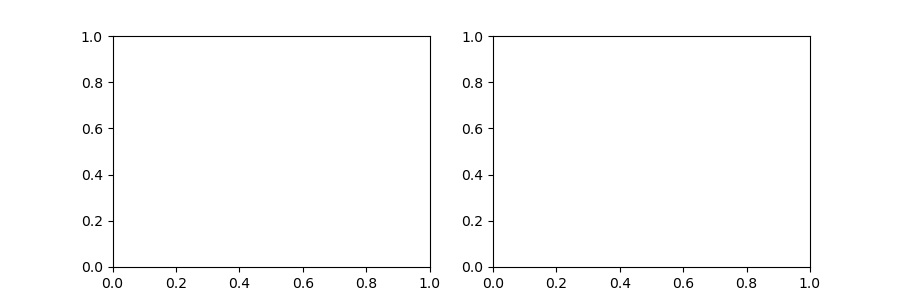

In [419]:
if "action_fig" in locals():
    plt.close(action_fig)
# action_fig = plt.figure()
# action_ax = action_fig.gca()

plt.ion()
action_fig, action_ax = plt.subplots(1, 2, figsize=[9, 3])

In [426]:
"""
WARNING: This cell needs to be executed in combination with "endeffector_fig" cell above, as simulation data is only pre-processed above!
"""

for axis in action_ax:
    axis.clear()
action_fig.subplots_adjust(left=0.1, right=0.95, bottom=0.17, top=0.9, wspace=0.26, hspace=0.2)

####
## INFO: uses TrajectoryData classes defined above

# WHICH PARTS OF DATASET?
MOVEMENT_IDS = None
RADIUS_IDS = None
EPISODE_IDS = None

# WHICH/HOW MANY MOVS?
TARGET_IDS = [2]  #corresponds to target IDs (if PLOTTING_ENV == "RL-UIB": only for iso-task)
TRIAL_IDS = None  #corresponds to target IDs if AGGREGATE_TRIALS==True, else Trial ID [last column of self.indices]; either a list of indices, "different_target_sizes" (choose N_MOVS conditions with maximum differences in target size), or None (use META_IDS)
META_IDS = None  #index positions (i.e., sequential numbering of trials [aggregated trials, if AGGREGATE_TRIALS==True] in indices, without counting removed outliers); if None: use N_MOVS
N_MOVS = None #number of movements to take into account (only used, if TRIAL_IDS and META_IDS are both None (or TRIAL_IDS == "different_target_sizes"))
AGGREGATION_VARS = [] #"episode", "targetoccurrence"] #["episode", "targetoccurrence"] #["episode", "movement"]  #["targetoccurrence"] #["episode", "movement"]  #["episode", "radius", "movement", "target", "targetoccurrence"]

# REMOVE FAILED TRIALS/OUTLIERS?   #only if SHOW_AGGREGATED_RECRUITMENTS == True
#REMOVE_FAILED = True  #TODO
REMOVE_OUTLIERS = False

# WHAT TO PLOT?
SHOW_AGGREGATED_RECRUITMENTS = True  #if True, show boxplot with aggregated muscle recruitments for each muscle; otherwise, show control series of ACTUATOR_ID and reward series
ACTUATOR_ID = 12 #index of actuator to plot (only if SHOW_AGGREGATED_RECRUITMENTS == False)

# HOW TO PLOT?  #only if SHOW_AGGREGATED_RECRUITMENTS == False
NORMALIZE_TIME = False
PLOT_RANGES = True
CONF_LEVEL = "min/max"  # might be between 0 and 1, or "min/max"; only used if PLOT_RANGES==True

# WHICH BASELINE?
SHOW_STUDY = True  #if True, show control values from study as comparison (only if SHOW_AGGREGATED_RECRUITMENTS == False)

# STORE PLOT?
STORE_PLOT = False
####

if len(AGGREGATION_VARS) > 0 and not SHOW_AGGREGATED_RECRUITMENTS:
    # This assert can be disabled.
    assert not NORMALIZE_TIME, f"NORMALIZE_TIME has no effect on the computation of distributions (mean, variability, etc.)!"

AGGREGATION_VARS_STUDY = [agg_var for agg_var in AGGREGATION_VARS if agg_var in ["targetoccurrence"]]

# Specify plot filename
_plot_EPISODE_ID = f"E{EPISODE_IDS}_" if EPISODE_IDS is not None else ""
_plot_MOVEMENT_ID = f"M{MOVEMENT_IDS}_" if MOVEMENT_IDS is not None else ""
_plot_RADIUS_ID = f"R{RADIUS_IDS}_" if RADIUS_IDS is not None else ""

_plot_ACTUATOR_ID = "MuscleRecruitment_" if SHOW_AGGREGATED_RECRUITMENTS else f"{actuator_names[ACTUATOR_ID]}_"

_plot_TARGET_ID = f"T{TARGET_IDS}_" if TARGET_IDS is not None else ""
_plot_METATRIAL_ID = f"Tr{TRIAL_IDS}_" if TRIAL_IDS is not None else f"MT{META_IDS}_" if META_IDS is not None else f"MN{N_MOVS}_" if N_MOVS is not None else ""
_plot_AGGREGATE = f"AGG-{'-'.join(AGGREGATION_VARS)}_" if len(AGGREGATION_VARS) > 0 else ""
_plot_RANGE = f"{CONF_LEVEL.replace('/', '') if isinstance(CONF_LEVEL, str) else str(CONF_LEVEL) + 'CI'}_" if PLOT_RANGES and not SHOW_AGGREGATED_RECRUITMENTS else ""

_plot_REMOVE_OUTLIERS = 'rO_' if REMOVE_OUTLIERS else ''
if PLOTTING_ENV == "RL-UIB":
    plot_action_filename_ID = f"UIB/{filename}/{_plot_EPISODE_ID}{_plot_MOVEMENT_ID}{_plot_RADIUS_ID}{_plot_ACTUATOR_ID}{_plot_TARGET_ID}{_plot_METATRIAL_ID}{_plot_AGGREGATE}{_plot_RANGE}{_plot_REMOVE_OUTLIERS}"
# elif PLOTTING_ENV == "MPC-costs":
#     plot_action_filename_ID = f"MPC/{common_simulation_subdir}/{USER_ID}/{TASK_CONDITION}/{_plot_JOINT_ID}{_plot_DEVIATION}{_plot_PHASESPACE}{_plot_VEL_ACC}{_plot_TARGET_ID}{_plot_METATRIAL_ID}{_plot_AGGREGATE}{_plot_RANGE}{_plot_EFFECTIVE_PROJECTION_PATH}"
# elif PLOTTING_ENV == "MPC-userstudy":
#     plot_action_filename_ID = f"MPC/{SIMULATION_SUBDIR}/{USER_ID_FIXED}_FIXED/{TASK_CONDITION}/{_plot_JOINT_ID}{_plot_DEVIATION}{_plot_PHASESPACE}{_plot_VEL_ACC}{_plot_TARGET_ID}{_plot_METATRIAL_ID}{_plot_AGGREGATE}{_plot_RANGE}{_plot_EFFECTIVE_PROJECTION_PATH}"
else:
    raise NotImplementedError
if plot_action_filename_ID[-1] in ["-", "_"]:
    plot_action_filename_ID = plot_action_filename_ID[:-1]


trajectories_SIMULATION.preprocess(MOVEMENT_IDS=MOVEMENT_IDS, RADIUS_IDS=RADIUS_IDS, EPISODE_IDS=EPISODE_IDS)
trajectories_SIMULATION.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS)
trajectories_SIMULATION.SHOW_MINJERK = False
trajectories_STUDY.compute_indices(TARGET_IDS=TARGET_IDS, TRIAL_IDS=TRIAL_IDS, META_IDS=META_IDS, N_MOVS=N_MOVS, AGGREGATION_VARS=AGGREGATION_VARS_STUDY)
trajectories_actioninfo = [(trajectories_SIMULATION, {'linestyle': '-', 'label': 'Simulation'}, {'alpha': 0.2}), (trajectories_STUDY, {'linestyle': ':', 'label': 'Study'}, {'alpha': 0.2})]  #contains tuples consisting of 1. a TrajectoryData instance, 2. a dict with plotting kwargs for action plots, and 3. a dict with plotting kwargs for "fill_between" plots

if SHOW_AGGREGATED_RECRUITMENTS:
    assert AGGREGATION_VARS == []
    assert AGGREGATION_VARS_STUDY == []
        
    for axes_id, (trajectories, trajectory_plotting_kwargs, range_plotting_kwargs) in enumerate(trajectories_actioninfo):
        # Aggregated muscle recruitment plot (with noise)
        selected_movements_indices = trajectories.selected_movements_indices.copy()
        #movement_indices_TO_DELETE = np.where(np.array(MT_list) >= MAX_TIME - DWELL_TIME - 1e-6)[0].tolist()
        if isinstance(trajectories.control_series, list):
            aggregated_recruitments_controls = {actuator_name: [np.trapz(trajectories.control_series[meta_id][current_idx: next_idx, actuator_idx], x=trajectories.time_series[meta_id][current_idx: next_idx]) for meta_id, indices_current_radius in enumerate(trajectories.indices) for last_idx, current_idx, next_idx in trajectories.selected_movements_indices] for actuator_idx, actuator_name in enumerate(actuator_names)}
        else:
            aggregated_recruitments_controls = {actuator_name: [np.trapz(trajectories.control_series[(current_idx[0] if type(current_idx) == list else current_idx): (next_idx[0] if type(next_idx) == list else next_idx), actuator_idx], x=trajectories.time_series[(current_idx[0] if type(current_idx) == list else current_idx): (next_idx[0] if type(next_idx) == list else next_idx)]) for last_idx, current_idx, next_idx in trajectories.selected_movements_indices] for actuator_idx, actuator_name in enumerate(actuator_names)} #if (last_idx_hlp := (last_idx[0] if isinstance(last_idx, list) and len(last_idx) == 1 else last_idx)) is not None if (current_idx_hlp := (current_idx[0] if isinstance(current_idx, list) and len(current_idx) == 1 else current_idx)) is not None if ((next_idx_hlp := next_idx[0] if isinstance(next_idx, list) and len(next_idx) == 1 else next_idx)) is not None}
        
        if REMOVE_OUTLIERS:
            sample_indices_TO_DELETE = []
            for k, v in aggregated_recruitments_controls.items():
                sample_indices_TO_DELETE.extend(np.where(np.abs(stats.zscore(v)) > 3)[0].tolist())
            if len(sample_indices_TO_DELETE) > 0:
                print(f"{trajectory_plotting_kwargs['label']} - Removed {len(sample_indices_TO_DELETE)} outlier trials.")
            for k, v in aggregated_recruitments_controls.items():
                aggregated_recruitments_controls[k] = [i for idx, i in enumerate(v) if idx not in sample_indices_TO_DELETE]

        #action_ax[axes_id].boxplot(aggregated_recruitments_controls.values(), labels=aggregated_recruitments_controls.keys())
        sns.boxplot(data=pd.DataFrame(aggregated_recruitments_controls), ax=action_ax[axes_id])#, labels=aggregated_recruitments_controls.keys())
        
        action_ax[axes_id].set_xticklabels(aggregated_recruitments_controls.keys(), rotation=90, fontsize=6)
        action_ax[axes_id].set_title(f"Aggregated Muscle Recruitment ({trajectory_plotting_kwargs['label']})")
        #action_ax[axes_id].set_xlabel("Muscle")
        action_ax[axes_id].set_ylabel("Sum of Muscle Control Values")
    
#     if not SHOW_STUDY:
#         # Aggregated muscle recruitment plot (without noise)
#         if isinstance(trajectories.action_series, list):
#             aggregated_recruitments_actions = {actuator_name: [np.trapz(trajectories.action_series[meta_id][current_idx: next_idx, actuator_idx], x=trajectories.time_series[meta_id][current_idx: next_idx]) for meta_id, indices_current_radius in enumerate(trajectories.indices) for last_idx, current_idx, next_idx in list(zip(np.concatenate(([-1], indices_current_radius[:-1])), indices_current_radius, indices_current_radius[1:]))] for actuator_idx, actuator_name in enumerate(actuator_names)}
#         else:
#             aggregated_recruitments_actions = {actuator_name: [np.trapz(trajectories.action_series[current_idx: next_idx, actuator_idx], x=trajectories.time_series[current_idx: next_idx]) for last_idx, current_idx, next_idx in list(zip(np.concatenate(([-1], trajectories.indices[:-1])), trajectories.indices, trajectories.indices[1:]))] for actuator_idx, actuator_name in enumerate(actuator_names)}        
#         #action_ax[0].boxplot(aggregated_recruitments_actions.values(), labels=aggregated_recruitments_actions.keys())
#         sns.boxplot(data=pd.DataFrame(aggregated_recruitments_actions), ax=action_ax[1])#, labels=aggregated_recruitments_actions.keys())

#         action_ax[1].set_xticklabels(aggregated_recruitments_actions.keys(), rotation=90, fontsize=6)
#         action_ax[1].set_title("Aggregated Muscle Recruitment")
#         #action_ax[1].set_xlabel("Muscle")
#         action_ax[1].set_ylabel("Sum of Muscle Action Values")

    #action_ax[0].legend()
    #action_ax[1].legend()
    
    #action_fig.savefig(f"plots/{filename}/aggregated_muscle_{trajectories_SIMULATION.data_key}.png", dpi=120)
else:
    ## ANALYSIS OF POINTING TASKS -> Plot controls and rewards
    #solid_line = Line2D([0], [0], color='black', linestyle='-', label='Actions')
    #dashed_line = Line2D([0], [0], color='black', linestyle='--', label='Controls')
    #action_ax[0].legend(handles=[solid_line, dashed_line])
    methods_handles_ax0 = []
    methods_handles_ax1 = []

    action_ax[0].set_title(f"Control Time Series – {actuator_names[ACTUATOR_ID]}")
    action_ax[0].set_xlabel(f"Time {'[normalized]' if NORMALIZE_TIME else '(s)'}")
    action_ax[0].set_ylabel("Control [normalized]")

    action_ax[1].set_title("Reward Time Series")
    action_ax[1].set_xlabel(f"Time {'[normalized]' if NORMALIZE_TIME else '(s)'}")
    action_ax[1].set_ylabel("Reward")
    action_ax[1].set_yscale("symlog")

    for axes_id, (trajectories, trajectory_plotting_kwargs, range_plotting_kwargs) in enumerate(trajectories_actioninfo):
        methods_handles_ax0.append(Line2D([0], [0], color="black", **{k: v for k,v in trajectory_plotting_kwargs.items() if k != "color"}))
        if hasattr(trajectories, "_reward_series"):
            methods_handles_ax1.append(Line2D([0], [0], color="black", **{k: v for k,v in trajectory_plotting_kwargs.items() if k != "color"}))
        
        for episode_index_current, (last_idx, current_idx, next_idx) in enumerate(trajectories.selected_movements_indices):
            if isinstance(last_idx, list) and len(last_idx) > 1:  #if len(AGGREGATION_VARS) > 0
                trajectories.compute_action_statistics(episode_index_current, normalize_time=NORMALIZE_TIME)
                
                ### CONTROLS
                latest_plot, = action_ax[0].plot(trajectories.action_stats_time_series_extended, trajectories.control_series_mean[:, ACTUATOR_ID], **trajectory_plotting_kwargs)
                if PLOT_RANGES:
                    if CONF_LEVEL == "min/max":
                        # add min/max bounds
                        action_ax[0].fill_between(trajectories.action_stats_time_series_extended, trajectories.control_series_min[:, ACTUATOR_ID], trajectories.control_series_max[:, ACTUATOR_ID], color=latest_plot.get_color(), **{k: v for k,v in range_plotting_kwargs.items() if k != "color"})
                    else:
                        # add confidence interval bounds
                        control_series_std =  np.sqrt(trajectories.control_series_cov[:, ACTUATOR_ID])
                        action_ax[0].fill_between(trajectories.action_stats_time_series_extended, trajectories.control_series_mean[:, ACTUATOR_ID] - stats.norm.ppf((CONF_LEVEL + 1)/2) * control_series_std, trajectories.control_series_mean[:, ACTUATOR_ID] + stats.norm.ppf((CONF_LEVEL + 1)/2) * control_series_std, color=latest_plot.get_color(), **{k: v for k,v in range_plotting_kwargs.items() if k != "color"})
                
                ### REWARD
                if hasattr(trajectories, "_reward_series"):
                    latest_plot, = action_ax[1].plot(trajectories.action_stats_time_series_extended, trajectories.reward_series_mean, **trajectory_plotting_kwargs)
                    if PLOT_RANGES:
                        if CONF_LEVEL == "min/max":
                            # add min/max bounds
                            action_ax[1].fill_between(trajectories.action_stats_time_series_extended, trajectories.reward_series_min, trajectories.reward_series_max, color=latest_plot.get_color(), **{k: v for k,v in range_plotting_kwargs.items() if k != "color"})
                        else:
                            # add confidence interval bounds
                            reward_series_std =  np.sqrt(trajectories.reward_series_cov)
                            action_ax[1].fill_between(trajectories.action_stats_time_series_extended, trajectories.reward_series_mean - stats.norm.ppf((CONF_LEVEL + 1)/2) * reward_series_std, trajectories.reward_series_mean + stats.norm.ppf((CONF_LEVEL + 1)/2) * reward_series_std, color=latest_plot.get_color(), **{k: v for k,v in range_plotting_kwargs.items() if k != "color"})
                
            else:
                trajectories.compute_trial(episode_index_current, normalize_time=NORMALIZE_TIME)
                
                ### CONTROLS
                #action_ax[0].plot(trajectories.time_series_trial, trajectories.action_series_trial[:, ACTUATOR_ID])  #, linestyle='-')
                latest_plot, = action_ax[0].plot(trajectories.time_series_trial, trajectories.control_series_trial[:, ACTUATOR_ID], **trajectory_plotting_kwargs)  #, linestyle='--')
                
                ### REWARD
                if hasattr(trajectories, "_reward_series"):
                    latest_plot, = action_ax[1].plot(trajectories.time_series_trial, trajectories.reward_series_trial, **trajectory_plotting_kwargs)

    # handles, labels = action_ax[0].get_legend_handles_labels()
    # # remove duplicate entries
    # handles = [handle for idx, (handle, label) in enumerate(zip(handles, labels)) if labels.index(label) == idx]
    # labels = [label for idx, label in enumerate(labels) if labels.index(label) == idx]
    
    if len(methods_handles_ax0) == 1:
        methods_handles_ax0 = []
    else:
        action_ax[0].legend(handles=methods_handles_ax0)
    if len(methods_handles_ax1) == 1:
        methods_handles_ax1 = []
    else:
        action_ax[1].legend(handles=methods_handles_ax1)
    
    #action_fig.savefig(f"plots/{filename}/controls_{actuator_names[ACTUATOR_ID]}_rewards.png", dpi=120)


if STORE_PLOT:
    action_fig.savefig(f"/home/florian/reacher_sg/_plots/{plot_action_filename_ID}.png", dpi=300)

50 movement sequences identified.
700 trials identified.


In [987]:
trajectories.time_series.shape[0], trajectories.control_series.shape[0], trajectories.position_series.shape[0], trajectories.reward_series.shape[0]

(51007, 51007, 51007, 50907)

In [951]:
trajectories.time_series.shape[0] - trajectories.control_series.shape[0]
len(trajectories.selected_movements_indices)
trajectories = trajectories_SIMULATION
[np.trapz(trajectories.control_series[current_idx[0]: next_idx[0], 2], x=trajectories.time_series[current_idx[0]: next_idx[0]]) for last_idx, current_idx, next_idx in trajectories.selected_movements_indices[:10]]
[trajectories.control_series[current_idx[0]: next_idx[0], 2] for last_idx, current_idx, next_idx in trajectories.selected_movements_indices[:10]]


[array([0.        , 0.32841855, 0.48493257, 0.6886503 , 0.18839062,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.28098625, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.21301287, 0.84022291, 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.83882093, 1.        , 1.        , 0.52835012,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 0.92614028, 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ]),
 array([1.        , 1.        , 1.        , 1.

In [952]:
trajectories = trajectories_STUDY
[np.trapz(trajectories.control_series[current_idx: next_idx, 2], x=trajectories.time_series[current_idx: next_idx]) for last_idx, current_idx, next_idx in trajectories.selected_movements_indices[:10]]
[trajectories.control_series[current_idx: next_idx, 2] for last_idx, current_idx, next_idx in trajectories.selected_movements_indices[:10]]


[array([2.86651146e-03, 2.29389854e-03, 2.45321713e-03, 2.92089766e-03,
        3.38857818e-03, 3.84512345e-03, 3.64486159e-03, 3.17742278e-03,
        2.72111347e-03, 2.25367467e-03, 2.21836653e-03, 2.33358485e-03,
        2.45161338e-03, 2.56964191e-03, 2.11262453e-03, 1.45536598e-03,
        7.98107432e-04, 1.56497898e-04, 7.15400972e-09, 6.33781902e-09,
        5.54106143e-09, 4.72487073e-09, 4.12552883e-09, 3.59818945e-09,
        3.05798813e-09, 2.51778681e-09, 1.93482256e-09, 1.32382596e-09,
        7.12829359e-10, 1.16380297e-10, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.70662985e-10, 3.64388533e-10,
        5.58114082e-10, 7.47227117e-10, 2.48295817e-09, 4.381005

### Fitts' Law and Endpoint Variability

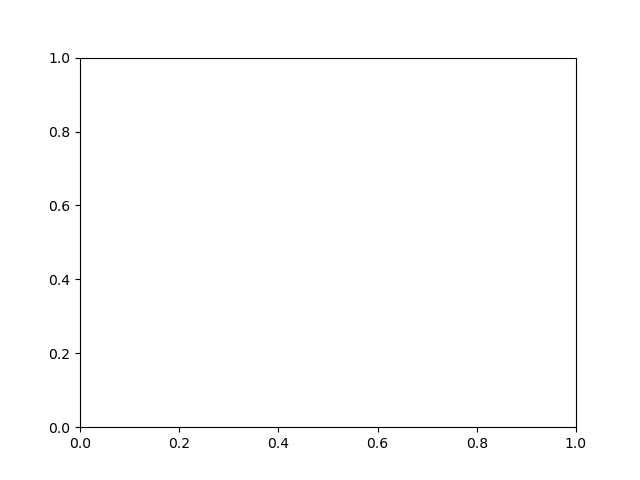

In [601]:
if "fittslaw_fig" in locals():
    plt.close(fittslaw_fig)
plt.ion()
fittslaw_fig = plt.figure()
fittslaw_ax = fittslaw_fig.gca()
# fittslaw_fig, fittslaw_ax = plt.subplots(1, 2, figsize=[9, 3])

In [650]:
fittslaw_ax.clear()

###
REMOVE_FAILED = True
REMOVE_OUTLIERS = False

EFFECTIVE_PROJECTION_PATH = True
USE_TARGETBOUND_AS_DIST = False
DWELL_TIME = 0.3  #only used if USE_TARGETBOUND_AS_DIST == False
MAX_TIME = 4.0  #only used if REMOVE_FAILED == True

PLOT_TYPE = "density_ID"  #"alldata", "boxplot", "mean_groups", "meandata", "density_ID"
BOXPLOT_category = "ID"
BOXPLOT_nbins = 5
BOXPLOT_qbins = True  #whether to use quantile-based bins (i.e., same number of samples per bin) or range-based bins (i.e., same length of each bin interval)

DENSITY_group_nIDbins = 5  #number of ID groups
DENSITY_group_IDbin_ID = 1  #index of ID group (between 0 and DENSITY_group_nIDbins-1) for which a density plot of movement times is created (only used if PLOT_TYPE == "density_ID")
DENSITY_group_nMTbins = 50
###

_plot_DENSITY_group = f"group{DENSITY_group_IDbin_ID}" if PLOT_TYPE == "density_ID" else ""
_plot_filename_header = "movement_time_" if PLOT_TYPE == "density_ID" else "fittslaw_"
plot_filename_fitts = f"UIB/{filename}/{_plot_filename_header}{PLOT_TYPE}{_plot_DENSITY_group}{'_eP' if EFFECTIVE_PROJECTION_PATH else ''}{'_bound' if USE_TARGETBOUND_AS_DIST else ''}_DWELL{DWELL_TIME}{'_rF' if REMOVE_FAILED else ''}{'_rO' if REMOVE_OUTLIERS else ''}"

if PLOT_TYPE != "boxplot":
    BOXPLOT_category = "ID (bits)"  #used for xlabel

trajectories = trajectories_SIMULATION

# Compute ID and MT pairs from dataset:
distance_list = []
width_list = []
ID_list = []
MT_list = []
target_position_list = []
initial_position_list = []
failed_movements_counter = 0

trajectories = trajectories_SIMULATION

trajectories.preprocess(MOVEMENT_IDS=None, RADIUS_IDS=None, EPISODE_IDS=None)
trajectories.compute_indices(TARGET_IDS=None, TRIAL_IDS=None, META_IDS=None, N_MOVS=None, AGGREGATION_VARS=[])

#assert not REPEATED_MOVEMENTS
# if REPEATED_MOVEMENTS:
#     EPISODE_ID_LIST = list(trajectories.data_copy.keys())
# else:
#     EPISODE_ID_LIST = range(trajectories.EPISODE_ID_NUMS)

# for EPISODE_ID in EPISODE_ID_LIST:
#     trajectories.preprocess(EPISODE_ID=str(EPISODE_ID), REPEATED_MOVEMENTS=False)
#     # Use all available trials
#     trajectories.compute_indices(TRIAL_IDS=None, META_IDS=None, N_MOVS=None)
    
for trial_index_current, (last_idx, current_idx, next_idx) in enumerate(trajectories.selected_movements_indices):
    try:
        trajectories.compute_trial(trial_index_current, effective_projection_path=EFFECTIVE_PROJECTION_PATH, targetbound_as_target=USE_TARGETBOUND_AS_DIST, dwell_time=DWELL_TIME, compute_deviation=False, normalize_time=False)
    except AssertionError:
        failed_movements_counter += 1
    else:
        MT_list.append(trajectories.effective_MT_trial)
        width_list.append(trajectories.target_width_trial)
        distance_list.append(trajectories.target_distance_trial)
        ID_list.append(trajectories.fitts_ID_trial)
        target_position_list.append(trajectories.final_val)
        initial_position_list.append(trajectories.init_val)

# Remove outliers:
movement_indices_TO_DELETE = []
if REMOVE_OUTLIERS or REMOVE_FAILED:
    # Ensure that too long movements are removed (all movements with duration - mean(duration) > 3 * std(duration))
    #MT_list_zscores = stats.zscore(MT_list)
    if REMOVE_OUTLIERS:
        movement_indices_TO_DELETE = np.where(np.abs(stats.zscore(MT_list)) > 3)[0].tolist()
    
    if REMOVE_FAILED:
        movement_indices_TO_DELETE = np.where(np.array(MT_list) >= MAX_TIME - DWELL_TIME - 1e-6)[0].tolist()

    distance_list = [val for idx, val in enumerate(distance_list) if idx not in movement_indices_TO_DELETE]
    width_list = [val for idx, val in enumerate(width_list) if idx not in movement_indices_TO_DELETE]
    ID_list = [val for idx, val in enumerate(ID_list) if idx not in movement_indices_TO_DELETE]
    MT_list = [val for idx, val in enumerate(MT_list) if idx not in movement_indices_TO_DELETE]
    target_position_list = [val for idx, val in enumerate(target_position_list) if idx not in movement_indices_TO_DELETE]
    initial_position_list = [val for idx, val in enumerate(initial_position_list) if idx not in movement_indices_TO_DELETE]

add_info = f'{len(movement_indices_TO_DELETE)} outliers were dropped' if movement_indices_TO_DELETE else '', f'{failed_movements_counter} movements failed' if failed_movements_counter else ''
add_info_nonempty = [i for i in add_info if len(i)]
add_info_str = f" ({'; '.join(add_info_nonempty)})" if add_info_nonempty else ""
print(f"INFO: Using {len(ID_list)} movements from {len(trajectories.data)} episodes{add_info_str}.")

# Linear regression:
poly_coef = np.polyfit(ID_list, MT_list, 1)
p_linreg = np.poly1d(poly_coef)

# Coefficient of determination:
SQE = np.square(np.linalg.norm(p_linreg(ID_list) - np.mean(MT_list)))
SQT = np.square(np.linalg.norm(MT_list - np.mean(MT_list)))
R2 = SQE/SQT
print("Fitts' Law - Coefficient of determination (R^2): {}".format(R2))

if PLOT_TYPE == "boxplot":
    df = pd.DataFrame({"Distance": distance_list, "Width": width_list, "ID": ID_list, "MT": MT_list})
    if BOXPLOT_qbins:
        df_bins = df.groupby([pd.qcut(df[BOXPLOT_category], BOXPLOT_nbins)])["MT"].apply(list)
    else:
        df_bins = df.groupby([pd.cut(df[BOXPLOT_category], BOXPLOT_nbins)])["MT"].apply(list)
    df_bins_renamed = df_bins.rename(lambda x: x if type(x) == float else f"{x.left.round(2)}-{x.right.round(2)}", axis=0)
    fittslaw_ax.boxplot(df_bins_renamed, labels=df_bins_renamed.index, positions=[x.mid for x in df_bins.index], widths=[0.8*(x.right - x.left) for x in df_bins.index])
    fittslaw_ax.relim()
    if BOXPLOT_category == "ID":
        lin_regression_x = locals()[f"{BOXPLOT_category}_list"]
        lin_regression_y = p_linreg(ID_list)
        lin_regression_sorted = sorted(zip(lin_regression_x, lin_regression_y))
        lin_regression_x = [x for x, y in lin_regression_sorted]
        lin_regression_y = [y for x, y in lin_regression_sorted]
        fittslaw_ax.plot(lin_regression_x, lin_regression_y, color="red")
elif PLOT_TYPE == "mean_groups":
    df = pd.DataFrame({"Distance": distance_list, "Width": width_list, "ID": ID_list, "MT": MT_list})
    if REPEATED_MOVEMENTS:
        assert df["Width"].nunique() == BOXPLOT_nbins, f"Set 'BOXPLOT_nbins' to the number of different target sizes included in the current dataset ({df['Width'].nunique()})!"
        if BOXPLOT_qbins:
            df_bins_groupby = df.groupby([pd.qcut(df["Distance"], BOXPLOT_nbins), df["Width"]])["MT"]
        else:
            df_bins_groupby = df.groupby([pd.cut(df["Distance"], BOXPLOT_nbins), df["Width"]])["MT"]
    else:
        if BOXPLOT_qbins:
            df_bins_groupby = df.groupby([pd.qcut(df["Distance"], BOXPLOT_nbins), pd.qcut(df["Width"], BOXPLOT_nbins)])["MT"]
        else:
            df_bins_groupby = df.groupby([pd.cut(df["Distance"], BOXPLOT_nbins), pd.cut(df["Width"], BOXPLOT_nbins)])["MT"]
    df_bins = df_bins_groupby.mean()
    df_bins_renamed = df_bins.rename(lambda x: x if type(x) == float else f"{x.left.round(2)}-{x.right.round(2)}", axis=0)
    df_bins_renamed.index = df_bins_renamed.index.map(lambda x: f"D: {x[0]}, W: {x[1]}")
    trans_dict_dist = {number: chr(ord('@')+number+1) for number in range(BOXPLOT_nbins)}
    trans_dict_width = {number: str(number) for number in range(BOXPLOT_nbins)}
    group_identifiers_dist = [(str(trans_dict_dist[idx]), f"D: {value}") for idx, value in enumerate(df_bins.index.get_level_values(0).unique().tolist())]
    group_identifiers_width = [(str(trans_dict_width[idx]), f"W: {value}") for idx, value in enumerate(df_bins.index.get_level_values(1).unique().tolist())]
    group_identifiers = df_bins.index.map(lambda x: "".join([trans_dict_dist[df_bins.index.get_level_values(0).unique().tolist().index(x[0])], trans_dict_width[df_bins.index.get_level_values(1).unique().tolist().index(x[1])]]))
    if REPEATED_MOVEMENTS:
        assert df["Width"].nunique() == BOXPLOT_nbins, f"Set 'BOXPLOT_nbins' to the number of different target sizes included in the current dataset ({df['Width'].nunique()})!"
        if BOXPLOT_qbins:
            df["classification"] = [df_bins.index.get_loc((x["Distance"], x["Width"])) for _, x in pd.concat((pd.qcut(df["Distance"], BOXPLOT_nbins), df["Width"]), axis=1).iterrows()]
        else:
            df["classification"] = [df_bins.index.get_loc((x["Distance"], x["Width"])) for _, x in pd.concat((pd.cut(df["Distance"], BOXPLOT_nbins), df["Width"]), axis=1).iterrows()]
    else:
        if BOXPLOT_qbins:
            df["classification"] = [df_bins.index.get_loc((x["Distance"], x["Width"])) for _, x in pd.concat((pd.qcut(df["Distance"], BOXPLOT_nbins), pd.qcut(df["Width"], BOXPLOT_nbins)), axis=1).iterrows()]
        else:
            df["classification"] = [df_bins.index.get_loc((x["Distance"], x["Width"])) for _, x in pd.concat((pd.cut(df["Distance"], BOXPLOT_nbins), pd.cut(df["Width"], BOXPLOT_nbins)), axis=1).iterrows()]
    df_bins = df_bins.reset_index()
    df_bins["ID"] = df_bins.apply(lambda x: pd.Interval(np.log2(2*x["Distance"].left / x["Width"]), np.log2(2*x["Distance"].right / x["Width"])) if type(x["Width"]) == float else (pd.Interval(np.log2(2*x["Distance"] / x["Width"].right), np.log2(2*x["Distance"] / x["Width"].left)) if type(x["Distance"]) == float else pd.Interval(np.log2(2*x["Distance"].left / x["Width"].right), np.log2(2*x["Distance"].right / x["Width"].left))), axis=1)
    df_bins["Average ID"] = df_bins.apply(lambda x: np.log2(2*x["Distance"].mid / x["Width"]) if type(x["Width"]) == float else (np.log2(2*x["Distance"] / x["Width"].mid) if type(x["Distance"]) == float else np.log2(2*x["Distance"].mid / x["Width"].mid)), axis=1)
    df_bins["Number of Samples"] = df_bins_groupby.size().reset_index(drop=True)
    xtick_offset = 0
    
    ### ONLY SHOW SOME CONDITIONS:
    # df = df.loc[(df["classification"] >= 5) & (df["classification"] < 15)]
    # group_identifiers_dist = group_identifiers_dist[1:3]
    # group_identifiers = group_identifiers[5:15]
    # df_bins = df_bins.iloc[5:15]
    # df_bins_renamed = df_bins_renamed.iloc[5:15]
    # xtick_offset = 5

    fittslaw_ax.scatter(range(xtick_offset, xtick_offset + len(df_bins_renamed)), df_bins_renamed, color="red")#, positions=[x.mid for x in df_bins.index], widths=[0.8*(x.right - x.left) for x in df_bins.index])
    fittslaw_ax.scatter(df["classification"], df["MT"], color="blue", s=0.2)
    ## VARIANT 1 - detailed xlabels:
    #fittslaw_ax.set_xticks(range(len(df_bins_renamed)), df_bins_renamed.index, fontsize=4)
    ## VARIANT 2 - abbreviations as xlabels, additional legend:
    #fittslaw_ax.set_xticks(df_bins[~df_bins["MT"].isna()].index, df_bins[~df_bins["MT"].isna()].index + 1)
    fittslaw_ax.set_xticks(df_bins[~df_bins["MT"].isna()].index, group_identifiers[~df_bins["MT"].isna()])
    class MarkerHandler(mpl.legend_handler.HandlerBase):  #source: https://stackoverflow.com/a/47395401
        def create_artists(self, legend, integer, xdescent, ydescent,
                            width, height, fontsize,trans):
            marker_obj = mpl.markers.MarkerStyle(f'${integer}$') #Here you place your integer
            path = marker_obj.get_path().transformed(marker_obj.get_transform())

            path._vertices = np.array(path._vertices)*8 #To make it larger
            patch = mpl.patches.PathPatch(path, color="black", lw=0, transform=trans+mpl.transforms.Affine2D().translate(0, 5.5))
            return [patch]
    fittslaw_ax.legend([x for x, y in group_identifiers_dist + group_identifiers_width], [y for x,y in group_identifiers_dist + group_identifiers_width], handler_map={str:MarkerHandler()}, handletextpad=0, handlelength=1)#, fontsize=8)
    ################################
    fittslaw_ax.relim()
elif PLOT_TYPE == "meandata":
    df = pd.DataFrame({"Distance": distance_list, "Width": width_list, "ID": ID_list, "MT": MT_list})
    if REPEATED_MOVEMENTS:
        assert df["Width"].nunique() == BOXPLOT_nbins, f"Set 'BOXPLOT_nbins' to the number of different target sizes included in the current dataset ({df['Width'].nunique()})!"
        if BOXPLOT_qbins:
            df_bins_groupby = df.groupby([pd.qcut(df["Distance"], BOXPLOT_nbins), df["Width"]])["MT"]
        else:
            df_bins_groupby = df.groupby([pd.cut(df["Distance"], BOXPLOT_nbins), df["Width"]])["MT"]   
    else:
        if BOXPLOT_qbins:
            df_bins_groupby = df.groupby([pd.qcut(df["Distance"], BOXPLOT_nbins), pd.qcut(df["Width"], BOXPLOT_nbins)])["MT"]
        else:
            df_bins_groupby = df.groupby([pd.cut(df["Distance"], BOXPLOT_nbins), pd.cut(df["Width"], BOXPLOT_nbins)])["MT"]        
    df_bins = df_bins_groupby.mean()
    df_bins_renamed = df_bins.rename(lambda x: x if type(x) == float else f"{x.left.round(2)}-{x.right.round(2)}", axis=0)
    df_bins_renamed.index = df_bins_renamed.index.map(lambda x: f"D: {x[0]}, W: {x[1]}")
    df_bins = df_bins.reset_index()
    df_bins["ID"] = df_bins.apply(lambda x: pd.Interval(np.log2(2*x["Distance"].left / x["Width"]), np.log2(2*x["Distance"].right / x["Width"])) if type(x["Width"]) == float else (pd.Interval(np.log2(2*x["Distance"] / x["Width"].right), np.log2(2*x["Distance"] / x["Width"].left)) if type(x["Distance"]) == float else pd.Interval(np.log2(2*x["Distance"].left / x["Width"].right), np.log2(2*x["Distance"].right / x["Width"].left))), axis=1)
    df_bins["Average ID"] = df_bins.apply(lambda x: np.log2(2*x["Distance"].mid / x["Width"]) if type(x["Width"]) == float else (np.log2(2*x["Distance"] / x["Width"].mid) if type(x["Distance"]) == float else np.log2(2*x["Distance"].mid / x["Width"].mid)), axis=1)
    
    df_bins["Number of Samples"] = df_bins_groupby.size().reset_index(drop=True)
    
    ### ONLY SHOW SOME CONDITIONS:
#     df_bins = df_bins.iloc[5:15]
#     df_bins_renamed = df_bins_renamed.iloc[5:15]
    
    fittslaw_ax.scatter(df_bins["Average ID"], df_bins["MT"])
    fittslaw_ax.plot(df_bins["Average ID"], p_linreg(df_bins["Average ID"]), color="red")
    
    # Coefficient of determination on mean groups:
    ID_list_mean = df_bins.loc[~df_bins["MT"].isna(), "Average ID"]
    MT_list_mean = df_bins.loc[~df_bins["MT"].isna(), "MT"]
    poly_coef_mean = np.polyfit(ID_list_mean, MT_list_mean, 1)
    p_linreg_mean = np.poly1d(poly_coef_mean)
    SQE_mean = np.square(np.linalg.norm(p_linreg_mean(ID_list_mean) - np.mean(MT_list_mean)))
    SQT_mean = np.square(np.linalg.norm(MT_list_mean - np.mean(MT_list_mean)))
    R2_mean = SQE_mean/SQT_mean
    print("Fitts' Law [ON MEAN PER CONDITION] - Coefficient of determination (R^2): {}".format(R2_mean))
elif PLOT_TYPE == "alldata":
    fittslaw_ax.scatter(ID_list, MT_list)
    fittslaw_ax.plot(ID_list, p_linreg(ID_list), color="red")
elif PLOT_TYPE == "density_ID":
    df = pd.DataFrame({"Distance": distance_list, "Width": width_list, "ID": ID_list, "MT": MT_list})
    if BOXPLOT_qbins:
        df_bins_ID_helper = pd.qcut(df["ID"], DENSITY_group_nIDbins)
        df_bins_ID_groupby = df.groupby([df_bins_ID_helper])["MT"]
        df_bins_ID = df_bins_ID_groupby.mean()
        df["classification"] = [df_bins_ID.index.get_loc(x) for x in df_bins_ID_helper.values]
    else:
        df_bins_ID_helper = pd.cut(df["ID"], DENSITY_group_nIDbins)
        df_bins_ID_groupby = df.groupby([df_bins_ID_helper])["MT"]
        df_bins_ID = df_bins_ID_groupby.mean()
        df["classification"] = [df_bins_ID.index.get_loc(x) for x in df_bins_ID_helper.values]
    ID_groups = sorted(df_bins_ID_helper.unique())
    df_bins_ID = df_bins_ID.reset_index()
    df_bins_ID["Average ID"] = df_bins_ID.apply(lambda x: x["ID"].mid, axis=1)
    df_bins_ID["Number of Samples"] = df_bins_ID_groupby.size().reset_index(drop=True)

    fittslaw_ax.hist(df.loc[df["classification"] == DENSITY_group_IDbin_ID, "MT"], DENSITY_group_nMTbins)
else:
    raise NotImplementedError

# # Save the default tick positions, so we can reset them...
# locs = fittslaw_ax.get_xticks()
# # Reset the xtick locations.
# fittslaw_ax.set_xticks(locs)

if PLOT_TYPE == "density_ID":
    fittslaw_ax.set_xlabel("MT (s)")
elif PLOT_TYPE not in ["mean_groups"]:
    fittslaw_ax.set_xlabel(BOXPLOT_category + (f" bits" if (BOXPLOT_category == "ID") else "")) #"ID (bits)")  
if PLOT_TYPE == "density_ID":
    fittslaw_ax.set_ylabel("Frequency")    
else:
    fittslaw_ax.set_ylabel("MT (s)")
if PLOT_TYPE == "meandata":
    fittslaw_ax.set_title("Fitts' Law on Mean Data ($R^2=${:.4f}; $a=${:.2f}, $b=${:.2f})".format(R2_mean, poly_coef_mean[1], poly_coef_mean[0]), fontsize=14) #fontsize=18)
elif PLOT_TYPE == "density_ID":
    fittslaw_ax.set_title(f"Movement Time – Density Plot (ID: {ID_groups[DENSITY_group_IDbin_ID]})")
else:
    fittslaw_ax.set_title("Fitts' Law ($R^2=${:.4f}; $a=${:.2f}, $b=${:.2f})".format(R2, poly_coef[1], poly_coef[0]), fontsize=14) #fontsize=18)

# if PLOT_TYPE == "density_ID":
#     fittslaw_fig.savefig(f"plots/{filename}/movement_time_{PLOT_TYPE}group{DENSITY_group_IDbin_ID}.png", dpi=120)
# else:
#     fittslaw_fig.savefig(f"plots/{filename}/fittslaw_{PLOT_TYPE}.png", dpi=120)
fittslaw_fig.savefig(f"/home/florian/reacher_sg/_plots/{plot_filename_fitts}.png", dpi=300)


100 movement sequences identified.
1000 trials identified.
INFO: Using 997 movements from 100 episodes (3 outliers were dropped).
Fitts' Law - Coefficient of determination (R^2): 0.5504925324629855


In [631]:
[x/np.linalg.norm(x) for i in movement_indices_TO_DELETE if (x := (target_position_list[i] - initial_position_list[i])) is not None]

[array([-0.12827989, -0.52012265,  0.84440316]),
 array([ 0.2851841 , -0.89532199, -0.34215283]),
 array([-0.17349319,  0.82820161,  0.53289981])]

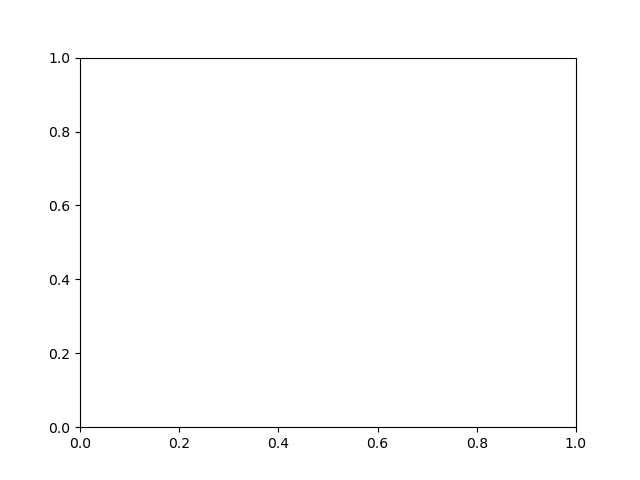

In [628]:
if "endpointvar_fig" in locals():
    plt.close(endpointvar_fig)
plt.ion()
endpointvar_fig = plt.figure()
endpointvar_ax = endpointvar_fig.gca()
# endpointvar_fig, endpointvar_ax = plt.subplots(1, 2, figsize=[9, 3])

In [642]:
endpointvar_ax.clear()

###
REMOVE_FAILED = True
REMOVE_OUTLIERS = False

EFFECTIVE_PROJECTION_PATH = True
USE_TARGETBOUND_AS_DIST = False
DWELL_TIME = 0.3  #only used if USE_TARGETBOUND_AS_DIST == False
MAX_TIME = 4.0  #only used if REMOVE_FAILED == True

PLOT_TYPE = "alldata"  #"alldata", "boxplot", "mean_groups", "meandata", "density_ID"
COVARIANCE_AXIS = 0
BOXPLOT_category = "Width"
BOXPLOT_nbins = 5
BOXPLOT_qbins = True  #whether to use quantile-based bins (i.e., same number of samples per bin) or range-based bins (i.e., same length of each bin interval)

DENSITY_group_nIDbins = 5  #number of ID groups
DENSITY_group_IDbin_ID = 0  #index of ID group (between 0 and DENSITY_group_nIDbins-1) for which a density plot of movement times is created (only used if PLOT_TYPE == "density_ID")
DENSITY_group_nMTbins = 50
###

_plot_DENSITY_group = f"group{DENSITY_group_IDbin_ID}" if PLOT_TYPE == "density_ID" else ""
plot_filename_endpointvar = f"UIB/{filename}/endpoint_std_{PLOT_TYPE}{_plot_DENSITY_group}{'_eP' if EFFECTIVE_PROJECTION_PATH else ''}{'_bound' if USE_TARGETBOUND_AS_DIST else ''}_DWELL{DWELL_TIME}{'_rF' if REMOVE_FAILED else ''}{'_rO' if REMOVE_OUTLIERS else ''}"

if PLOT_TYPE != "boxplot":
    BOXPLOT_category = "Endpoint Std. (m)"  #used for xlabel

trajectories = trajectories_SIMULATION
    
# Compute end-point (i.e., end-effector dwell time) variances from dataset:
covariances_list = []
dwelltime_indices_list = []
num_target_entries_list = []
distance_list = []
width_list = []
MT_list = []
failed_movements_counter = 0

trajectories = trajectories_SIMULATION

trajectories.preprocess(MOVEMENT_IDS=None, RADIUS_IDS=None, EPISODE_IDS=None)
trajectories.compute_indices(TARGET_IDS=None, TRIAL_IDS=None, META_IDS=None, N_MOVS=None, AGGREGATION_VARS=[])

# #assert not REPEATED_MOVEMENTS
# if REPEATED_MOVEMENTS:
#     EPISODE_ID_LIST = list(trajectories.data_copy.keys())
# else:
#     EPISODE_ID_LIST = range(trajectories.EPISODE_ID_NUMS)

# for EPISODE_ID in EPISODE_ID_LIST:
#     trajectories.preprocess(EPISODE_ID=str(EPISODE_ID))
#     # Use all available trials
#     trajectories.compute_indices(TRIAL_IDS=None, META_IDS=None, N_MOVS=None)
    
for trial_index_current, (last_idx, current_idx, next_idx) in enumerate(trajectories.selected_movements_indices):
    try:
        trajectories.compute_trial(trial_index_current, effective_projection_path=EFFECTIVE_PROJECTION_PATH, targetbound_as_target=USE_TARGETBOUND_AS_DIST, dwell_time=DWELL_TIME, compute_deviation=False, normalize_time=False)
    except AssertionError:
        failed_movements_counter += 1
    else:
        MT_list.append(trajectories.effective_MT_trial)
        width_list.append(trajectories.target_width_trial)
        distance_list.append(trajectories.target_distance_trial)

        covariances_list.append(trajectories.endeffector_insidetarget_covariance)
        dwelltime_indices_list.append(trajectories.relindices_insidetarget_trial)
        num_target_entries_list.append(trajectories.num_target_entries_trial)

# Remove outliers:
movement_indices_TO_DELETE = []
if REMOVE_OUTLIERS or REMOVE_FAILED:
    # Ensure that too long movements are removed (all movements with duration - mean(duration) > 3 * std(duration))
    #MT_list_zscores = stats.zscore(MT_list)
    if REMOVE_OUTLIERS:
        movement_indices_TO_DELETE = np.where(np.abs(stats.zscore(MT_list)) > 3)[0].tolist()
    
    if REMOVE_FAILED:
        movement_indices_TO_DELETE = np.where(np.array(MT_list) >= MAX_TIME - DWELL_TIME - 1e-6)[0].tolist()

    covariances_list = [val for idx, val in enumerate(covariances_list) if idx not in movement_indices_TO_DELETE]
    dwelltime_indices_list = [val for idx, val in enumerate(dwelltime_indices_list) if idx not in movement_indices_TO_DELETE]
    num_target_entries_list = [val for idx, val in enumerate(num_target_entries_list) if idx not in movement_indices_TO_DELETE]
    distance_list = [val for idx, val in enumerate(distance_list) if idx not in movement_indices_TO_DELETE]
    width_list = [val for idx, val in enumerate(width_list) if idx not in movement_indices_TO_DELETE]
    MT_list = [val for idx, val in enumerate(MT_list) if idx not in movement_indices_TO_DELETE]

# Map covariance matrices to scalar value (e.g., standard deviation along a given Cartesian axis)
std_mapped = list(map(lambda x: np.sqrt(x[COVARIANCE_AXIS, COVARIANCE_AXIS]), covariances_list))

add_info = f'{len(movement_indices_TO_DELETE)} outliers were dropped' if movement_indices_TO_DELETE else '', f'{failed_movements_counter} movements failed' if failed_movements_counter else ''
add_info_nonempty = [i for i in add_info if len(i)]
add_info_str = f" ({'; '.join(add_info_nonempty)})" if add_info_nonempty else ""
print(f"INFO: Using {len(covariances_list)} movements from {len(trajectories.data)} episodes{add_info_str}.")

# Linear regression:
poly_coef = np.polyfit(width_list, std_mapped, 1)
p_linreg = np.poly1d(poly_coef)

# Coefficient of determination:
SQE = np.square(np.linalg.norm(p_linreg(width_list) - np.mean(std_mapped)))
SQT = np.square(np.linalg.norm(std_mapped - np.mean(std_mapped)))
R2 = SQE/SQT
print("Linear Mapping between Width and Standard Deviation - Coefficient of determination (R^2): {}".format(R2))

if PLOT_TYPE == "boxplot":
    df = pd.DataFrame({"Width": width_list, "Endpoint Std": std_mapped})
    if BOXPLOT_qbins:
        df_bins = df.groupby([pd.qcut(df[BOXPLOT_category], BOXPLOT_nbins)])["Endpoint Std"].apply(list)
    else:
        df_bins = df.groupby([pd.cut(df[BOXPLOT_category], BOXPLOT_nbins)])["Endpoint Std"].apply(list)
    df_bins_renamed = df_bins.rename(lambda x: x if type(x) == float else f"{x.left.round(2)}-{x.right.round(2)}", axis=0)
    endpointvar_ax.boxplot(df_bins_renamed, labels=df_bins_renamed.index, positions=[x.mid for x in df_bins.index], widths=[0.8*(x.right - x.left) for x in df_bins.index])
    endpointvar_ax.relim()
    if BOXPLOT_category == "Width":
        lin_regression_x = width_list
        lin_regression_y = p_linreg(width_list)
        lin_regression_sorted = sorted(zip(lin_regression_x, lin_regression_y))
        lin_regression_x = [x for x, y in lin_regression_sorted]
        lin_regression_y = [y for x, y in lin_regression_sorted]
        endpointvar_ax.plot(lin_regression_x, lin_regression_y, color="red")
elif PLOT_TYPE == "mean_groups":
    df = pd.DataFrame({"Distance": distance_list, "Width": width_list, "Endpoint Std": std_mapped})
    if REPEATED_MOVEMENTS:
        assert df["Width"].nunique() == BOXPLOT_nbins, f"Set 'BOXPLOT_nbins' to the number of different target sizes included in the current dataset ({df['Width'].nunique()})!"
        if BOXPLOT_qbins:
            df_bins_groupby = df.groupby([pd.qcut(df["Distance"], BOXPLOT_nbins), df["Width"]])["Endpoint Std"]
        else:
            df_bins_groupby = df.groupby([pd.cut(df["Distance"], BOXPLOT_nbins), df["Width"]])["Endpoint Std"]
    else:
        if BOXPLOT_qbins:
            df_bins_groupby = df.groupby([pd.qcut(df["Distance"], BOXPLOT_nbins), pd.qcut(df["Width"], BOXPLOT_nbins)])["Endpoint Std"]
        else:
            df_bins_groupby = df.groupby([pd.cut(df["Distance"], BOXPLOT_nbins), pd.cut(df["Width"], BOXPLOT_nbins)])["Endpoint Std"]
    df_bins = df_bins_groupby.mean()
    df_bins_renamed = df_bins.rename(lambda x: x if type(x) == float else f"{x.left.round(2)}-{x.right.round(2)}", axis=0)
    df_bins_renamed.index = df_bins_renamed.index.map(lambda x: f"D: {x[0]}, W: {x[1]}")
    trans_dict_dist = {number: chr(ord('@')+number+1) for number in range(BOXPLOT_nbins)}
    trans_dict_width = {number: str(number) for number in range(BOXPLOT_nbins)}
    group_identifiers_dist = [(str(trans_dict_dist[idx]), f"D: {value}") for idx, value in enumerate(df_bins.index.get_level_values(0).unique().tolist())]
    group_identifiers_width = [(str(trans_dict_width[idx]), f"W: {value}") for idx, value in enumerate(df_bins.index.get_level_values(1).unique().tolist())]
    group_identifiers = df_bins.index.map(lambda x: "".join([trans_dict_dist[df_bins.index.get_level_values(0).unique().tolist().index(x[0])], trans_dict_width[df_bins.index.get_level_values(1).unique().tolist().index(x[1])]]))
    if REPEATED_MOVEMENTS:
        assert df["Width"].nunique() == BOXPLOT_nbins, f"Set 'BOXPLOT_nbins' to the number of different target sizes included in the current dataset ({df['Width'].nunique()})!"
        if BOXPLOT_qbins:
            df["classification"] = [df_bins.index.get_loc((x["Distance"], x["Width"])) for _, x in pd.concat((pd.qcut(df["Distance"], BOXPLOT_nbins), df["Width"]), axis=1).iterrows()]
        else:
            df["classification"] = [df_bins.index.get_loc((x["Distance"], x["Width"])) for _, x in pd.concat((pd.cut(df["Distance"], BOXPLOT_nbins), df["Width"]), axis=1).iterrows()]
    else:
        if BOXPLOT_qbins:
            df["classification"] = [df_bins.index.get_loc((x["Distance"], x["Width"])) for _, x in pd.concat((pd.qcut(df["Distance"], BOXPLOT_nbins), pd.qcut(df["Width"], BOXPLOT_nbins)), axis=1).iterrows()]
        else:
            df["classification"] = [df_bins.index.get_loc((x["Distance"], x["Width"])) for _, x in pd.concat((pd.cut(df["Distance"], BOXPLOT_nbins), pd.cut(df["Width"], BOXPLOT_nbins)), axis=1).iterrows()]
    df_bins = df_bins.reset_index()
    df_bins["ID"] = df_bins.apply(lambda x: pd.Interval(np.log2(2*x["Distance"].left / x["Width"]), np.log2(2*x["Distance"].right / x["Width"])) if type(x["Width"]) == float else (pd.Interval(np.log2(2*x["Distance"] / x["Width"].right), np.log2(2*x["Distance"] / x["Width"].left)) if type(x["Distance"]) == float else pd.Interval(np.log2(2*x["Distance"].left / x["Width"].right), np.log2(2*x["Distance"].right / x["Width"].left))), axis=1)
    df_bins["Average ID"] = df_bins.apply(lambda x: np.log2(2*x["Distance"].mid / x["Width"]) if type(x["Width"]) == float else (np.log2(2*x["Distance"] / x["Width"].mid) if type(x["Distance"]) == float else np.log2(2*x["Distance"].mid / x["Width"].mid)), axis=1)
    df_bins["Number of Samples"] = df_bins_groupby.size().reset_index(drop=True)
    xtick_offset = 0
    
    ### ONLY SHOW SOME CONDITIONS:
    # df = df.loc[(df["classification"] >= 5) & (df["classification"] < 15)]
    # group_identifiers_dist = group_identifiers_dist[1:3]
    # group_identifiers = group_identifiers[5:15]
    # df_bins = df_bins.iloc[5:15]
    # df_bins_renamed = df_bins_renamed.iloc[5:15]
    # xtick_offset = 5

    endpointvar_ax.scatter(range(xtick_offset, xtick_offset + len(df_bins_renamed)), df_bins_renamed, color="red")#, positions=[x.mid for x in df_bins.index], widths=[0.8*(x.right - x.left) for x in df_bins.index])
    endpointvar_ax.scatter(df["classification"], df["Endpoint Std"], color="blue", s=0.2)
    ## VARIANT 1 - detailed xlabels:
    #endpointvar_ax.set_xticks(range(len(df_bins_renamed)), df_bins_renamed.index, fontsize=4)
    ## VARIANT 2 - abbreviations as xlabels, additional legend:
    #endpointvar_ax.set_xticks(df_bins[~df_bins["Endpoint Std"].isna()].index, df_bins[~df_bins["Endpoint Std"].isna()].index + 1)
    endpointvar_ax.set_xticks(df_bins[~df_bins["Endpoint Std"].isna()].index, group_identifiers[~df_bins["Endpoint Std"].isna()])
    class MarkerHandler(mpl.legend_handler.HandlerBase):  #source: https://stackoverflow.com/a/47395401
        def create_artists(self, legend, integer, xdescent, ydescent,
                            width, height, fontsize,trans):
            marker_obj = mpl.markers.MarkerStyle(f'${integer}$') #Here you place your integer
            path = marker_obj.get_path().transformed(marker_obj.get_transform())

            path._vertices = np.array(path._vertices)*8 #To make it larger
            patch = mpl.patches.PathPatch(path, color="black", lw=0, transform=trans+mpl.transforms.Affine2D().translate(0, 5.5))
            return [patch]
    endpointvar_ax.legend([x for x, y in group_identifiers_dist + group_identifiers_width], [y for x,y in group_identifiers_dist + group_identifiers_width], handler_map={str:MarkerHandler()}, handletextpad=0, handlelength=1)#, fontsize=8)
    ################################
    endpointvar_ax.relim()
elif PLOT_TYPE == "meandata":
   
    df = pd.DataFrame({"Distance": distance_list, "Width": width_list, "Endpoint Std": std_mapped})
    if REPEATED_MOVEMENTS:
        assert df["Width"].nunique() == BOXPLOT_nbins, f"Set 'BOXPLOT_nbins' to the number of different target sizes included in the current dataset ({df['Width'].nunique()})!"
        if BOXPLOT_qbins:
            df_bins_groupby = df.groupby([pd.qcut(df["Distance"], BOXPLOT_nbins), df["Width"]])["Endpoint Std"]
        else:
            df_bins_groupby = df.groupby([pd.cut(df["Distance"], BOXPLOT_nbins), df["Width"]])["Endpoint Std"]   
    else:
        if BOXPLOT_qbins:
            df_bins_groupby = df.groupby([pd.qcut(df["Distance"], BOXPLOT_nbins), pd.qcut(df["Width"], BOXPLOT_nbins)])["Endpoint Std"]
        else:
            df_bins_groupby = df.groupby([pd.cut(df["Distance"], BOXPLOT_nbins), pd.cut(df["Width"], BOXPLOT_nbins)])["Endpoint Std"]        
    df_bins = df_bins_groupby.mean()
    df_bins_renamed = df_bins.rename(lambda x: x if type(x) == float else f"{x.left.round(2)}-{x.right.round(2)}", axis=0)
    df_bins_renamed.index = df_bins_renamed.index.map(lambda x: f"D: {x[0]}, W: {x[1]}")
    df_bins = df_bins.reset_index()
    #df_bins["ID"] = df_bins.apply(lambda x: pd.Interval(np.log2(2*x["Distance"].left / x["Width"]), np.log2(2*x["Distance"].right / x["Width"])) if type(x["Width"]) == float else (pd.Interval(np.log2(2*x["Distance"] / x["Width"].right), np.log2(2*x["Distance"] / x["Width"].left)) if type(x["Distance"]) == float else pd.Interval(np.log2(2*x["Distance"].left / x["Width"].right), np.log2(2*x["Distance"].right / x["Width"].left))), axis=1)
    #df_bins["Average ID"] = df_bins.apply(lambda x: np.log2(2*x["Distance"].mid / x["Width"]) if type(x["Width"]) == float else (np.log2(2*x["Distance"] / x["Width"].mid) if type(x["Distance"]) == float else np.log2(2*x["Distance"].mid / x["Width"].mid)), axis=1)
    df_bins["Average Width"] = df_bins.apply(lambda x: x["Width"].mid, axis=1)

    df_bins["Number of Samples"] = df_bins_groupby.size().reset_index(drop=True)
    
    ### ONLY SHOW SOME CONDITIONS:
#     df_bins = df_bins.iloc[5:15]
#     df_bins_renamed = df_bins_renamed.iloc[5:15]
    
    endpointvar_ax.scatter(df_bins["Average Width"], df_bins["Endpoint Std"])
    endpointvar_ax.plot(df_bins["Average Width"], p_linreg(df_bins["Average Width"]), color="red")
    
    # Coefficient of determination on mean groups:
    width_list_mean = df_bins.loc[~df_bins["Endpoint Std"].isna(), "Average Width"]
    std_mapped_mean = df_bins.loc[~df_bins["Endpoint Std"].isna(), "Endpoint Std"]
    poly_coef_mean = np.polyfit(width_list_mean, std_mapped_mean, 1)
    p_linreg_mean = np.poly1d(poly_coef_mean)
    SQE_mean = np.square(np.linalg.norm(p_linreg_mean(width_list_mean) - np.mean(std_mapped_mean)))
    SQT_mean = np.square(np.linalg.norm(std_mapped_mean - np.mean(std_mapped_mean)))
    R2_mean = SQE_mean/SQT_mean
    print("Linear Mapping between Width and Standard Deviation [ON MEAN PER CONDITION] - Coefficient of determination (R^2): {}".format(R2_mean))
elif PLOT_TYPE == "alldata":
    endpointvar_ax.scatter(width_list, std_mapped)
    endpointvar_ax.plot(width_list, p_linreg(width_list), color="red")
elif PLOT_TYPE == "density_ID":
    df = pd.DataFrame({"Distance": distance_list, "Width": width_list, "Endpoint Std": std_mapped})
    if BOXPLOT_qbins:
        df_bins_ID_helper = pd.qcut(df["Width"], DENSITY_group_nIDbins)
        df_bins_ID_groupby = df.groupby([df_bins_ID_helper])["Endpoint Std"]
        df_bins_ID = df_bins_ID_groupby.mean()
        df["classification"] = [df_bins_ID.index.get_loc(x) for x in df_bins_ID_helper.values]
    else:
        df_bins_ID_helper = pd.cut(df["Width"], DENSITY_group_nIDbins)
        df_bins_ID_groupby = df.groupby([df_bins_ID_helper])["Endpoint Std"]
        df_bins_ID = df_bins_ID_groupby.mean()
        df["classification"] = [df_bins_ID.index.get_loc(x) for x in df_bins_ID_helper.values]
    ID_groups = sorted(df_bins_ID_helper.unique())
    df_bins_ID = df_bins_ID.reset_index()
    df_bins_ID["Average Width"] = df_bins_ID.apply(lambda x: x["Width"].mid, axis=1)
    df_bins_ID["Number of Samples"] = df_bins_ID_groupby.size().reset_index(drop=True)

    endpointvar_ax.hist(df.loc[df["classification"] == DENSITY_group_IDbin_ID, "Endpoint Std"], DENSITY_group_nMTbins)
else:
    raise NotImplementedError

# # Save the default tick positions, so we can reset them...
# locs = endpointvar_ax.get_xticks()
# # Reset the xtick locations.
# endpointvar_ax.set_xticks(locs)

if PLOT_TYPE == "density_ID":
    endpointvar_ax.set_xlabel("Endpoint Std. (m)")
elif PLOT_TYPE not in ["mean_groups"]:
    endpointvar_ax.set_xlabel(BOXPLOT_category + (f" (m)" if (BOXPLOT_category == "Width") else "")) #"ID (bits)")  
if PLOT_TYPE == "density_ID":
    endpointvar_ax.set_ylabel("Frequency")    
else:
    endpointvar_ax.set_ylabel("Endpoint Std. (m)")
if PLOT_TYPE == "meandata":
    endpointvar_ax.set_title("Linear Endpoint Variability on Mean Data ($R^2=${:.4f}; $a=${:.2f}, $b=${:.2f})".format(R2_mean, poly_coef_mean[1], poly_coef_mean[0]), fontsize=14) #fontsize=18)
elif PLOT_TYPE == "density_ID":
    endpointvar_ax.set_title(f"Endpoint Variability – Density Plot (ID: {ID_groups[DENSITY_group_IDbin_ID]})")
else:
    endpointvar_ax.set_title("Endpoint Variability ($R^2=${:.4f}; $a=${:.2f}, $b=${:.2f})".format(R2, poly_coef[1], poly_coef[0]), fontsize=14) #fontsize=18)

#if PLOT_TYPE == "density_ID":
#    endpointvar_fig.savefig(f"plots/{filename}/endpoint_std_{PLOT_TYPE}group{DENSITY_group_IDbin_ID}.png", dpi=120)
#else:
#    endpointvar_fig.savefig(f"plots/{filename}/endpoint_std_{PLOT_TYPE}.png", dpi=120)
endpointvar_fig.savefig(f"/home/florian/reacher_sg/_plots/{plot_filename_endpointvar}.png", dpi=300)
 

100 movement sequences identified.
1000 trials identified.
INFO: Using 997 movements from 100 episodes (3 outliers were dropped).
Linear Mapping between Width and Standard Deviation - Coefficient of determination (R^2): 0.13938374888681382


### Quantitative Comparisons

In [161]:
### RUN QUANTITATIVE COMPARISONS BETWEEN TWO DATASETS
class QuantitativeComparison(object):
    
    def __init__(self, trajectories1, trajectories2):
        self.trajectories1 = trajectories1  #TrajectoryData instance
        self.trajectories2 = trajectories2  #TrajectoryData instance
    
    def compare(self, data_name1, data_name2=None, cols=None, metric="RMSE", mean_axis=None):
        #WARNING: "data_name1" and "data_name2" need to correspond to some "_trial" (or "_mean") attribute!
        #INFO: "cols" should be array-like, consisting of column indices to take into account; if "None", all data columns are used.
        #INFO: "mean_axis" is used as "axis" argument of np.mean(), i.e., "None" corresponds to mean of flattened array, and "0" corresponds to mean along time axis for each data column.
        
        if data_name2 is None:
            data_name2 = data_name1
        assert isinstance(data_name1, str) and isinstance(data_name2, str)  #data_name1 and data_name2 should be strings corresponding to the attributes of trajectories1 and trajectories2, respectively, that should be compared
            
        data1 = getattr(self.trajectories1, data_name1)
        data2 = getattr(self.trajectories2, data_name2)
        
        if cols is not None:
            data1 = data1[..., cols]
            data2 = data2[..., cols]
        
        if len(data1) != len(data2):
            assert hasattr(self.trajectories1, "time_series_trial") and hasattr(self.trajectories2, "time_series_trial")
            #input((self.trajectories1.time_series_trial, self.trajectories2.time_series_trial))
            if any([i != j for i,j in zip(self.trajectories1.time_series_trial, self.trajectories2.time_series_trial)]):
                logging.warning(f"Time series do not match. Interpolate second dataset at time series of first dataset.")
                #data2 = np.interp(self.trajectories1.time_series_trial, self.trajectories2.time_series_trial, data2)
                data2_f = interp1d(self.trajectories2.time_series_trial, data2, axis=0, fill_value="extrapolate")
                data2 = data2_f(self.trajectories1.time_series_trial)
            else:
                logging.warning(f"Ignore overhanging last {max(len(data1), len(data2)) - min(len(data1), len(data2))} timesteps.")
        
        if metric == "RMSE":
            #WARNING: if data1 and data2 are multi-dimensional, np.mean() takes mean along all dimensions!
            res = np.sqrt(np.mean([(j-i)**2 for i,j in zip(data1, data2)], axis=mean_axis))
        else:
            raise NotImplementedError
            
        return res
    
    def compare_all_trials(self, data_name1, data_name2=None, ignore_unpaired_trials=False, effective_projection_path=False, **kwargs):
        
        # INFO: "ignore_unpaired_trials" can be used even if self.trajectories1.indices and self.trajectories2.indices are not of the same form (e.g., for comparison between RL and STUDY data)
        if ignore_unpaired_trials and (len(self.trajectories1.selected_movements_indices) != len(self.trajectories2.selected_movements_indices)):  #remove indices only available in data_name1
            logging.warning(f"Indices do not match. Remove redundant trials from first dataset.")
            assert len(self.trajectories1.selected_movements_indices) >= len(self.trajectories2.selected_movements_indices), f"{len(self.trajectories2.selected_movements_indices) - len(self.trajectories1.selected_movements_indices)} trials are missing in simulation!."
            assert len(self.trajectories1.indices) == len(self.trajectories1.selected_movements_indices), f"ERROR: 'indices' and 'selected_movements_indices' do not have the same length!"
            self.trajectories1._indices = self.trajectories1.indices[[i in self.trajectories2.indices[:, 4] for i in self.trajectories1.indices[:, 4]]]
            self.trajectories1.selected_movements_indices = [trajectories_SIMULATION.selected_movements_indices[meta_idx] for meta_idx, i in enumerate(trajectories_SIMULATION.indices[:, 4]) if i in trajectories_STUDY.indices[:, 4]]#.shape
                
        assert len(self.trajectories1.selected_movements_indices) == len(self.trajectories2.selected_movements_indices), f"Number of considered trials does not match between the two datasets ({len(self.trajectories1.selected_movements_indices)} vs. {len(self.trajectories2.selected_movements_indices)})."
        #assert np.all(self.trajectories1.indices[:, 2:] == self.trajectories2.indices[:, 2:]), "Indices do not match between the two datasets."
        
        res_all_trials = []
        for trial_index_current in range(len(self.trajectories1.selected_movements_indices)):
            self.trajectories1.compute_trial(trial_index_current, effective_projection_path)
            self.trajectories2.compute_trial(trial_index_current, effective_projection_path)
            res_all_trials.append(self.compare(data_name1, data_name2=None, **kwargs))
        
        return res_all_trials

In [162]:
#####
#MARKUS MPC - RMSE COMPUTATIONS

USER_ID_LIST = [f"U{i}" for i in range (1,7)]
SIMULATION_SUBDIR_LIST = ["fitts_btrzx1_tochi_neu_09032022_2021-10-25_N8_cso_sae_noise",
                    "fitts_btrzx1_tochi_neu_09032022_2021-10-25_ctc_N8_cso_sae_noise",
                    "fitts_btrzx1_tochi_neu_09032022_2021-10-25_accjoint_N8_cso_sae_noise"]

TASK_CONDITION_LIST = ["Standing_ID_ISO_15_plane", 
                       "Standing_Cursor_Handtuned_ISO_15_plane", "Standing_Pad_ID_ISO_15_plane",
                       "Standing_Pad_Handtuned_vertical_ISO_15_plane"]

logging.getLogger().setLevel(logging.ERROR)

start_time = time.time()

res_dict_pos = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST}
res_dict_vel = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST}
res_dict_acc = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST}
res_dict_qpos = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST}
res_dict_qvel = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST}
res_dict_qacc = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST}

for USER_ID in USER_ID_LIST:    
    for TASK_CONDITION in TASK_CONDITION_LIST:            
        # Preprocess simulation trajectories (ISO Task User Study):
        trajectories_STUDY = TrajectoryData_STUDY(USER_ID=USER_ID, TASK_CONDITION=TASK_CONDITION)
        trajectories_STUDY.preprocess()
        # Use all available trials
        trajectories_STUDY.compute_indices(TARGET_IDS=None, TRIAL_IDS=None, META_IDS=None, N_MOVS=None, AGGREGATION_VARS=[])
        
        for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST:
            trajectories_SIMULATION = TrajectoryData_MPC(SIMULATION_SUBDIR, USER_ID=USER_ID, TASK_CONDITION=TASK_CONDITION)
            trajectories_SIMULATION.preprocess()
            # Use all available trials
            trajectories_SIMULATION.compute_indices(TARGET_IDS=None, TRIAL_IDS=None, META_IDS=None, N_MOVS=None, AGGREGATION_VARS=[])

            sim_vs_study = QuantitativeComparison(trajectories_SIMULATION, trajectories_STUDY)
            #sim_vs_study.compare("projected_trajectories_pos_trial")
            
            try:
                res_pos = sim_vs_study.compare_all_trials("position_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=True)
                res_vel = sim_vs_study.compare_all_trials("velocity_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=True)
                res_acc = sim_vs_study.compare_all_trials("acceleration_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=True)
                res_qpos = sim_vs_study.compare_all_trials("qpos_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=True)
                res_qvel = sim_vs_study.compare_all_trials("qvel_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=True)
                res_qacc = sim_vs_study.compare_all_trials("qacc_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=True)
                        
                res_dict_pos[SIMULATION_SUBDIR].append(res_pos)
                res_dict_vel[SIMULATION_SUBDIR].append(res_vel)
                res_dict_acc[SIMULATION_SUBDIR].append(res_acc)
                res_dict_qpos[SIMULATION_SUBDIR].append(res_qpos)
                res_dict_qvel[SIMULATION_SUBDIR].append(res_qvel)
                res_dict_qacc[SIMULATION_SUBDIR].append(res_qacc)
            except AssertionError as e:
                print((f"{USER_ID}, {TASK_CONDITION}, {SIMULATION_SUBDIR}: {e}"))
                print("Will ignore this sub-dataset and continue...")

end_time = time.time()
logging.getLogger().setLevel(logging.INFO)

logging.info(f"RMSE computation took {end_time - start_time} seconds.")

#########################

_plot_SIMULATION_SUBDIR_LIST = "__".join(SIMULATION_SUBDIR_LIST)
_plot_TASK_CONDITION_LIST = "__".join(TASK_CONDITION_LIST)
if not os.path.exists(f"/home/florian/reacher_sg/_plots/MPC/{_plot_SIMULATION_SUBDIR_LIST}/ALLUSERS/{_plot_TASK_CONDITION_LIST}/"):  #create plot (sub-)directories
    os.makedirs(f"/home/florian/reacher_sg/_plots/MPC/{_plot_SIMULATION_SUBDIR_LIST}/ALLUSERS/{_plot_TASK_CONDITION_LIST}/")

ERROR:root:Cannot load StaticOptimization Data (U1, Standing_Cursor_Handtuned_ISO_15_plane).
ERROR:root:Cannot load StaticOptimization Data (U1, Standing_Pad_Handtuned_vertical_ISO_15_plane).
ERROR:root:Cannot load StaticOptimization Data (U4, Standing_Cursor_Handtuned_ISO_15_plane).
ERROR:root:Cannot load StaticOptimization Data (U5, Standing_ID_ISO_15_plane).
ERROR:root:Cannot load StaticOptimization Data (U5, Standing_Cursor_Handtuned_ISO_15_plane).
ERROR:root:Cannot load StaticOptimization Data (U5, Standing_Pad_ID_ISO_15_plane).
ERROR:root:STUDY (U5, Standing_Pad_Handtuned_vertical_ISO_15_plane) - Removed trials with Trial ID [10 17 23 30 36 43 49 56], since no movement to initial position (Target(s) [ 4 10]) could be identified.
ERROR:root:MPC (U5, Standing_Pad_Handtuned_vertical_ISO_15_plane, fitts_btrzx1_tochi_neu_09032022_2021-10-25_N8_cso_sae_noise) - Removed trials with Trial ID [10 17 23 30 36 43 49 56], since no movement to initial position (Target(s) [ 4 10]) could be ide

In [345]:
#####
#MARKUS MPC - RMSE COMPUTATIONS (SIM2USER vs. USER2USER)

USER_ID_LIST = [f"U{i}" for i in range (1,7)]
SIMULATION_SUBDIR_LIST = [#"fitts_btrzx1_tochi_neu_09032022_2021-10-25_N8_cso_sae_noise",
                        #"fitts_btrzx1_tochi_neu_09032022_2021-10-25_ctc_N8_cso_sae_noise",
                        "fitts_btrzx1_tochi_neu_09032022_2021-10-25_accjoint_N8_cso_sae_noise"]


TASK_CONDITION_LIST = ["Standing_ID_ISO_15_plane", 
                      "Standing_Cursor_Handtuned_ISO_15_plane", 
                      "Standing_Pad_ID_ISO_15_plane",
                      "Standing_Pad_Handtuned_vertical_ISO_15_plane"
                      ]

logging.getLogger().setLevel(logging.ERROR)

start_time = time.time()

res_dict_predict_pos = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST + ["User vs. User"]}
res_dict_predict_vel = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST + ["User vs. User"]}
res_dict_predict_acc = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST + ["User vs. User"]}
res_dict_predict_qpos = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST + ["User vs. User"]}
res_dict_predict_qvel = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST + ["User vs. User"]}
res_dict_predict_qacc = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST + ["User vs. User"]}

for TASK_CONDITION in TASK_CONDITION_LIST:            
    trajectories_STUDIES = {}
    for USER_ID in USER_ID_LIST:    
        # Preprocess simulation trajectories (ISO Task User Study):
        trajectories_STUDIES[USER_ID] = TrajectoryData_STUDY(USER_ID=USER_ID, TASK_CONDITION=TASK_CONDITION)
        trajectories_STUDIES[USER_ID].preprocess()
        # Use all available trials
        trajectories_STUDIES[USER_ID].compute_indices(TARGET_IDS=None, TRIAL_IDS=None, META_IDS=None, N_MOVS=None, AGGREGATION_VARS=[])
        
    # Only use trials that are valid for all users
    unique, counts = np.unique(np.concatenate([trajectories_STUDIES[USER_ID].indices[:, 4] for USER_ID in USER_ID_LIST]), return_counts=True)
    trial_idx_list = unique[counts == len(USER_ID_LIST)]
    
    for USER_ID in USER_ID_LIST:
        for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST:
            trajectories_SIMULATION = TrajectoryData_MPC(SIMULATION_SUBDIR, USER_ID=USER_ID, TASK_CONDITION=TASK_CONDITION)
            trajectories_SIMULATION.preprocess()
            # Use trials that are valid for all users
            trajectories_SIMULATION.compute_indices(TARGET_IDS=None, TRIAL_IDS=trial_idx_list, META_IDS=None, N_MOVS=None, AGGREGATION_VARS=[])
            trajectories_STUDIES[USER_ID].compute_indices(TARGET_IDS=None, TRIAL_IDS=trial_idx_list, META_IDS=None, N_MOVS=None, AGGREGATION_VARS=[])
            
            sim_vs_study = QuantitativeComparison(trajectories_SIMULATION, trajectories_STUDIES[USER_ID])
            try:
                res_pos = sim_vs_study.compare_all_trials("position_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
                res_vel = sim_vs_study.compare_all_trials("velocity_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
                res_acc = sim_vs_study.compare_all_trials("acceleration_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
                res_qpos = sim_vs_study.compare_all_trials("qpos_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
                res_qvel = sim_vs_study.compare_all_trials("qvel_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
                res_qacc = sim_vs_study.compare_all_trials("qacc_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            except AssertionError as e:
                print((f"{USER_ID}, {TASK_CONDITION}, {SIMULATION_SUBDIR}: {e}"))
                print("Will ignore this sub-dataset and continue...")

            res_dict_predict_pos[SIMULATION_SUBDIR].append(res_pos)
            res_dict_predict_vel[SIMULATION_SUBDIR].append(res_vel)
            res_dict_predict_acc[SIMULATION_SUBDIR].append(res_acc)
            res_dict_predict_qpos[SIMULATION_SUBDIR].append(res_qpos)
            res_dict_predict_qvel[SIMULATION_SUBDIR].append(res_qvel)
            res_dict_predict_qacc[SIMULATION_SUBDIR].append(res_qacc)
    
    for USER_ID_1, USER_ID_2 in itertools.combinations(USER_ID_LIST, 2):
        sim_vs_study = QuantitativeComparison(trajectories_STUDIES[USER_ID_1], trajectories_STUDIES[USER_ID_2])
        try:
            res_pos = sim_vs_study.compare_all_trials("position_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            res_vel = sim_vs_study.compare_all_trials("velocity_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            res_acc = sim_vs_study.compare_all_trials("acceleration_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            res_qpos = sim_vs_study.compare_all_trials("qpos_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            res_qvel = sim_vs_study.compare_all_trials("qvel_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            res_qacc = sim_vs_study.compare_all_trials("qacc_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            
            res_dict_predict_pos["User vs. User"].append(res_pos)
            res_dict_predict_vel["User vs. User"].append(res_vel)
            res_dict_predict_acc["User vs. User"].append(res_acc)
            res_dict_predict_qpos["User vs. User"].append(res_qpos)
            res_dict_predict_qvel["User vs. User"].append(res_qvel)
            res_dict_predict_qacc["User vs. User"].append(res_qacc)
        except AssertionError as e:
            print((f"{USER_ID}, {TASK_CONDITION}, {SIMULATION_SUBDIR}: {e}"))
            print("Will ignore this sub-dataset and continue...")

end_time = time.time()
logging.getLogger().setLevel(logging.INFO)

logging.info(f"RMSE computation took {end_time - start_time} seconds.")

#########################

_plot_SIMULATION_SUBDIR_LIST = "__".join(SIMULATION_SUBDIR_LIST)
_plot_TASK_CONDITION_LIST = "__".join(TASK_CONDITION_LIST)
if not os.path.exists(f"/home/florian/reacher_sg/_plots/MPC/{_plot_SIMULATION_SUBDIR_LIST}/ALLUSERS/{_plot_TASK_CONDITION_LIST}/"):  #create plot (sub-)directories
    os.makedirs(f"/home/florian/reacher_sg/_plots/MPC/{_plot_SIMULATION_SUBDIR_LIST}/ALLUSERS/{_plot_TASK_CONDITION_LIST}/")

ERROR:root:Cannot load StaticOptimization Data (U1, Standing_Pad_Handtuned_vertical_ISO_15_plane).
ERROR:root:STUDY (U5, Standing_Pad_Handtuned_vertical_ISO_15_plane) - Removed trials with Trial ID [10 17 23 30 36 43 49 56], since no movement to initial position (Target(s) [ 4 10]) could be identified.
ERROR:root:MPC (U5, Standing_Pad_Handtuned_vertical_ISO_15_plane, fitts_btrzx1_tochi_neu_09032022_2021-10-25_accjoint_N8_cso_sae_noise) - Removed trials with Trial ID [10 17 23 30 36 43 49 56], since no movement to initial position (Target(s) [ 4 10]) could be identified.
ERROR:root:STUDY (U5, Standing_Pad_Handtuned_vertical_ISO_15_plane) - Removed trials with Trial ID [10 17 23 30 36 43 49 56], since no movement to initial position (Target(s) [ 4 10]) could be identified.
INFO:root:RMSE computation took 24.38357377052307 seconds.


In [583]:
#####
#MARKUS MPC - RMSE COMPUTATIONS (SIM2FIXEDUSER vs. USER2FIXEDUSER vs. USER2FIXEDUSER vs. ... [for all other users])

USER_ID_LIST = [f"U{i}" for i in range (1,7)]
SIMULATION_SUBDIR_LIST = [#"fitts_btrzx1_tochi_neu_09032022_2021-10-25_N8_cso_sae_noise",
                        #"fitts_btrzx1_tochi_neu_09032022_2021-10-25_ctc_N8_cso_sae_noise",
                        "fitts_btrzx1_tochi_neu_09032022_2021-10-25_accjoint_N8_cso_sae_noise"]

TASK_CONDITION_LIST = ["Standing_ID_ISO_15_plane", 
                      "Standing_Cursor_Handtuned_ISO_15_plane",
                      "Standing_Pad_ID_ISO_15_plane",
                      "Standing_Pad_Handtuned_vertical_ISO_15_plane"
                      ]

USER_ID_FIXED = "U1"

logging.getLogger().setLevel(logging.ERROR)

start_time = time.time()

res_dict_predict_fixeduser_pos = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST + [i for i in USER_ID_LIST if i != USER_ID_FIXED]}
res_dict_predict_fixeduser_vel = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST + [i for i in USER_ID_LIST if i != USER_ID_FIXED]}
res_dict_predict_fixeduser_acc = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST + [i for i in USER_ID_LIST if i != USER_ID_FIXED]}
res_dict_predict_fixeduser_qpos = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST + [i for i in USER_ID_LIST if i != USER_ID_FIXED]}
res_dict_predict_fixeduser_qvel = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST + [i for i in USER_ID_LIST if i != USER_ID_FIXED]}
res_dict_predict_fixeduser_qacc = {SIMULATION_SUBDIR: [] for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST + [i for i in USER_ID_LIST if i != USER_ID_FIXED]}

for TASK_CONDITION in TASK_CONDITION_LIST:            
    trajectories_STUDIES = {}
    for USER_ID in USER_ID_LIST:    
        # Preprocess simulation trajectories (ISO Task User Study):
        trajectories_STUDIES[USER_ID] = TrajectoryData_STUDY(USER_ID=USER_ID, TASK_CONDITION=TASK_CONDITION)
        trajectories_STUDIES[USER_ID].preprocess()
        # Use all available trials
        trajectories_STUDIES[USER_ID].compute_indices(TARGET_IDS=None, TRIAL_IDS=None, META_IDS=None, N_MOVS=None, AGGREGATION_VARS=[])
        
    # Only use trials that are valid for all users
    unique, counts = np.unique(np.concatenate([trajectories_STUDIES[USER_ID].indices[:, 4] for USER_ID in USER_ID_LIST]), return_counts=True)
    trial_idx_list = unique[counts == len(USER_ID_LIST)]
    
    for SIMULATION_SUBDIR in SIMULATION_SUBDIR_LIST:
        trajectories_SIMULATION = TrajectoryData_MPC(SIMULATION_SUBDIR, USER_ID=USER_ID_FIXED, TASK_CONDITION=TASK_CONDITION)
        trajectories_SIMULATION.preprocess()
        # Use trials that are valid for all users
        trajectories_SIMULATION.compute_indices(TARGET_IDS=None, TRIAL_IDS=trial_idx_list, META_IDS=None, N_MOVS=None, AGGREGATION_VARS=[])
        trajectories_STUDIES[USER_ID_FIXED].compute_indices(TRIAL_IDS=trial_idx_list, META_IDS=None, N_MOVS=None, AGGREGATION_VARS=[])

        sim_vs_study = QuantitativeComparison(trajectories_SIMULATION, trajectories_STUDIES[USER_ID_FIXED])
        try:
            res_pos = sim_vs_study.compare_all_trials("position_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            res_vel = sim_vs_study.compare_all_trials("velocity_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            res_acc = sim_vs_study.compare_all_trials("acceleration_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            res_qpos = sim_vs_study.compare_all_trials("qpos_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            res_qvel = sim_vs_study.compare_all_trials("qvel_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            res_qacc = sim_vs_study.compare_all_trials("qacc_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
        except ValueError as e:
            print((f"{USER_ID}, {TASK_CONDITION}, {SIMULATION_SUBDIR}: {e}"))
            print("Will ignore this sub-dataset and continue...")

        res_dict_predict_fixeduser_pos[SIMULATION_SUBDIR].append(res_pos)
        res_dict_predict_fixeduser_vel[SIMULATION_SUBDIR].append(res_vel)
        res_dict_predict_fixeduser_acc[SIMULATION_SUBDIR].append(res_acc)
        res_dict_predict_fixeduser_qpos[SIMULATION_SUBDIR].append(res_qpos)
        res_dict_predict_fixeduser_qvel[SIMULATION_SUBDIR].append(res_qvel)
        res_dict_predict_fixeduser_qacc[SIMULATION_SUBDIR].append(res_qacc)
    
    for USER_ID in [i for i in USER_ID_LIST if i != USER_ID_FIXED]:
        trajectories_STUDIES[USER_ID].compute_indices(TARGET_IDS=None, TRIAL_IDS=trial_idx_list, META_IDS=None, N_MOVS=None, AGGREGATION_VARS=[])
        sim_vs_study = QuantitativeComparison(trajectories_STUDIES[USER_ID], trajectories_STUDIES[USER_ID_FIXED])
        try:
            res_pos = sim_vs_study.compare_all_trials("position_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            res_vel = sim_vs_study.compare_all_trials("velocity_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            res_acc = sim_vs_study.compare_all_trials("acceleration_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            res_qpos = sim_vs_study.compare_all_trials("qpos_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            res_qvel = sim_vs_study.compare_all_trials("qvel_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            res_qacc = sim_vs_study.compare_all_trials("qacc_series_trial", cols=None, metric="RMSE", mean_axis=None, ignore_unpaired_trials=False)
            
            res_dict_predict_fixeduser_pos[USER_ID].append(res_pos)
            res_dict_predict_fixeduser_vel[USER_ID].append(res_vel)
            res_dict_predict_fixeduser_acc[USER_ID].append(res_acc)
            res_dict_predict_fixeduser_qpos[USER_ID].append(res_qpos)
            res_dict_predict_fixeduser_qvel[USER_ID].append(res_qvel)
            res_dict_predict_fixeduser_qacc[USER_ID].append(res_qacc)
        except ValueError as e:
            print((f"{USER_ID}, {TASK_CONDITION}, {SIMULATION_SUBDIR}: {e}"))
            print("Will ignore this sub-dataset and continue...")

end_time = time.time()
logging.getLogger().setLevel(logging.INFO)

logging.info(f"RMSE computation took {end_time - start_time} seconds.")

#########################

_plot_SIMULATION_SUBDIR_LIST = "__".join(SIMULATION_SUBDIR_LIST)
_plot_TASK_CONDITION_LIST = "__".join(TASK_CONDITION_LIST)
if not os.path.exists(f"/home/florian/reacher_sg/_plots/MPC/{_plot_SIMULATION_SUBDIR_LIST}/{USER_ID_FIXED}_FIXED/{_plot_TASK_CONDITION_LIST}/"):  #create plot (sub-)directories
    os.makedirs(f"/home/florian/reacher_sg/_plots/MPC/{_plot_SIMULATION_SUBDIR_LIST}/{USER_ID_FIXED}_FIXED/{_plot_TASK_CONDITION_LIST}/")

ERROR:root:Cannot load StaticOptimization Data (U5, Standing_ID_ISO_15_plane).
ERROR:root:Cannot load StaticOptimization Data (U1, Standing_Cursor_Handtuned_ISO_15_plane).
ERROR:root:Cannot load StaticOptimization Data (U4, Standing_Cursor_Handtuned_ISO_15_plane).
ERROR:root:Cannot load StaticOptimization Data (U5, Standing_Cursor_Handtuned_ISO_15_plane).
ERROR:root:Cannot load StaticOptimization Data (U5, Standing_Pad_ID_ISO_15_plane).
ERROR:root:Cannot load StaticOptimization Data (U1, Standing_Pad_Handtuned_vertical_ISO_15_plane).
ERROR:root:STUDY (U5, Standing_Pad_Handtuned_vertical_ISO_15_plane) - Removed trials with Trial ID [10 17 23 30 36 43 49 56], since no movement to initial position (Target(s) [ 4 10]) could be identified.
ERROR:root:STUDY (U5, Standing_Pad_Handtuned_vertical_ISO_15_plane) - Removed trials with Trial ID [10 17 23 30 36 43 49 56], since no movement to initial position (Target(s) [ 4 10]) could be identified.
INFO:root:RMSE computation took 92.18607926368713 

In [577]:
trajectories_STUDIES[USER_ID].target_positions_per_trial[[2,8], ...]

array([[[ 0.55   , -0.24025,  0.05319],
        [ 0.55   ,  0.04891, -0.01808]],

       [[ 0.55   , -0.24025,  0.05319],
        [ 0.55   ,  0.04891, -0.01808]]])

In [419]:

get_meta_indices_for_target_idx = lambda x: np.where(trajectories_STUDIES[USER_ID]._indices[:, 3] == x)[0]
get_closest_meta_index = lambda index_list, fixed_index: index_list[np.argmin([np.abs(x - fixed_index) for x in index_list])] if len(index_list) > 0 else np.nan
            

#np.hstack(([trajectories_STUDIES[USER_ID].indices[get_closest_meta_index(get_meta_indices_for_target_idx(idx_row[2]), meta_idx), 0] for meta_idx, idx_row in enumerate(trajectories_STUDIES[USER_ID]._indices)]))
closest_meta_index = (([get_closest_meta_index(get_meta_indices_for_target_idx(idx_row[2]), meta_idx) for meta_idx, idx_row in enumerate(trajectories_STUDIES[USER_ID]._indices)]))

# Remove trials with initial position (NOTE: if it is ensured, that effective_projection_path==True is used later, these trials do not need to be removed and the first column ("last_idx")) can be set arbitrarily...):
trajectories_STUDIES[USER_ID].indices[~np.isnan(closest_meta_index)].shape
closest_meta_index_removed = [i for i in closest_meta_index if not np.isnan(i)]

np.hstack(([trajectories_STUDIES[USER_ID].indices[closest_meta_index_removed, 0]]))
#[trajectories_STUDIES[USER_ID].indices[closest_meta_index]]

array([ 3459,   321,  4819,  1624,  5664,  2929,  3190,  3459,  4819,
        5103,  5376,  6508,  6790,  7080,  7374,  8491,  8788,  9075,
       10261, 10584,  8788, 12828, 10584,  7374,  8788])

In [581]:
# trajectories_SIMULATION.final_val
# trajectories_SIMULATION.selected_movements_indices[trajectories_SIMULATION.trial_index_current]

trajectories_STUDY.indices[trajectories_STUDY.trials_to_current_init_pos]#(TRIAL_IDS=None, META_IDS=None, N_MOVS=None)
#np.where(trajectories_STUDY._indices[1:, 3] == trajectories_STUDY.indices[0, 3])[0]

array([[ 4218,  4348,    12,     0,    12],
       [ 8113,  8271,    12,     0,    25],
       [11982, 12126,    12,     0,    38],
       [15775, 15915,    12,     0,    51]])

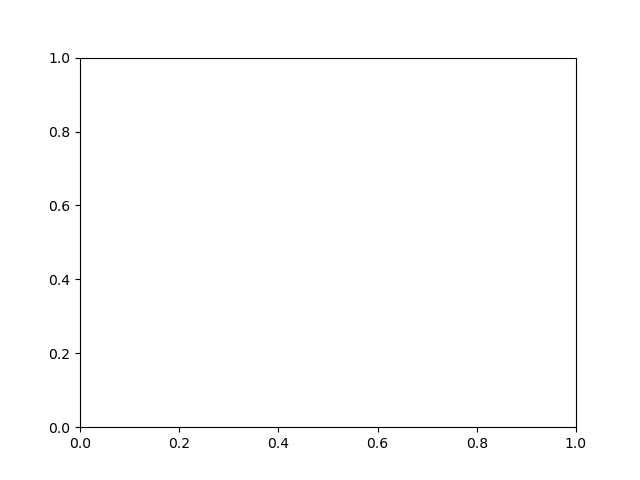

In [163]:
if "quantitative_comparison_fig" in locals():
    plt.close(quantitative_comparison_fig)

quantitative_comparison_fig = plt.figure()
quantitative_comparison_ax = quantitative_comparison_fig.gca()

In [406]:
quantitative_comparison_ax.clear()

###
QUANTITY = "pos"

USER2USER_FIXED = False  #if True, compare predictability of user movements of USER_ID_FIXED between simulation and other users
USER2USER = False  #if True, compare predictability of user movements (of all users) between simulation and respective other users

SIM2USER_PER_USER = True  #if True, compare cost function simulation for each user separately
###
if len(SIMULATION_SUBDIR_LIST) > 1:
    map_conditions = lambda x: "Joint Acceleration" if "accjoint" in x else "CTC" if "ctc" in x else "Distance and\nControl Costs" if "cso" in x else x
else:
    map_conditions = lambda x: x if x.startswith("U") else "Simulation"
label_dict = {"pos": ("Cursor Positions", r"$(m)$"),
             "vel": ("Cursor Velocities", r"$\left(\frac{m}{s}\right)$"),
             "acc": ("Cursor Accelerations", r"$\left(\frac{m}{s^2}\right)$"),
             "qpos": ("Joint Angles", r"$(rad)$"),
             "qvel": ("Joint Velocities", r"$\left(\frac{rad}{s}\right)$"),
             "qacc": ("Joint Acceleration", r"$\left(\frac{rad}{s^2}\right)$")}

if USER2USER_FIXED:
    res_dict = locals()[f"res_dict_predict_fixeduser_{QUANTITY}"]
    quantitative_comparison_ax.set_yscale("log")
elif USER2USER:
    res_dict = locals()[f"res_dict_predict_{QUANTITY}"]
else:
    res_dict = locals()[f"res_dict_{QUANTITY}"]
    quantitative_comparison_ax.set_yscale("log")

quantitative_comparison_ax.set_title(f"RMSE – All Trials of {USER_ID_FIXED} – {label_dict[QUANTITY][0]}" if USER2USER_FIXED else f"RMSE – All Trials – {label_dict[QUANTITY][0]}", fontsize=14)
quantitative_comparison_ax.set_ylabel(f"RMSE {label_dict[QUANTITY][1]}", fontsize=14)
quantitative_comparison_ax.set_yscale("log")
quantitative_comparison_ax.tick_params(axis='both', which='major', labelsize=14)
quantitative_comparison_ax.tick_params(axis='both', which='minor', labelsize=12)

if SIM2USER_PER_USER:
    assert not (USER2USER or USER2USER_FIXED)
    boxplot_df_melt = pd.DataFrame()
    boxplot_df_user = pd.Series(dtype=str)
    for i in range(len(USER_ID_LIST)):
        boxplot_df = pd.DataFrame({map_conditions(k): pd.Series(np.concatenate(v[i*len(TASK_CONDITION_LIST): (i+1)*len(TASK_CONDITION_LIST)]).ravel()) for k, v in res_dict.items()})

        boxplot_df_melt = pd.concat((boxplot_df_melt, boxplot_df.melt()))
        boxplot_df_user = pd.concat((boxplot_df_user, pd.Series([USER_ID_LIST[i]] * boxplot_df.melt().shape[0])))
    boxplot_df_melt["User"] = boxplot_df_user
    boxplot_df_melt = boxplot_df_melt.rename({'variable': 'Cost function', 'value': f"RMSE {label_dict[QUANTITY][1]}"}, axis=1)
    sns.boxplot(data=boxplot_df_melt, x="User", y=f"RMSE {label_dict[QUANTITY][1]}", hue="Cost function", ax=quantitative_comparison_ax)
else:
    boxplot_df = pd.DataFrame({map_conditions(k): pd.Series(np.concatenate(v).ravel()) for k, v in res_dict.items()})
    
    sns.boxplot(data=boxplot_df, ax=quantitative_comparison_ax)
if USER2USER_FIXED:
    add_stat_annotation(data=boxplot_df, ax=quantitative_comparison_ax, box_pairs=[(map_conditions(i), j) for i in SIMULATION_SUBDIR_LIST for j in USER_ID_LIST if j != USER_ID_FIXED], test="Kruskal", text_format="star", loc="inside", verbose=2)
else:
    if not SIM2USER_PER_USER:
        add_stat_annotation(data=boxplot_df, ax=quantitative_comparison_ax, box_pairs=itertools.combinations(boxplot_df.keys(), 2), test="Kruskal", text_format="star", loc="inside", verbose=2)

# STORE TO FILE
if USER2USER_FIXED:
    plot_filename_quantitative_ID = f"MPC/{_plot_SIMULATION_SUBDIR_LIST}/{USER_ID_FIXED}_FIXED/{_plot_TASK_CONDITION_LIST}/RMSE_{QUANTITY}"
elif USER2USER:
    plot_filename_quantitative_ID = f"MPC/{_plot_SIMULATION_SUBDIR_LIST}/ALLUSERS/{_plot_TASK_CONDITION_LIST}/RMSE_{QUANTITY}"
else:
    if SIM2USER_PER_USER:
        plot_filename_quantitative_ID = f"MPC/{_plot_SIMULATION_SUBDIR_LIST}/ALLUSERS/{_plot_TASK_CONDITION_LIST}/RMSE_simonly_peruser_{QUANTITY}"
    else:
        plot_filename_quantitative_ID = f"MPC/{_plot_SIMULATION_SUBDIR_LIST}/ALLUSERS/{_plot_TASK_CONDITION_LIST}/RMSE_simonly_{QUANTITY}"

quantitative_comparison_fig.savefig(f"/home/florian/reacher_sg/_plots/{plot_filename_quantitative_ID}.png", dpi=300)


### Other Stuff (Testing)

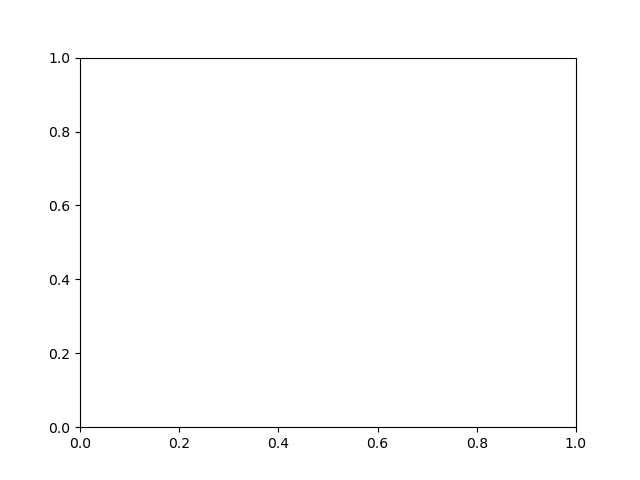

In [49]:
if "repeated_movements_fig" in locals():
    plt.close(repeated_movements_fig)
plt.ion()
repeated_movements_fig = plt.figure()
repeated_movements_ax = repeated_movements_fig.gca()
# repeated_movements_fig, repeated_movements_ax = plt.subplots(1, 2, figsize=[9, 3])

In [181]:
MOVEMENT_ID = "1".zfill(2)

rep_movs_filepath = f"~/user-in-the-box/output/{REP_MOVS_FILENAME}/repeated-movements/movement_{MOVEMENT_ID}/radius_4/state_log.pickle"

rep_movs_data = []
with open(os.path.expanduser(rep_movs_filepath), "rb") as f:
    rep_movs_data = pickle.load(f)

np.where(rep_movs_data["episode_1"]["target_hit"])

(array([ 79, 117]),)

In [1350]:
repeated_movements_ax.clear()

###
REP_MOVS_FILENAME = "NegativeExpDistance-neural"

REMOVE_OUTLIERS = True

USE_TARGETBOUND_AS_DIST = False
DWELL_TIME = 0.3  #only used if USE_TARGETBOUND_AS_DIST == False

PLOT_TYPE = "mean_groups"  #"alldata", "boxplot", "mean_groups", "meandata", "density_ID"
BOXPLOT_category = "ID"
BOXPLOT_nbins = 5
BOXPLOT_qbins = True  #whether to use quantile-based bins (i.e., same number of samples per bin) or range-based bins (i.e., same length of each bin interval)

DENSITY_group_nIDbins = 5  #number of ID groups
DENSITY_group_IDbin_ID = 4  #index of ID group (between 0 and DENSITY_group_nIDbins-1) for which a density plot of movement times is created (only used if PLOT_TYPE == "density_ID")
DENSITY_group_nMTbins = 50
###

rep_movs_filepath = f"~/user-in-the-box/output/{REP_MOVS_FILENAME}/repeated-movements"

if PLOT_TYPE != "boxplot":
    BOXPLOT_category = "ID (bits)"  #used for xlabel

# Compute ID and MT pairs from dataset:
distance_list = []
width_list = []
ID_list = []
MT_list = []
target_position_list = []
initial_position_list = []
failed_movements_counter = 0
for EPISODE_ID, data_episode in data.items():
    position_series = data_episode["fingertip_xpos"]
    time_per_step = np.diff(data_episode["timestep"]).mean()  #0.01
#    indices = np.append(np.insert(np.where(data_episode["target_hit"])[0], 0, 0), len(data_episode["target_hit"]))
    indices = np.insert(np.where(data_episode["target_spawned"])[0], 0, 0)
    for last_idx, current_idx, next_idx in list(zip(np.concatenate(([-1], indices[:-1])), indices, indices[1:])):
        #test[idx] = (next_idx - current_idx, data_episode["target_radius"][current_idx])
        width = 2 * data_episode["target_radius"][current_idx]
        # use nominal distance:
        #TODO: use "effective_projection_path" parameter
        init_val = data_episode["target_position"][last_idx] if last_idx >= 0 else position_series[0]
        if USE_TARGETBOUND_AS_DIST:
            if "inside_target" not in data_episode:  #use "target_radius" column
                assert len(np.unique(data_episode["target_radius"][current_idx + 1:next_idx])) == 1, "ERROR: Target radius changes during movement! Cannot find reliable information about when target has been entered.\nFix dataset or use target center as distance (set 'USE_TARGETBOUND_AS_DIST=False')."
                rel_indices_targetbound = np.where(np.linalg.norm(np.array(position_series[current_idx + 1:next_idx]) - np.array(data_episode["target_position"][current_idx + 1:next_idx]), axis=1) < data_episode["target_radius"][current_idx + 1])[0]
            else:  #use "inside_target" column
                rel_indices_targetbound = np.where(data_episode["inside_target"][current_idx + 1:next_idx])[0]
            if len(rel_indices_targetbound) > 0 :
                targetbound_idx = current_idx + 1 + rel_indices_targetbound[0]
            else:  #movement failed
                failed_movements_counter += 1
                continue
            final_val = position_series[targetbound_idx]
        else:
            final_val = data_episode["target_position"][current_idx] #or position_series[next_idx - 1]
        if isinstance(final_val, tuple) and len(final_val) == 1:
            final_val = final_val[0]
        # # use effective distance:
        # init_val = position_series[current_idx]
        # final_val = position_series[next_idx - 1]
        ######################################
        distance = np.linalg.norm(final_val - init_val)
        fitts_ID = np.log2(2*distance/width)
        width_list.append(width)
        distance_list.append(distance)
        ID_list.append(fitts_ID)
        if USE_TARGETBOUND_AS_DIST:
            MT_list.append((targetbound_idx - current_idx)*time_per_step)
        else:
            MT_list.append((next_idx - current_idx)*time_per_step - DWELL_TIME)
        target_position_list.append(final_val)
        initial_position_list.append(init_val)
# Remove outliers:
movement_indices_TO_DELETE = []
if REMOVE_OUTLIERS:
    # Ensure that too long movements are removed (all movements with duration - mean(duration) > 3 * std(duration))
    #MT_list_zscores = stats.zscore(MT_list)
    #movement_indices_TO_DELETE = np.where(np.abs(stats.zscore(MT_list)) > 3)[0].tolist()
    
    movement_indices_TO_DELETE = np.where(np.array(MT_list) >= 4.0 - DWELL_TIME)[0].tolist()

    distance_list = [val for idx, val in enumerate(distance_list) if idx not in movement_indices_TO_DELETE]
    width_list = [val for idx, val in enumerate(width_list) if idx not in movement_indices_TO_DELETE]
    ID_list = [val for idx, val in enumerate(ID_list) if idx not in movement_indices_TO_DELETE]
    MT_list = [val for idx, val in enumerate(MT_list) if idx not in movement_indices_TO_DELETE]
    target_position_list = [val for idx, val in enumerate(target_position_list) if idx not in movement_indices_TO_DELETE]
    initial_position_list = [val for idx, val in enumerate(initial_position_list) if idx not in movement_indices_TO_DELETE]

add_info = f'{len(movement_indices_TO_DELETE)} outliers were dropped' if movement_indices_TO_DELETE else '', f'{failed_movements_counter} movements failed' if failed_movements_counter else ''
add_info_nonempty = [i for i in add_info if len(i)]
add_info_str = f" ({'; '.join(add_info_nonempty)})" if add_info_nonempty else ""
print(f"INFO: Using {len(ID_list)} movements from {len(data)} episodes{add_info_str}.")

# Linear regression:
poly_coef = np.polyfit(ID_list, MT_list, 1)
p_linreg = np.poly1d(poly_coef)

# Coefficient of determination:
SQE = np.square(np.linalg.norm(p_linreg(ID_list) - np.mean(MT_list)))
SQT = np.square(np.linalg.norm(MT_list - np.mean(MT_list)))
R2 = SQE/SQT
print("Fitts' Law - Coefficient of determination (R^2): {}".format(R2))

if PLOT_TYPE == "boxplot":
    df = pd.DataFrame({"Distance": distance_list, "Width": width_list, "ID": ID_list, "MT": MT_list})
    if BOXPLOT_qbins:
        df_bins = df.groupby([pd.qcut(df[BOXPLOT_category], BOXPLOT_nbins)])["MT"].apply(list)
    else:
        df_bins = df.groupby([pd.cut(df[BOXPLOT_category], BOXPLOT_nbins)])["MT"].apply(list)
    df_bins_renamed = df_bins.rename(lambda x: f"{x.left.round(2)}-{x.right.round(2)}", axis=0)
    repeated_movements_ax.boxplot(df_bins_renamed, labels=df_bins_renamed.index, positions=[x.mid for x in df_bins.index], widths=[0.8*(x.right - x.left) for x in df_bins.index])
    repeated_movements_ax.relim()
    if BOXPLOT_category == "ID":
        lin_regression_x = locals()[f"{BOXPLOT_category}_list"]
        lin_regression_y = p_linreg(ID_list)
        lin_regression_sorted = sorted(zip(lin_regression_x, lin_regression_y))
        lin_regression_x = [x for x, y in lin_regression_sorted]
        lin_regression_y = [y for x, y in lin_regression_sorted]
        repeated_movements_ax.plot(lin_regression_x, lin_regression_y, color="red")
elif PLOT_TYPE == "mean_groups":
    df = pd.DataFrame({"Distance": distance_list, "Width": width_list, "ID": ID_list, "MT": MT_list})
    if BOXPLOT_qbins:
        df_bins_groupby = df.groupby([pd.qcut(df["Distance"], BOXPLOT_nbins), pd.qcut(df["Width"], BOXPLOT_nbins)])["MT"]
    else:
        df_bins_groupby = df.groupby([pd.cut(df["Distance"], BOXPLOT_nbins), pd.cut(df["Width"], BOXPLOT_nbins)])["MT"]
    df_bins = df_bins_groupby.mean()
    df_bins_renamed = df_bins.rename(lambda x: f"{x.left.round(2)}-{x.right.round(2)}", axis=0)
    df_bins_renamed.index = df_bins_renamed.index.map(lambda x: f"D: {x[0]}, W: {x[1]}")
    trans_dict_dist = {number: chr(ord('@')+number+1) for number in range(BOXPLOT_nbins)}
    trans_dict_width = {number: str(number) for number in range(BOXPLOT_nbins)}
    group_identifiers_dist = [(str(trans_dict_dist[idx]), f"D: {value}") for idx, value in enumerate(df_bins.index.get_level_values(0).unique().tolist())]
    group_identifiers_width = [(str(trans_dict_width[idx]), f"W: {value}") for idx, value in enumerate(df_bins.index.get_level_values(1).unique().tolist())]
    group_identifiers = df_bins.index.map(lambda x: "".join([trans_dict_dist[df_bins.index.get_level_values(0).unique().tolist().index(x[0])], trans_dict_width[df_bins.index.get_level_values(1).unique().tolist().index(x[1])]]))
    if BOXPLOT_qbins:
        df["classification"] = [df_bins.index.get_loc((x["Distance"], x["Width"])) for _, x in pd.concat((pd.qcut(df["Distance"], BOXPLOT_nbins), pd.qcut(df["Width"], BOXPLOT_nbins)), axis=1).iterrows()]
    else:
        df["classification"] = [df_bins.index.get_loc((x["Distance"], x["Width"])) for _, x in pd.concat((pd.cut(df["Distance"], BOXPLOT_nbins), pd.cut(df["Width"], BOXPLOT_nbins)), axis=1).iterrows()]
    df_bins = df_bins.reset_index()
    df_bins["ID"] = df_bins.apply(lambda x: pd.Interval(np.log2(2*x["Distance"].left / x["Width"].right), np.log2(2*x["Distance"].right / x["Width"].left)), axis=1)
    df_bins["Average ID"] = df_bins.apply(lambda x: np.log2(2*x["Distance"].mid / x["Width"].mid), axis=1)
    df_bins["Number of Samples"] = df_bins_groupby.size().reset_index(drop=True)
    xtick_offset = 0
    
    ### ONLY SHOW SOME CONDITIONS:
    # df = df.loc[(df["classification"] >= 5) & (df["classification"] < 15)]
    # group_identifiers_dist = group_identifiers_dist[1:3]
    # group_identifiers = group_identifiers[5:15]
    # df_bins = df_bins.iloc[5:15]
    # df_bins_renamed = df_bins_renamed.iloc[5:15]
    # xtick_offset = 5

    repeated_movements_ax.scatter(range(xtick_offset, xtick_offset + len(df_bins_renamed)), df_bins_renamed, color="red")#, positions=[x.mid for x in df_bins.index], widths=[0.8*(x.right - x.left) for x in df_bins.index])
    repeated_movements_ax.scatter(df["classification"], df["MT"], color="blue", s=0.2)
    ## VARIANT 1 - detailed xlabels:
    #repeated_movements_ax.set_xticks(range(len(df_bins_renamed)), df_bins_renamed.index, fontsize=4)
    ## VARIANT 2 - abbreviations as xlabels, additional legend:
    #repeated_movements_ax.set_xticks(df_bins[~df_bins["MT"].isna()].index, df_bins[~df_bins["MT"].isna()].index + 1)
    repeated_movements_ax.set_xticks(df_bins[~df_bins["MT"].isna()].index, group_identifiers[~df_bins["MT"].isna()])
    class MarkerHandler(mpl.legend_handler.HandlerBase):  #source: https://stackoverflow.com/a/47395401
        def create_artists(self, legend, integer, xdescent, ydescent,
                            width, height, fontsize,trans):
            marker_obj = mpl.markers.MarkerStyle(f'${integer}$') #Here you place your integer
            path = marker_obj.get_path().transformed(marker_obj.get_transform())

            path._vertices = np.array(path._vertices)*8 #To make it larger
            patch = mpl.patches.PathPatch(path, color="black", lw=0, transform=trans+mpl.transforms.Affine2D().translate(0, 5.5))
            return [patch]
    repeated_movements_ax.legend([x for x, y in group_identifiers_dist + group_identifiers_width], [y for x,y in group_identifiers_dist + group_identifiers_width], handler_map={str:MarkerHandler()}, handletextpad=0, handlelength=1)#, fontsize=8)
    ################################
    repeated_movements_ax.relim()
elif PLOT_TYPE == "meandata":
    df = pd.DataFrame({"Distance": distance_list, "Width": width_list, "ID": ID_list, "MT": MT_list})
    if BOXPLOT_qbins:
        df_bins_groupby = df.groupby([pd.qcut(df["Distance"], BOXPLOT_nbins), pd.qcut(df["Width"], BOXPLOT_nbins)])["MT"]
    else:
        df_bins_groupby = df.groupby([pd.cut(df["Distance"], BOXPLOT_nbins), pd.cut(df["Width"], BOXPLOT_nbins)])["MT"]        
    df_bins = df_bins_groupby.mean()
    df_bins_renamed = df_bins.rename(lambda x: f"{x.left.round(2)}-{x.right.round(2)}", axis=0)
    df_bins_renamed.index = df_bins_renamed.index.map(lambda x: f"D: {x[0]}, W: {x[1]}")
    df_bins = df_bins.reset_index()
    df_bins["ID"] = df_bins.apply(lambda x: pd.Interval(np.log2(2*x["Distance"].left / x["Width"].right), np.log2(2*x["Distance"].right / x["Width"].left)), axis=1)
    df_bins["Average ID"] = df_bins.apply(lambda x: np.log2(2*x["Distance"].mid / x["Width"].mid), axis=1)
    df_bins["Number of Samples"] = df_bins_groupby.size().reset_index(drop=True)
    
    ### ONLY SHOW SOME CONDITIONS:
#     df_bins = df_bins.iloc[5:15]
#     df_bins_renamed = df_bins_renamed.iloc[5:15]
    
    repeated_movements_ax.scatter(df_bins["Average ID"], df_bins["MT"])
    repeated_movements_ax.plot(df_bins["Average ID"], p_linreg(df_bins["Average ID"]), color="red")
    
    # Coefficient of determination on mean groups:
    ID_list_mean = df_bins.loc[~df_bins["MT"].isna(), "Average ID"]
    MT_list_mean = df_bins.loc[~df_bins["MT"].isna(), "MT"]
    poly_coef_mean = np.polyfit(ID_list_mean, MT_list_mean, 1)
    p_linreg_mean = np.poly1d(poly_coef_mean)
    SQE_mean = np.square(np.linalg.norm(p_linreg_mean(ID_list_mean) - np.mean(MT_list_mean)))
    SQT_mean = np.square(np.linalg.norm(MT_list_mean - np.mean(MT_list_mean)))
    R2_mean = SQE_mean/SQT_mean
    print("Fitts' Law [ON MEAN PER CONDITION] - Coefficient of determination (R^2): {}".format(R2_mean))
elif PLOT_TYPE == "alldata":
    repeated_movements_ax.scatter(ID_list, MT_list)
    repeated_movements_ax.plot(ID_list, p_linreg(ID_list), color="red")
elif PLOT_TYPE == "density_ID":
    df = pd.DataFrame({"Distance": distance_list, "Width": width_list, "ID": ID_list, "MT": MT_list})
    if BOXPLOT_qbins:
        df_bins_ID_helper = pd.qcut(df["ID"], DENSITY_group_nIDbins)
        df_bins_ID_groupby = df.groupby([df_bins_ID_helper])["MT"]
        df_bins_ID = df_bins_ID_groupby.mean()
        df["classification"] = [df_bins_ID.index.get_loc(x) for x in df_bins_ID_helper.values]
    else:
        df_bins_ID_helper = pd.cut(df["ID"], DENSITY_group_nIDbins)
        df_bins_ID_groupby = df.groupby([df_bins_ID_helper])["MT"]
        df_bins_ID = df_bins_ID_groupby.mean()
        df["classification"] = [df_bins_ID.index.get_loc(x) for x in df_bins_ID_helper.values]
    ID_groups = sorted(df_bins_ID_helper.unique())
    df_bins_ID = df_bins_ID.reset_index()
    df_bins_ID["Average ID"] = df_bins_ID.apply(lambda x: x["ID"].mid, axis=1)
    df_bins_ID["Number of Samples"] = df_bins_ID_groupby.size().reset_index(drop=True)

    repeated_movements_ax.hist(df.loc[df["classification"] == DENSITY_group_IDbin_ID, "MT"], DENSITY_group_nMTbins)
else:
    raise NotImplementedError

# # Save the default tick positions, so we can reset them...
# locs = repeated_movements_ax.get_xticks()
# # Reset the xtick locations.
# repeated_movements_ax.set_xticks(locs)

if PLOT_TYPE == "density_ID":
    repeated_movements_ax.set_xlabel("MT (s)")
elif PLOT_TYPE not in ["mean_groups"]:
    repeated_movements_ax.set_xlabel(BOXPLOT_category + (f" bits" if (BOXPLOT_category == "ID") else "")) #"ID (bits)")  
if PLOT_TYPE == "density_ID":
    repeated_movements_ax.set_ylabel("Frequency")    
else:
    repeated_movements_ax.set_ylabel("MT (s)")
if PLOT_TYPE == "meandata":
    repeated_movements_ax.set_title("Fitts' Law on Mean Data ($R^2=${:.4f}; $a=${:.2f}, $b=${:.2f})".format(R2_mean, poly_coef_mean[1], poly_coef_mean[0]), fontsize=14) #fontsize=18)
elif PLOT_TYPE == "density_ID":
    repeated_movements_ax.set_title(f"Movement Time – Density Plot (ID: {ID_groups[DENSITY_group_IDbin_ID]})")
else:
    repeated_movements_ax.set_title("Fitts' Law ($R^2=${:.4f}; $a=${:.2f}, $b=${:.2f})".format(R2, poly_coef[1], poly_coef[0]), fontsize=14) #fontsize=18)

if PLOT_TYPE == "density_ID":
    repeated_movements_fig.savefig(f"plots/{REP_MOVS_FILENAME}/repeated_movs_movement_time_{PLOT_TYPE}group{DENSITY_group_IDbin_ID}.png", dpi=120)
else:
    repeated_movements_fig.savefig(f"plots/{REP_MOVS_FILENAME}/repeated_movs_fittslaw_{PLOT_TYPE}.png", dpi=120)
        

NameError: name 'repeated_movements_ax' is not defined

In [376]:
atest = pd.read_csv("/mnt/external/data/NewExperimentForCHI/U1/20200913-164321_Experiment_U1_Standing_ID_ISO_15_plane.csv")

atest2 = (atest.loc[:, "Target.Position.x":"Target Position.z"].iloc[0:] - atest.loc[0, "Shoulder.Position.x":"Shoulder.Position.z"].tolist()).to_numpy()
#target_array_user = (experiment_info.loc[:, "Target.Position.x":"Target Position.z"].iloc[0:]).to_numpy()
atest2 *= np.array([-1, 1, 1])
atest2 = atest2[:, [2, 0, 1]] #-np.array([0.55, 0, 0.1])
atest2[:13]#.mean(axis=0)

array([[ 5.5000e-01, -1.0000e-01, -1.5000e-01],
       [ 5.5000e-01, -1.3590e-01,  1.4564e-01],
       [ 5.5000e-01, -3.0300e-02, -1.3282e-01],
       [ 5.5000e-01, -1.9947e-01,  1.1228e-01],
       [ 5.5000e-01,  2.3440e-02, -8.5210e-02],
       [ 5.5000e-01, -2.4026e-01,  5.3190e-02],
       [ 5.5000e-01,  4.8900e-02, -1.8080e-02],
       [ 5.5000e-01, -2.4891e-01, -1.8080e-02],
       [ 5.5000e-01,  4.0250e-02,  5.3190e-02],
       [ 5.5000e-01, -2.2345e-01, -8.5210e-02],
       [ 5.5000e-01, -5.4000e-04,  1.1228e-01],
       [ 5.5000e-01, -1.6971e-01, -1.3282e-01],
       [ 5.5000e-01, -6.4110e-02,  1.4564e-01]])

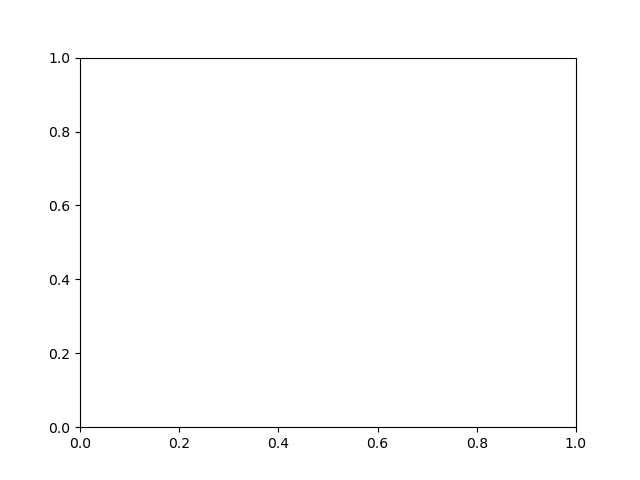

In [191]:
test_figg = plt.figure()
test_axx = test_figg.gca()

In [310]:
test_axx.clear()

test_study_targets = (target_position_series_STUDY[indices_STUDY[:, 0], :])[:, [2, 0, 1]]
test_axx.scatter(-test_study_targets[:13, 1], test_study_targets[:13, 2])
for idx, i in enumerate(test_study_targets[:13, :]):
    test_axx.annotate(indices_STUDY[idx, 3], (-i[1], i[2]))
    
test_simulation_targets = np.squeeze(target_position_series)[[i[1] for i in selected_movements_indices]]#[:, [0, 2, 1]]
test_axx.scatter(-test_simulation_targets[:, 1], test_simulation_targets[:, 2])
for idx, i in enumerate(test_simulation_targets):
    test_axx.annotate((idx+1)%13, (-i[1], i[2]), color="tab:red")



/tmp/ipykernel_1524650/1874692737.py:12: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  test_ax = test_fig.gca(projection="3d")


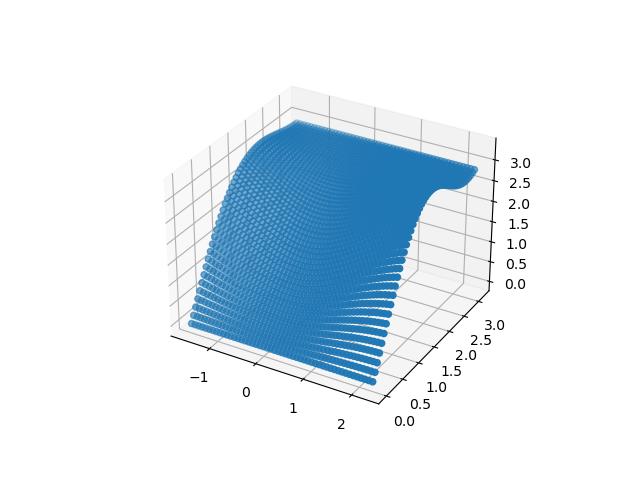

In [673]:
## shoulder1_r2 --> check shoulder ranges and proper definition of joint equality constraint
from scipy.spatial.transform import Rotation

#test = lambda alpha, beta: Rotation.from_euler("yxy", [alpha, -beta, -alpha]).apply(np.array([1,1,1]))
##test = lambda alpha, beta: Rotation.from_euler("yxy", [alpha, -beta, alpha]).apply(np.array([1,1,1])) if beta >= np.pi/2 else Rotation.from_euler("yxy", [alpha, -beta, -alpha]).apply(np.array([1,1,1]))
test = lambda alpha, beta: Rotation.from_euler("yxy", [alpha, -beta, -alpha + 2*beta/np.pi*alpha]).apply(np.array([1,1,1]))  #linear interpolation
#test = lambda alpha, beta: Rotation.from_euler("yxy", [alpha, -beta, -np.cos(beta)*alpha]).apply(np.array([1,1,1]))  #linear interpolation
#--> OPTIONAL [leads to previous shoulder_rot behavior at shoulder_elv=np.pi/2]: shoulder_rot range: [-np.pi/2, np.pi/9] -> [-np.pi/2, np.pi/9] - 2*np.min((beta, np.pi-beta))/np.pi*alpha
if "test_fig" in locals():
    plt.close(test_fig)
test_fig = plt.figure()
test_ax = test_fig.gca(projection="3d")

#test_mg = np.meshgrid(np.linspace(-np.pi/2, np.pi*13/18), np.linspace(np.pi/4, np.pi/4))
test_mg = np.meshgrid(np.linspace(-np.pi/2, np.pi*13/18), np.linspace(0, np.pi))
test_ax.scatter(*[i.flatten() for i in test_mg], [np.linalg.norm(test(x,y)-[1,1,1]) for x,y in zip(*[i.flatten() for i in test_mg])])

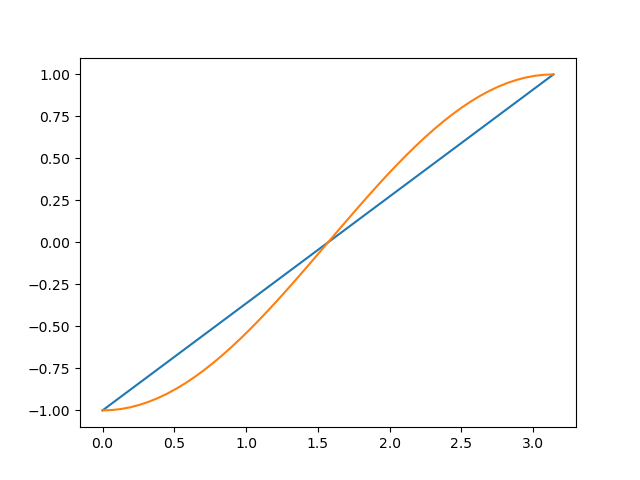

In [677]:
if "test_fig" in locals():
    plt.close(test_fig)
test_fig = plt.figure()
test_ax = test_fig.gca()

test_ax.plot(np.linspace(0, np.pi), list(map(lambda x: 2*x/np.pi - 1, np.linspace(0, np.pi))))
test_ax.plot(np.linspace(0, np.pi), list(map(lambda x: -np.cos(x), np.linspace(0, np.pi))))

### Visualization of replayed movements (also see (commented parts of) test_mujoco.py)



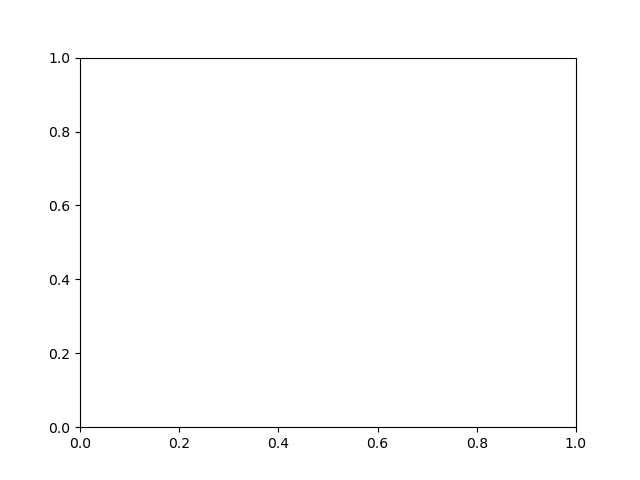

In [570]:
if "replay_fig" in locals():
    plt.close(replay_fig)
replay_fig = plt.figure()
replay_ax = replay_fig.gca()

In [571]:
action_f = interp1d(trajectories_STUDY.time_series_trial, trajectories_STUDY.action_series_trial, axis=0, fill_value="extrapolate")
action_test = action_f(np.arange(trajectories_STUDY.time_series_trial[0], trajectories_STUDY.time_series_trial[-1].round(2) + 0.01, 0.01))
np.save("/home/florian/test_delete/user-in-the-box/UIB/test/test_action.npy", action_test)

init_qposqvel = np.vstack((trajectories_STUDY.qpos_series_trial[0], trajectories_STUDY.qvel_series_trial[0]))
np.save("/home/florian/test_delete/user-in-the-box/UIB/test/test_initqposqvel.npy", init_qposqvel)

In [573]:
trajectories_STUDY.qpos_series_trial[:, 2]
new_qpos = np.load("/home/florian/test_delete/user-in-the-box/UIB/test/new_qpos.npy")
new_qvel = np.load("/home/florian/test_delete/user-in-the-box/UIB/test/new_qvel.npy")

qpos_f = interp1d(trajectories_STUDY.time_series_trial, trajectories_STUDY.qpos_series_trial, axis=0, fill_value="extrapolate")
qpos_test = qpos_f(np.arange(trajectories_STUDY.time_series_trial[0], trajectories_STUDY.time_series_trial[-1].round(2) + 0.01, 0.01))

replay_ax.clear()
replay_ax.plot(trajectories_STUDY.qpos_series_trial)
replay_ax.plot(qpos_test, label=independent_joints)
replay_ax.set_prop_cycle(None)
replay_ax.plot(new_qpos, linestyle='--')
replay_ax.legend()